In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aux.ts_functions as ts
import seaborn as sns; sns.set()
import numpy as np
import warnings
import os
from scipy.stats import pearsonr
from IPython.display import Image
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

data_dir = "./../data/"

## Functions

### Loading

In [3]:
def get_ts(df, area, specie, toxin, resample_code, plot=True, show_df=False):
    if not isinstance(toxin, list):
        toxin = [toxin]
    ts = df[ (df["Production_Area"]==area) & (biotoxins_ts["Species"]==specie)]
    ts = ts.resample(resample_code).mean()
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ts.plot(ax=ax, marker='o', markersize=2)
    if show_df: 
        display(ts[toxin].head())
    return ts[toxin]


### Imputation

In [4]:
def seasonal_mean(ts, n, lr=1):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

# linear, quadratic, cubic, knn, seasonal_year, seasonal_month 
def plot_imputations(ts, target, imputations, begin, end, n_neighbours=10):
    n = len(imputations)
    fig, ax = plt.subplots(n+1,1, figsize=(12,14), constrained_layout=True)
    
    imp = ts[target].interpolate(method="linear")
    imp.plot(ax=ax[0], style='-r')
    ts[target].plot(ax=ax[0], style='-b')
    ax[0].set_title("Example imputation")
    
    i = 1
    if "linear" in imputations:
        imp = ts[target].interpolate(method="linear")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Linear interpolation")
        i+=1
        
    if "quadratic" in imputations:
        imp = ts[target].interpolate(method="quadratic")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Quadratic interpolation")
        i+=1
        
    if "cubic" in imputations:
        imp = ts[target].interpolate(method="cubic")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Cubic interpolation")
        i+=1
        
    if "knn" in imputations:
        imp = pd.Series(data=knn_mean(ts[target], n_neighbours), index=ts[target].index)
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("KNN mean")
        i+=1
        
    if "seasonal_year" in imputations:
        imp = ts.copy()
        imp[target] = seasonal_mean(ts[target], n=52)
        imp = imp[target]
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Seasonal (year) mean")
        i+=1
        
    if "seasonal_month" in imputations:
        imp = ts.copy()
        imp[target] = seasonal_mean(ts[target], n=4)
        imp = imp[target]
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Seasonal (month) mean")
        i+=1
    
    plt.show()

### Seasonality

In [5]:
def plot_season_per(ts, by, ax, toxin='dsp_toxins', hline=160):
    ts = ts.copy()
    ts['year'] = [d.year for d in ts.index]
    years = ts['year'].unique()

    if by.lower() == "w":
        code = '%W'
    elif by.lower() == "m":
        code = '%b'
        
    ts['per'] = [d.strftime(code) for d in ts.index]

    for i, y in enumerate(years):
        per_year = ts.loc[ts['year']==y]
        ax.plot('per', toxin, data=per_year, label=y, marker='o', markersize=3)
    
    ax.set_title(f"Per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    ax.legend()
    return ax

def boxplot_season_per(ts, by, ax, toxin='dsp_toxins', hline=160):
    ts = ts.copy()
    ts['year'] = [d.year for d in ts.index]
    years = ts['year'].unique()

    if by.lower() == "w":
        code = '%W'
    elif by.lower() == "m":
        code = '%b'
        
    ts['per'] = [d.strftime(code) for d in ts.index]
    
    sns.boxplot(x='per', y=toxin, data=ts, ax=ax)
    ax.set_title(f"Per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

### Trend

In [6]:
def boxplot_trend(ts, ax, toxin='dsp_toxins', hline=160):
    ts = ts.copy()
    ts['year'] = [d.year for d in ts.index]
    years = ts['year'].unique()
        
    ts['month'] = [d.strftime('%b') for d in ts.index]

    sns.boxplot(x='year', y=toxin, data=ts, ax=ax)
    ax.set_title(f"Per year", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

def plot_trend(ts, ax, toxin='dsp_toxins', hline=160):
    ts = ts.copy()
    ts['year'] = [d.year for d in ts.index]
    years = ts['year'].unique()
        
    ts['month'] = [d.strftime('%b') for d in ts.index]

    sns.lineplot(x='year', y=toxin, data=ts, ax=ax)
    ax.set_title(f"Per year", fontsize=16)
    #ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

### Decompose

In [7]:
def decompose(ts):
    # Multiplicative Decomposition 
    result_mul = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq')

    # Additive Decomposition
    result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

    # Plot
    plt.rcParams.update({'figure.figsize': (10,8)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=14)
    result_add.plot().suptitle('Additive Decompose', fontsize=14)
    plt.show()

# Loading

![image](./images/ts_solutions.png)

![image](./images/regularize.png)

In [8]:
biotoxins = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', engine="openpyxl")

biotoxins_ts = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")
biotoxins_ts

Sample         Species         Sample_Point Production_Area  \
Date                                                                     
2015-01-05      1        Mexilhão              Jangada             LAL   
2015-01-05     20        Berbigão  Canal do Espinheiro           RIAV3   
2015-01-05     19        Berbigão           Costa Nova           RIAV2   
2015-01-05     18        Berbigão               Moacha           RIAV1   
2015-01-05     17  Amêijoa-branca             Torreira              L3   
...           ...             ...                  ...             ...   
2020-12-29   2211        Mexilhão             Povoação            POR2   
2020-12-29   2212        Mexilhão              Aljezur             L7a   
2020-12-29   2213        Mexilhão             Garganta            OLH4   
2020-12-29   2199        Mexilhão             Caparica             L5b   
2020-12-29   2215       Conquilha              Culatra              L8   

            dsp_toxins  asp_toxins  psp_toxins  
Date                                            
2015-01-05        20.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
2015-01-05        26.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
...                ...         ...         ...  
2020-12-29        36.0         1.8         NaN  
2020-12-29        36.0         NaN         NaN  
2020-12-29        36.0         NaN         NaN  
2020-12-29        36.0         1.8        71.0  
2020-12-29        36.0         1.8         NaN  

[13719 rows x 7 columns]

# LOB (Lágua de Óbidos)

In [8]:
area = "LOB"
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Berbigão            292
Mexilhão            289
Amêijoa-japonesa     38
Amêijoa-boa          19
Amêijoa-macha        17
Longueirão           13
Amêijoa-branca        1
Name: Species, dtype: int64

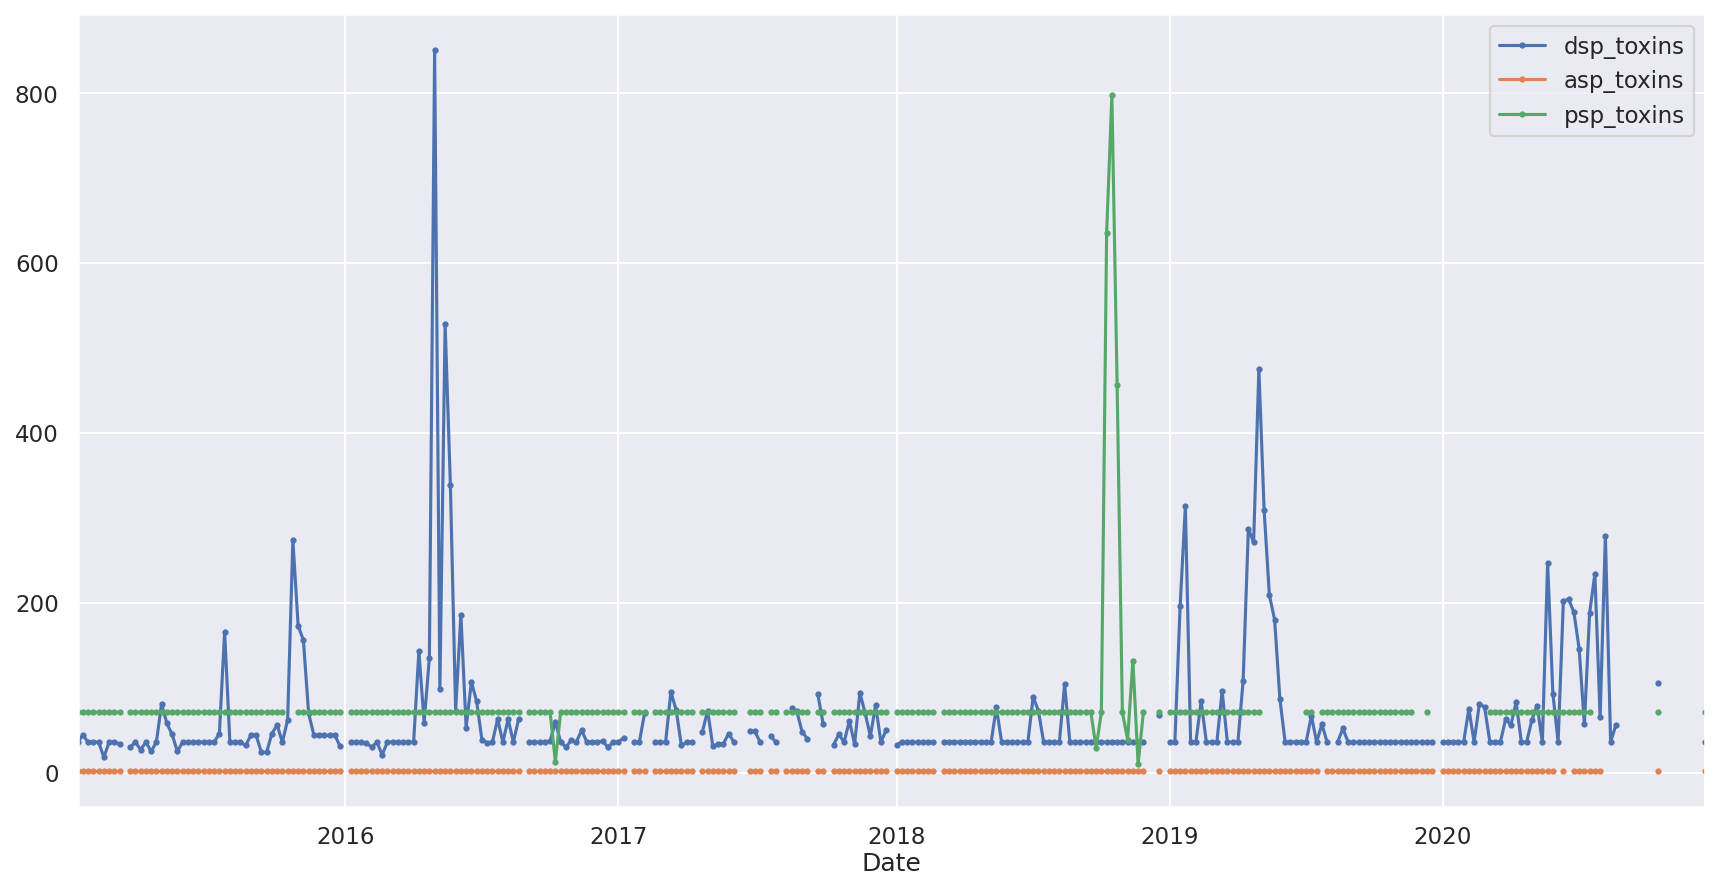

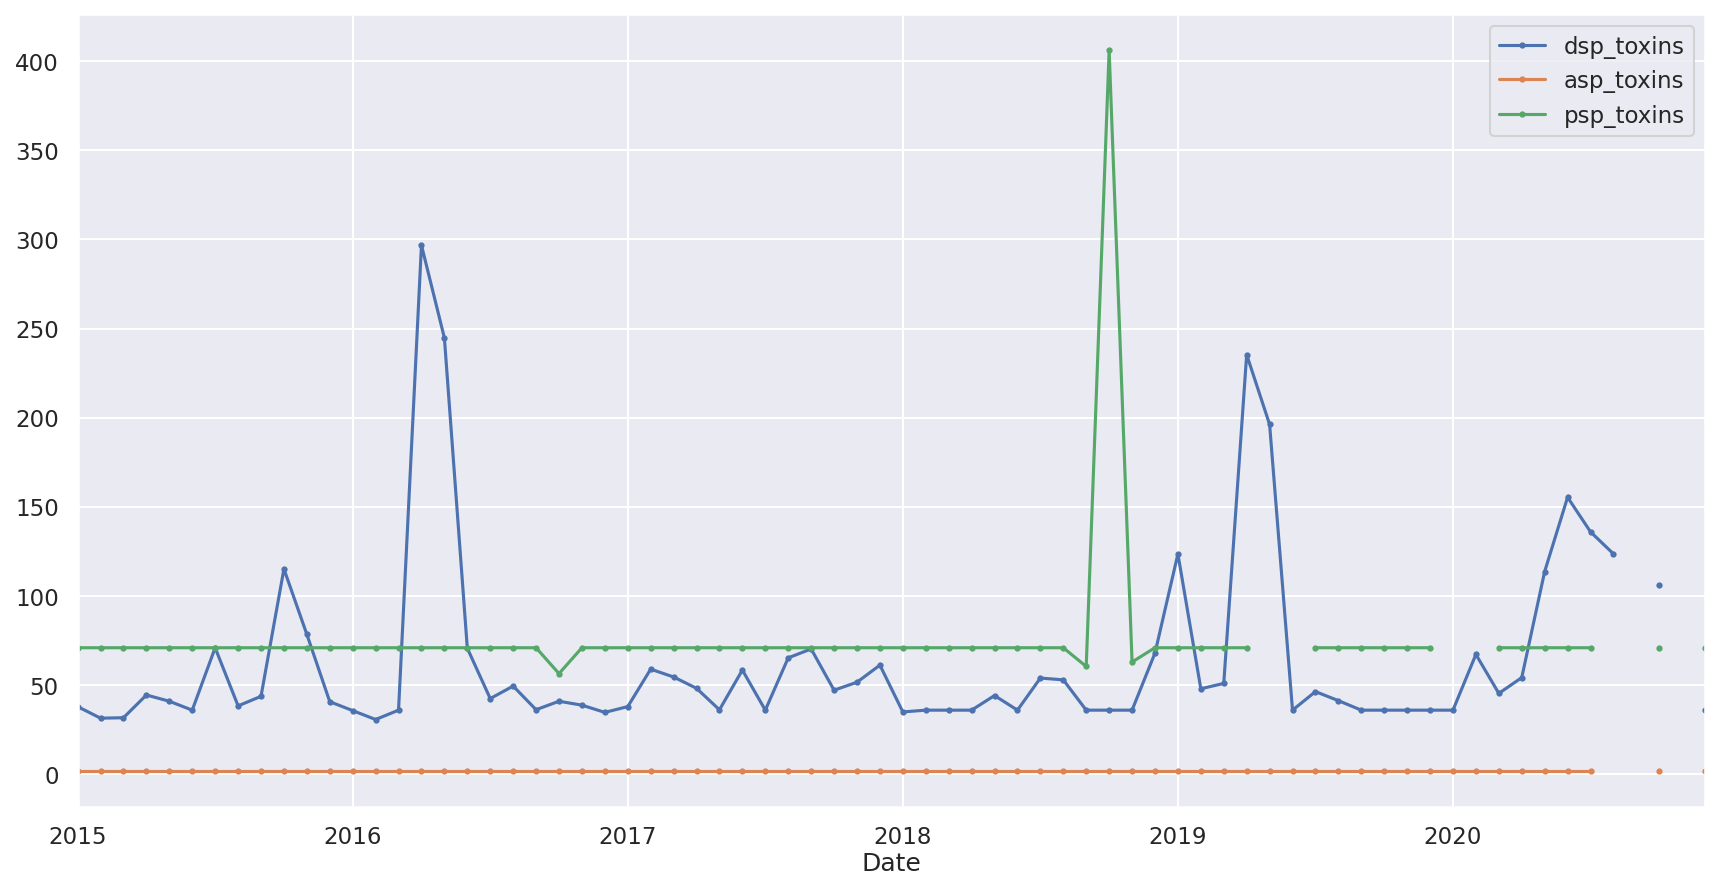

In [9]:
ts_week = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

Quando interpolado usando **week** a data representa o fim da semana

## Imputation

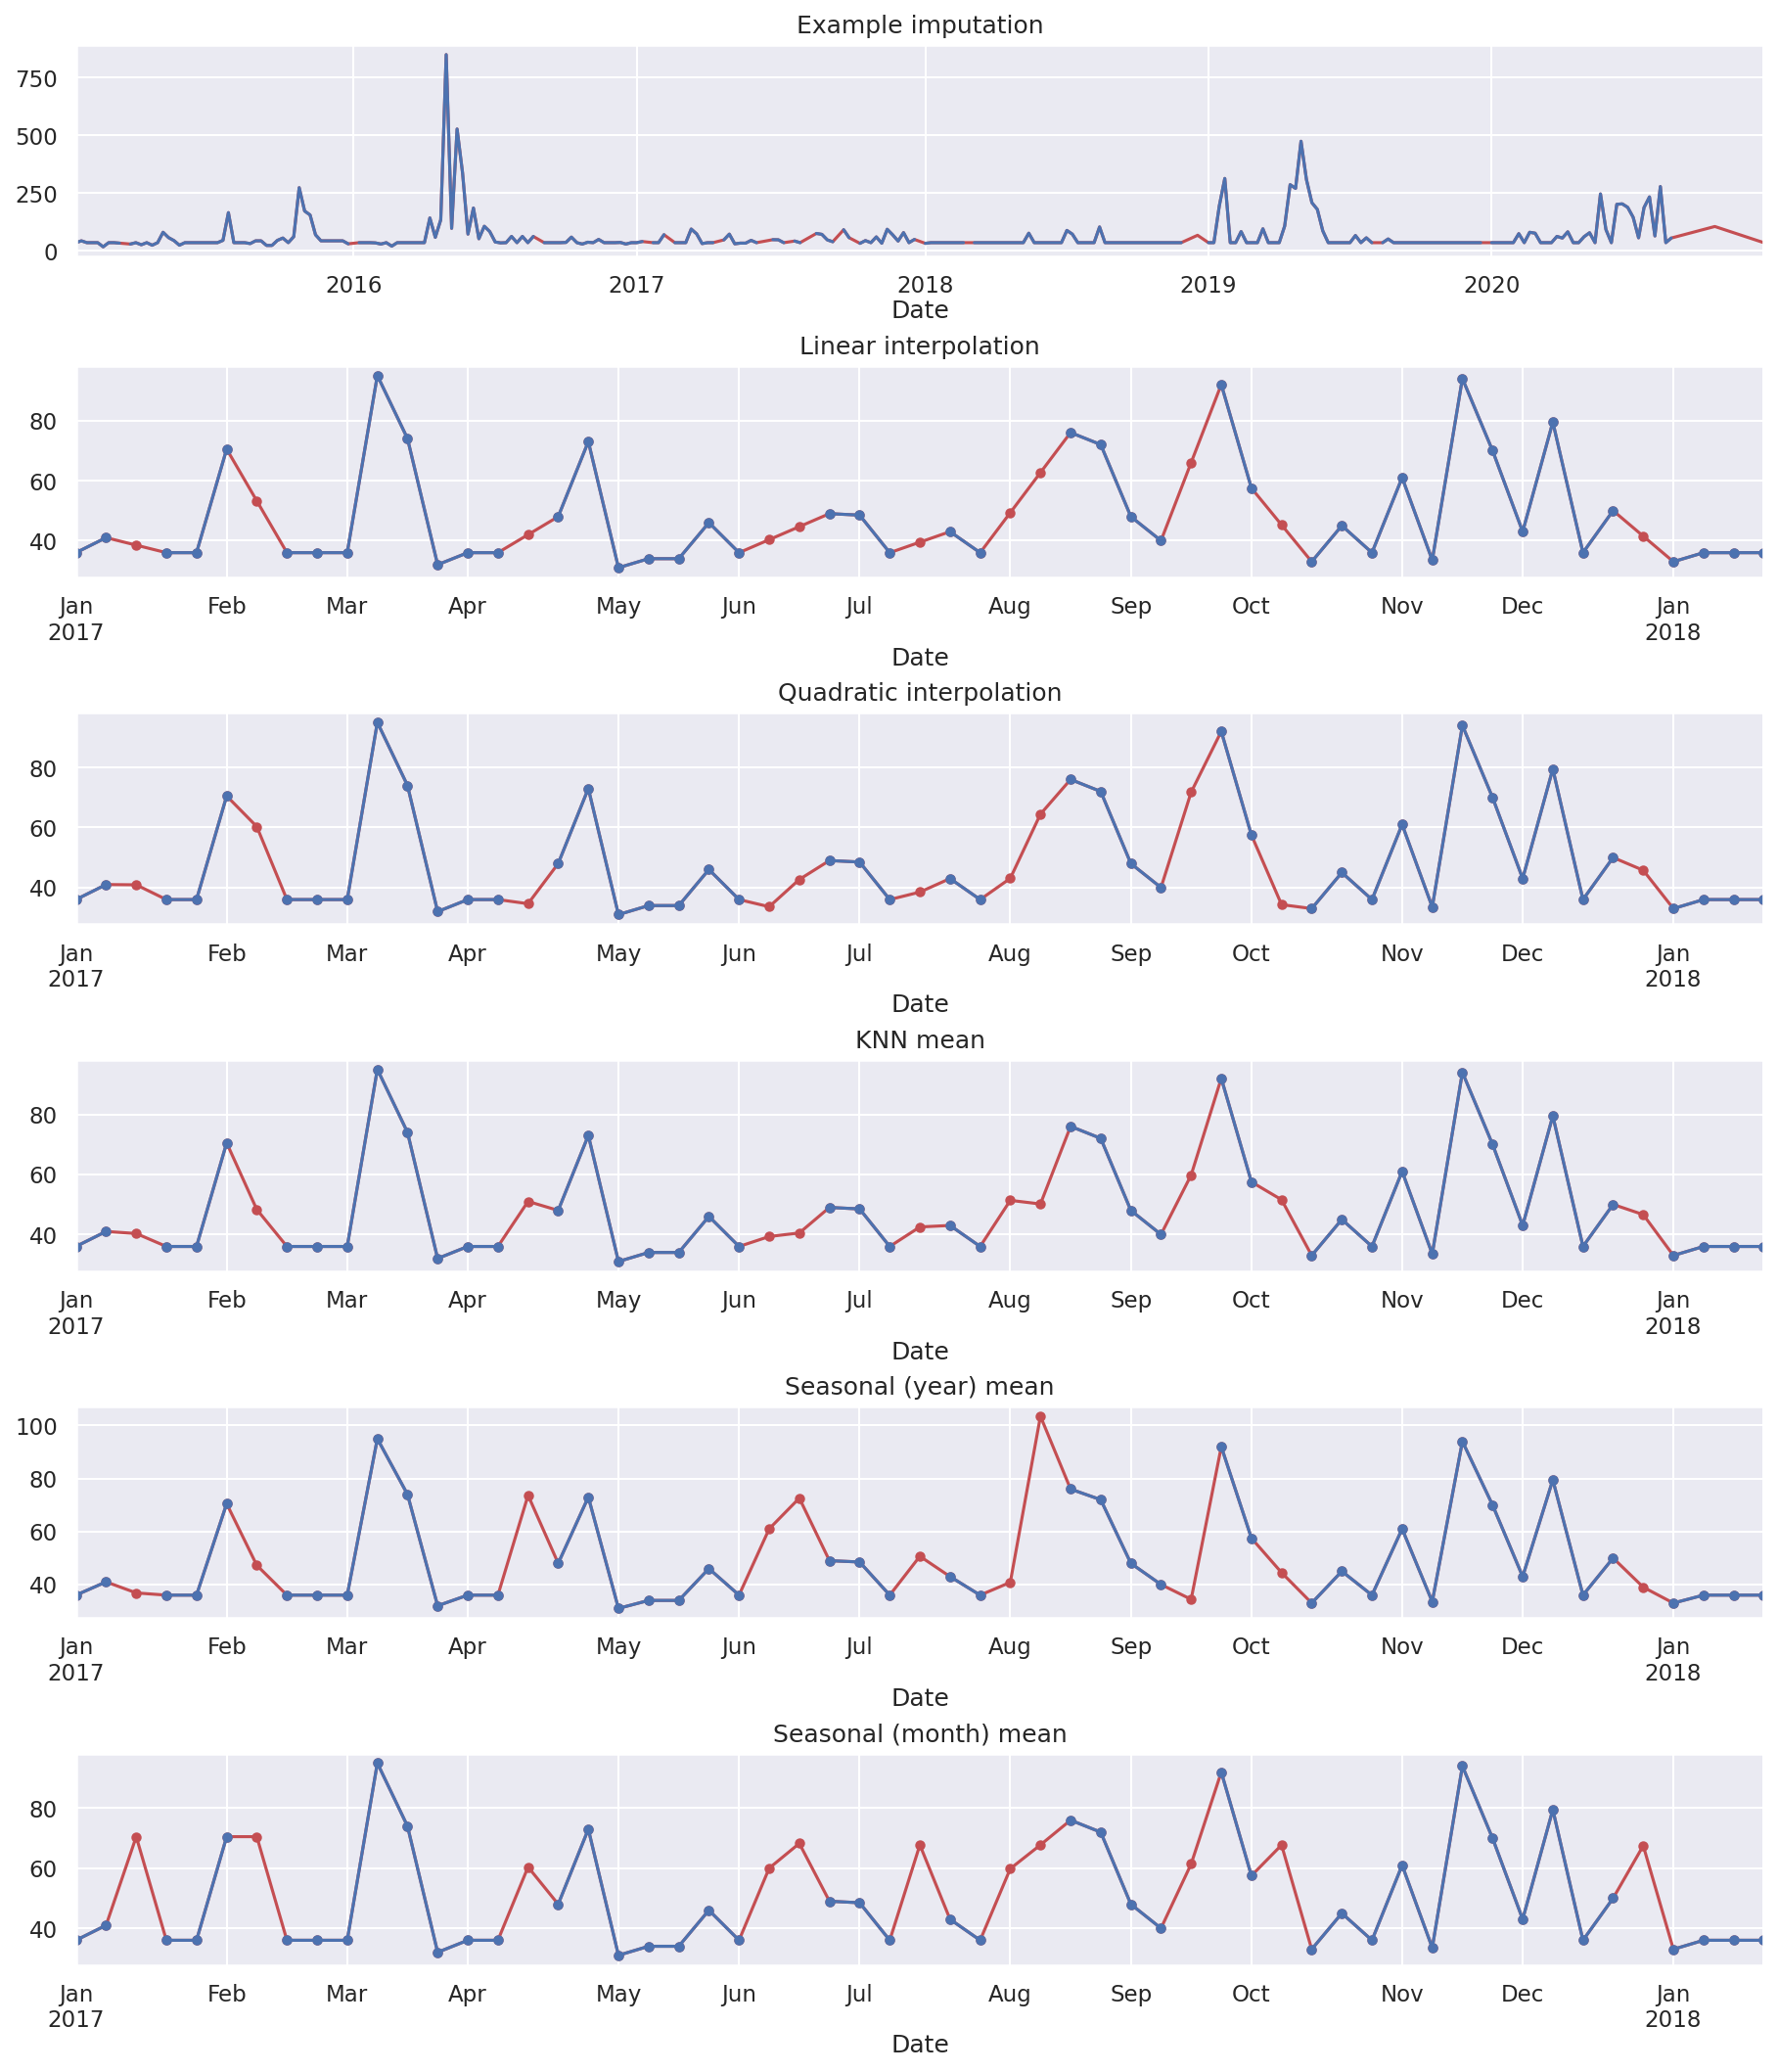

In [10]:
imps = ["linear", "quadratic", "knn", "seasonal_year", "seasonal_month"]
plot_imputations(ts_week, "dsp_toxins", imps, begin="2017", end="2018-01")

## Seasonality

2020 só NaN em Setembro, 1 valor para Outubro, NaN Novembro e 1 Dezembro

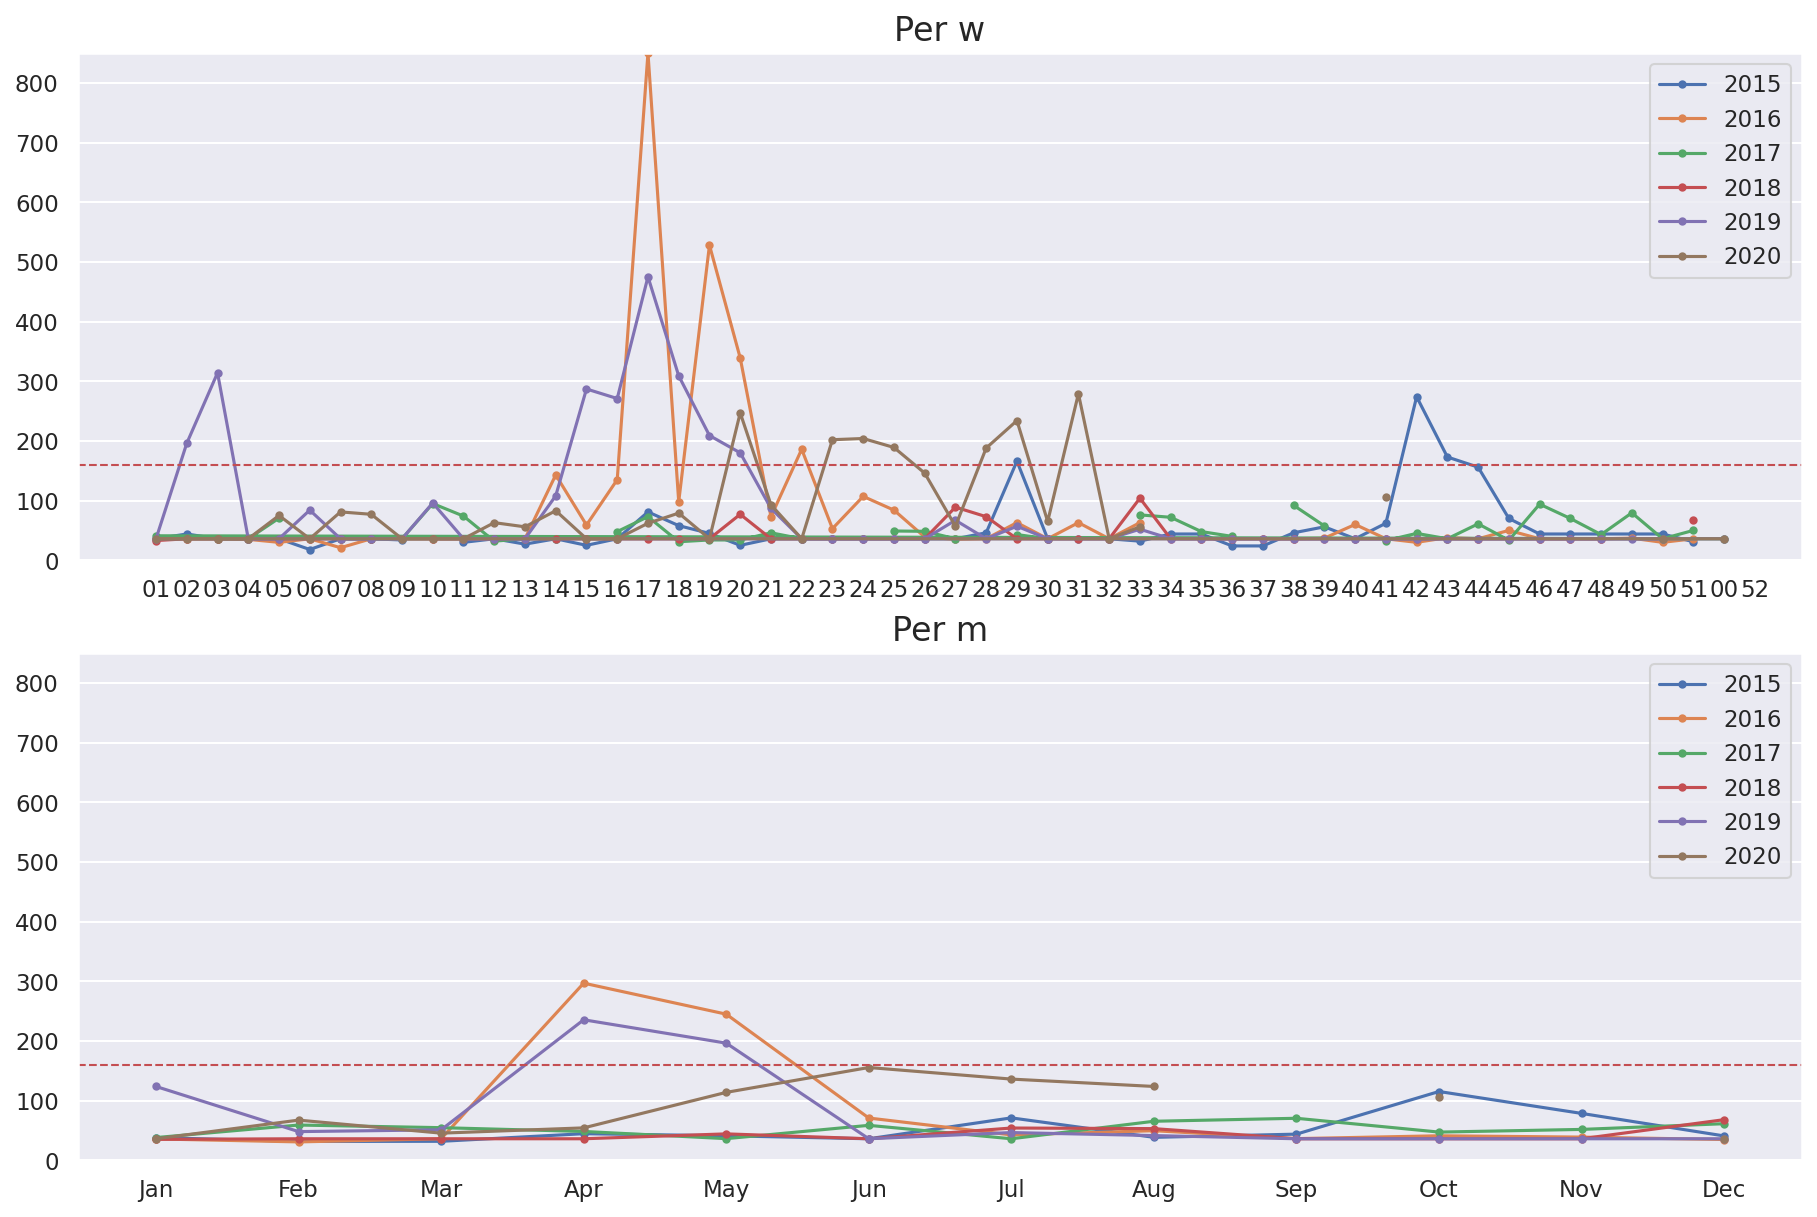

In [11]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

axes[0] = plot_season_per(ts_week, 'w', axes[0])
axes[1] = plot_season_per(ts_month, 'm', axes[1])

axes[0].set_ylim(0,850)
axes[1].set_ylim(0,850)

plt.show()

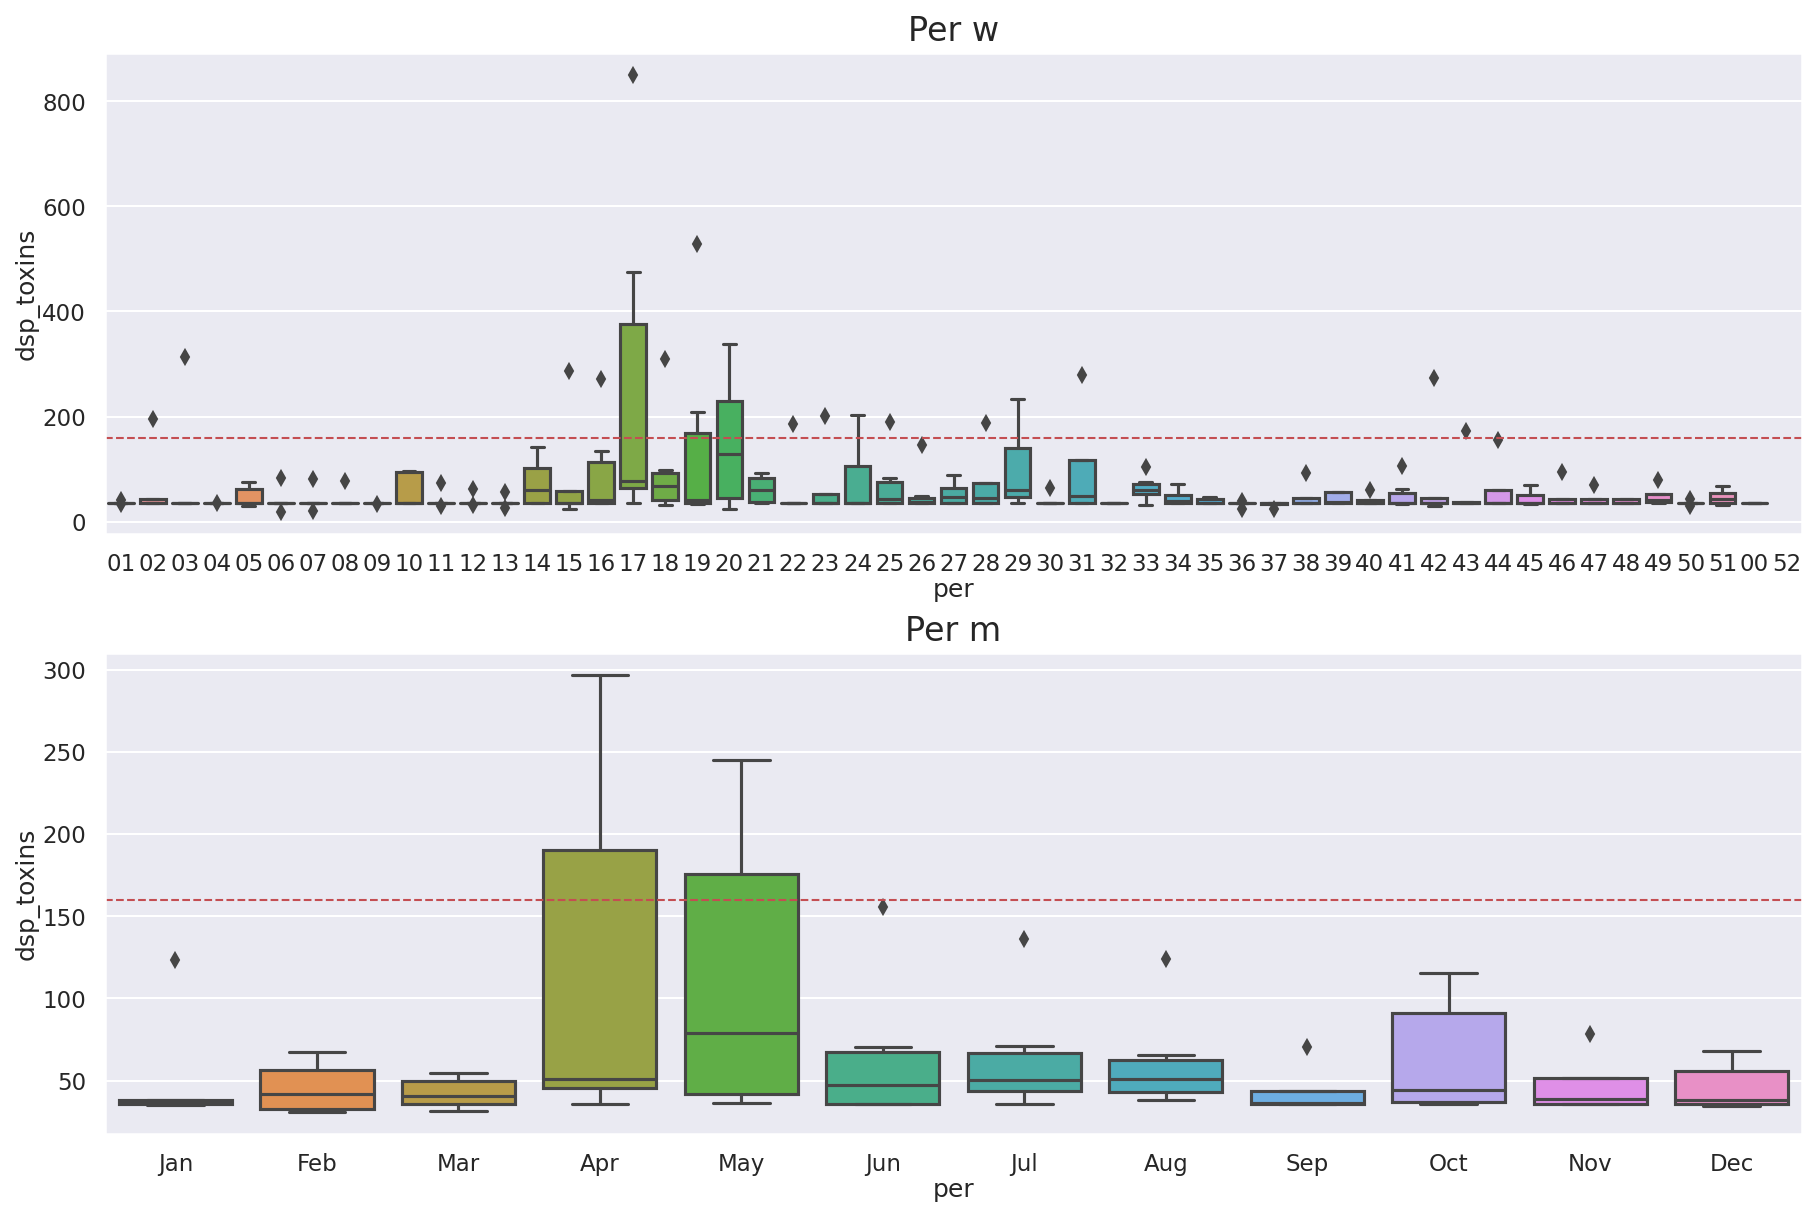

In [12]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

axes[0] = boxplot_season_per(ts_week, 'w', axes[0])
axes[1] = boxplot_season_per(ts_month, 'm', axes[1])
plt.show()

## Trend

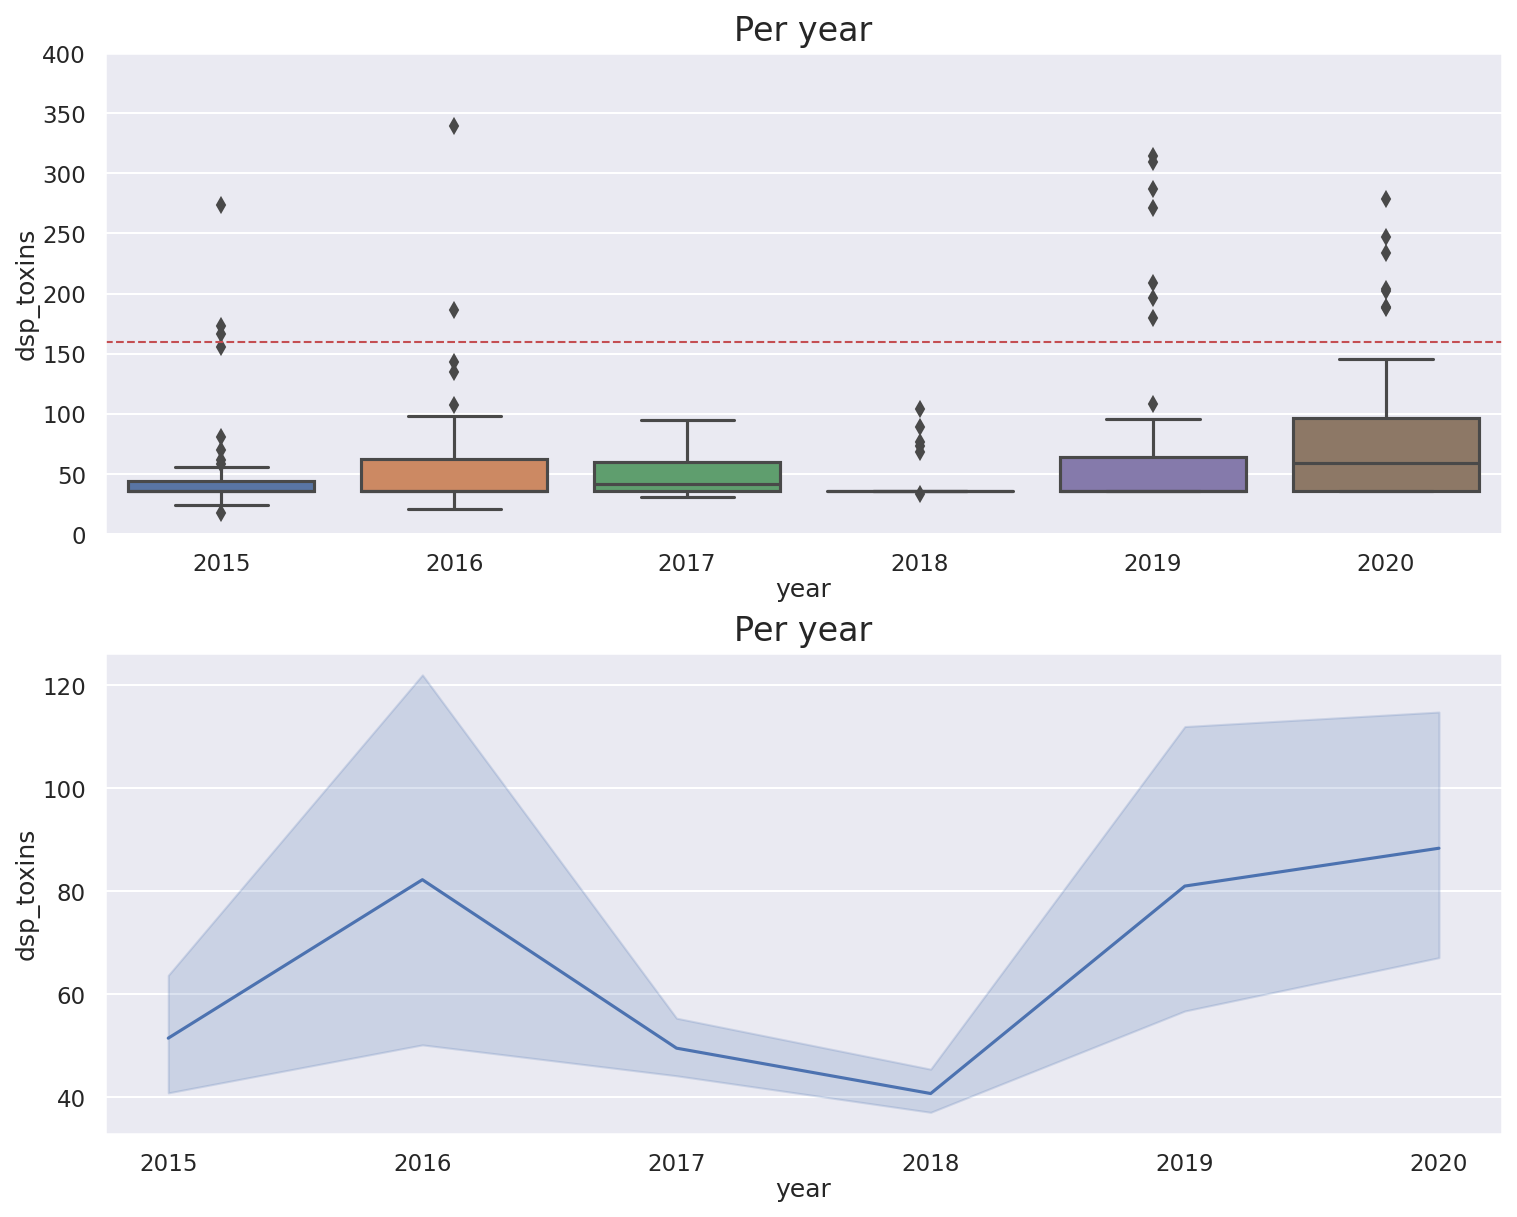

In [13]:
fig, axes = plt.subplots(2,1, figsize=(10,8), constrained_layout=True)

axes[0] = boxplot_trend(ts_week, axes[0])
axes[0].set_ylim(0,400)
axes[1] = plot_trend(ts_week, axes[1])


## Decomposition

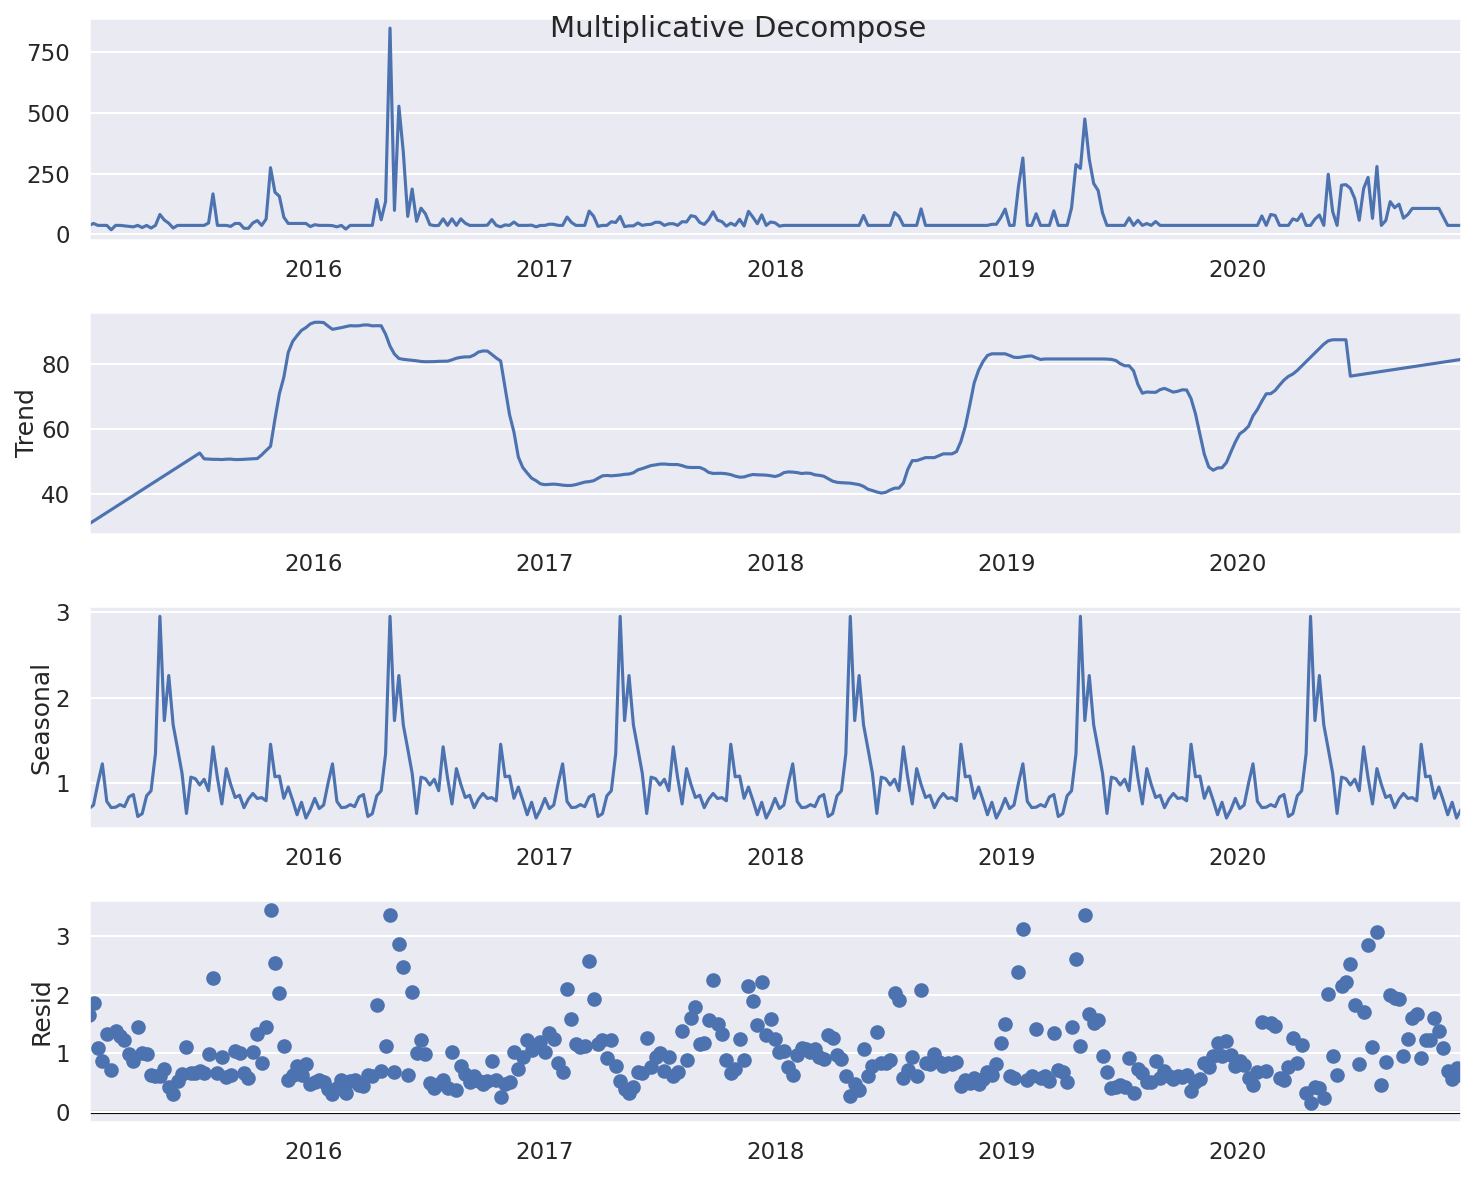

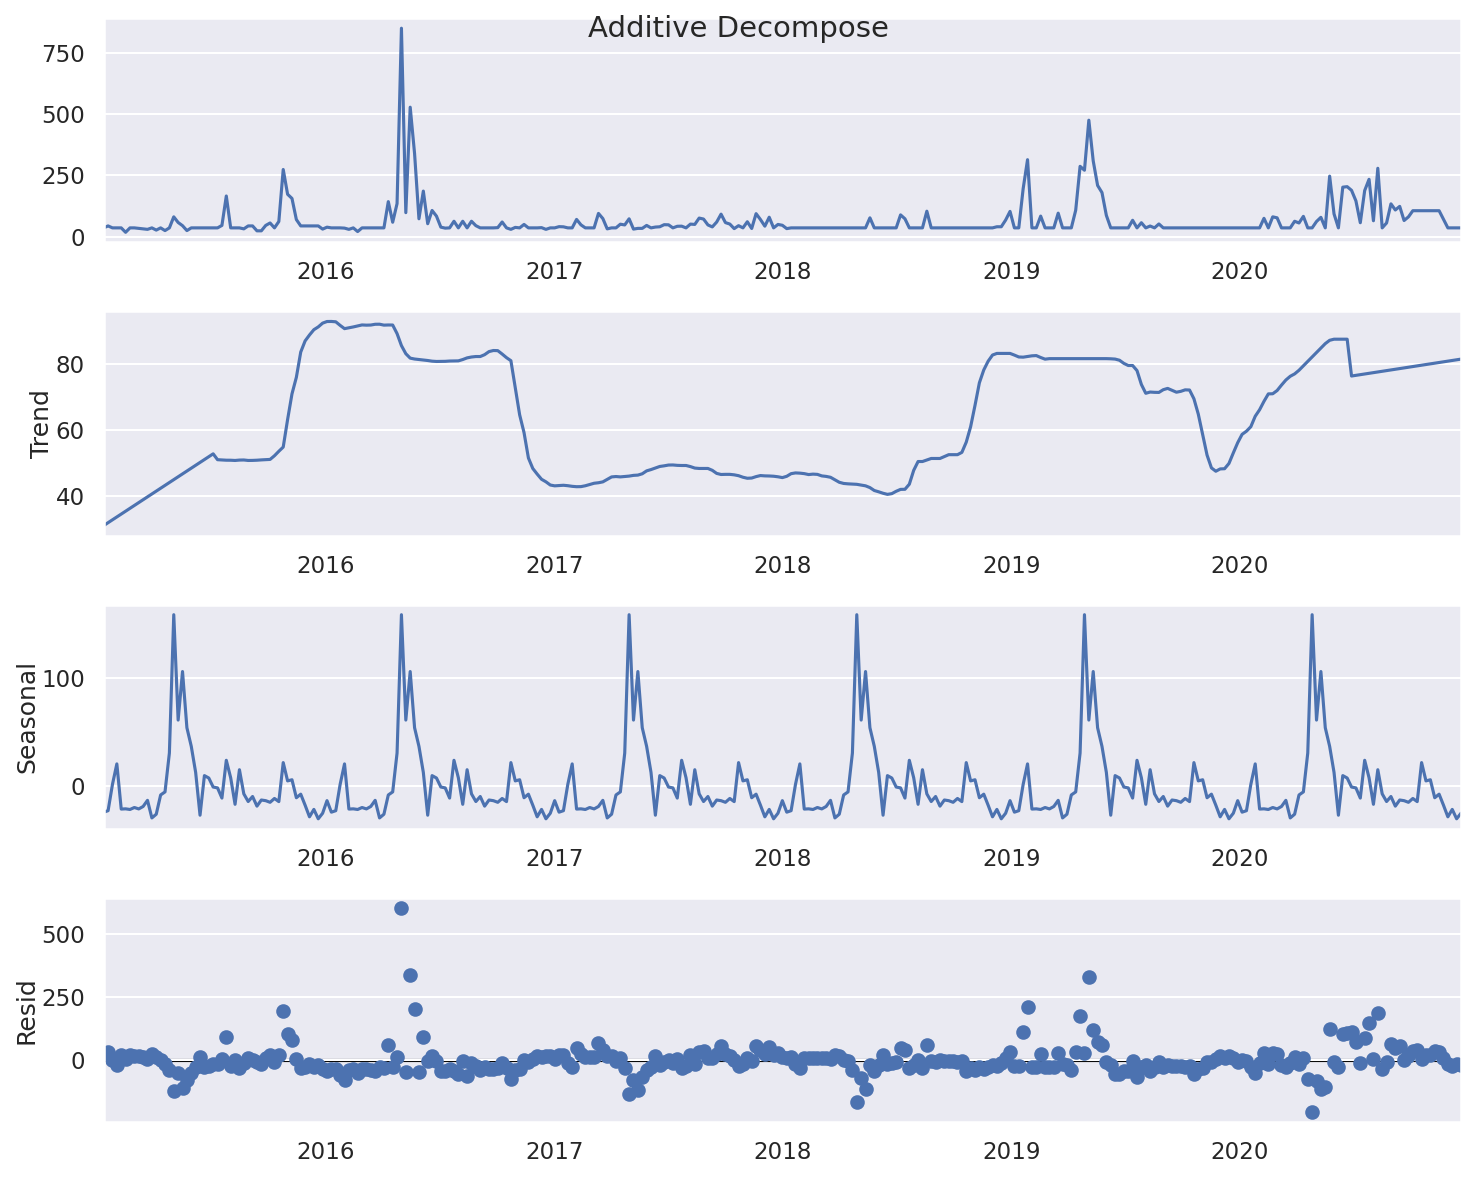

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

ts_week_processed = pd.Series(data=knn_mean(ts_week["dsp_toxins"], 10), index=ts_week["dsp_toxins"].index)

decompose(ts_week_processed)

# RIAV1 (Ria de Aveiro)

In [15]:
area = "RIAV1"
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Berbigão                  308
Mexilhão                  293
Amêijoa-macha              90
Longueirão                 73
Amêijoa-japonesa           66
Amêijoa-boa                59
Ostra-japonesa/gigante     40
Ostra                       1
Name: Species, dtype: int64

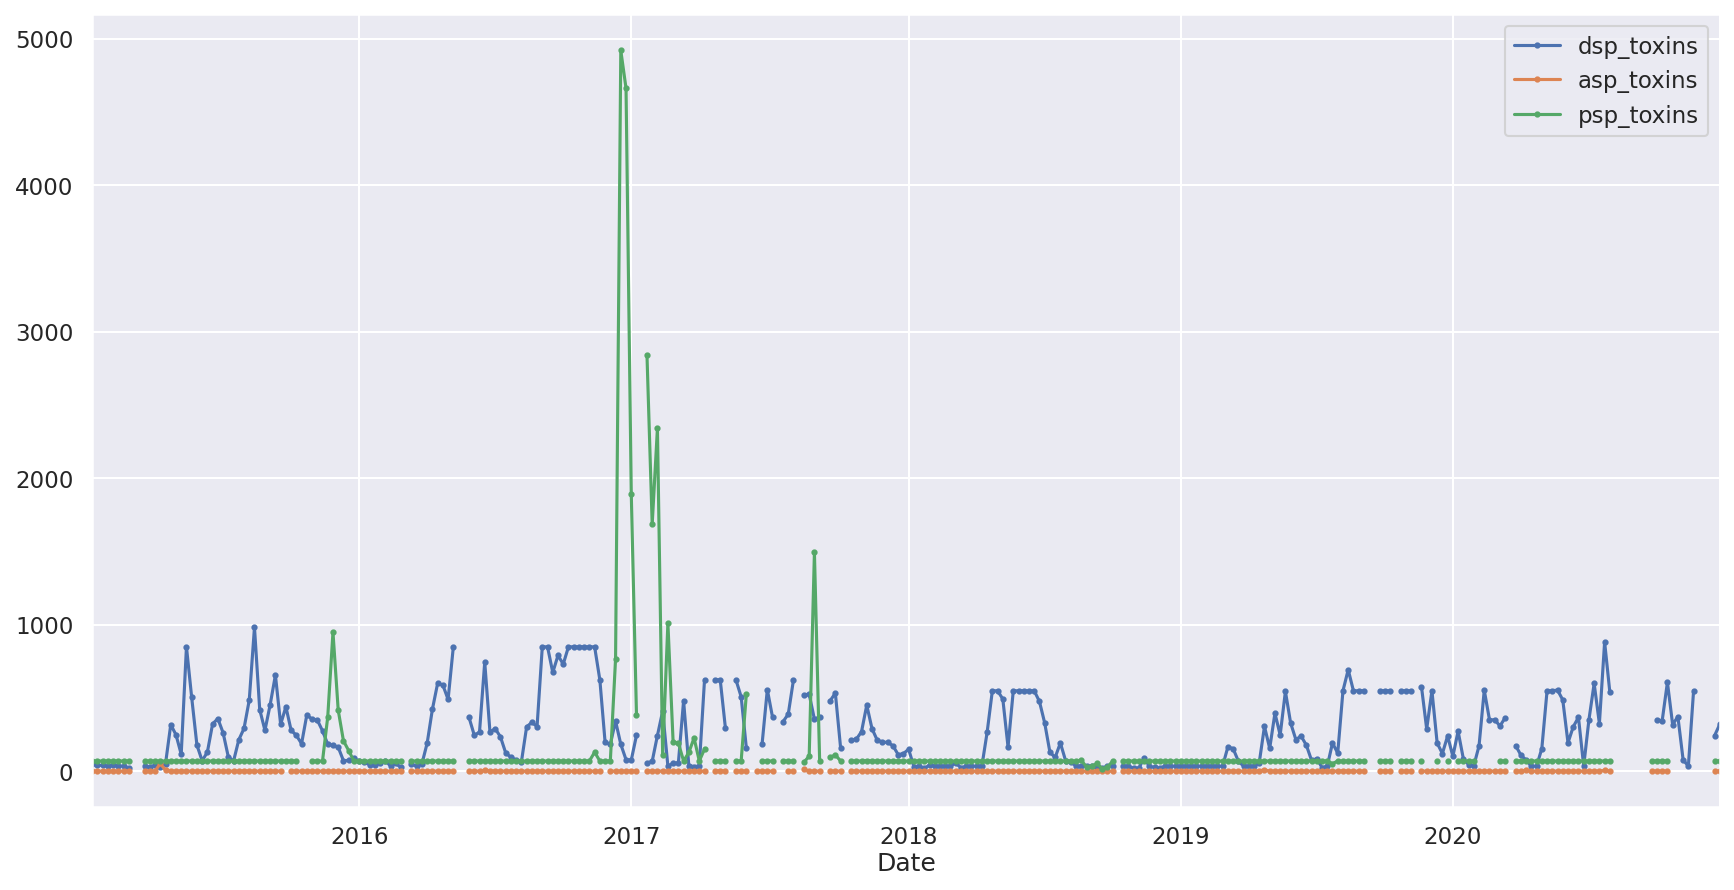

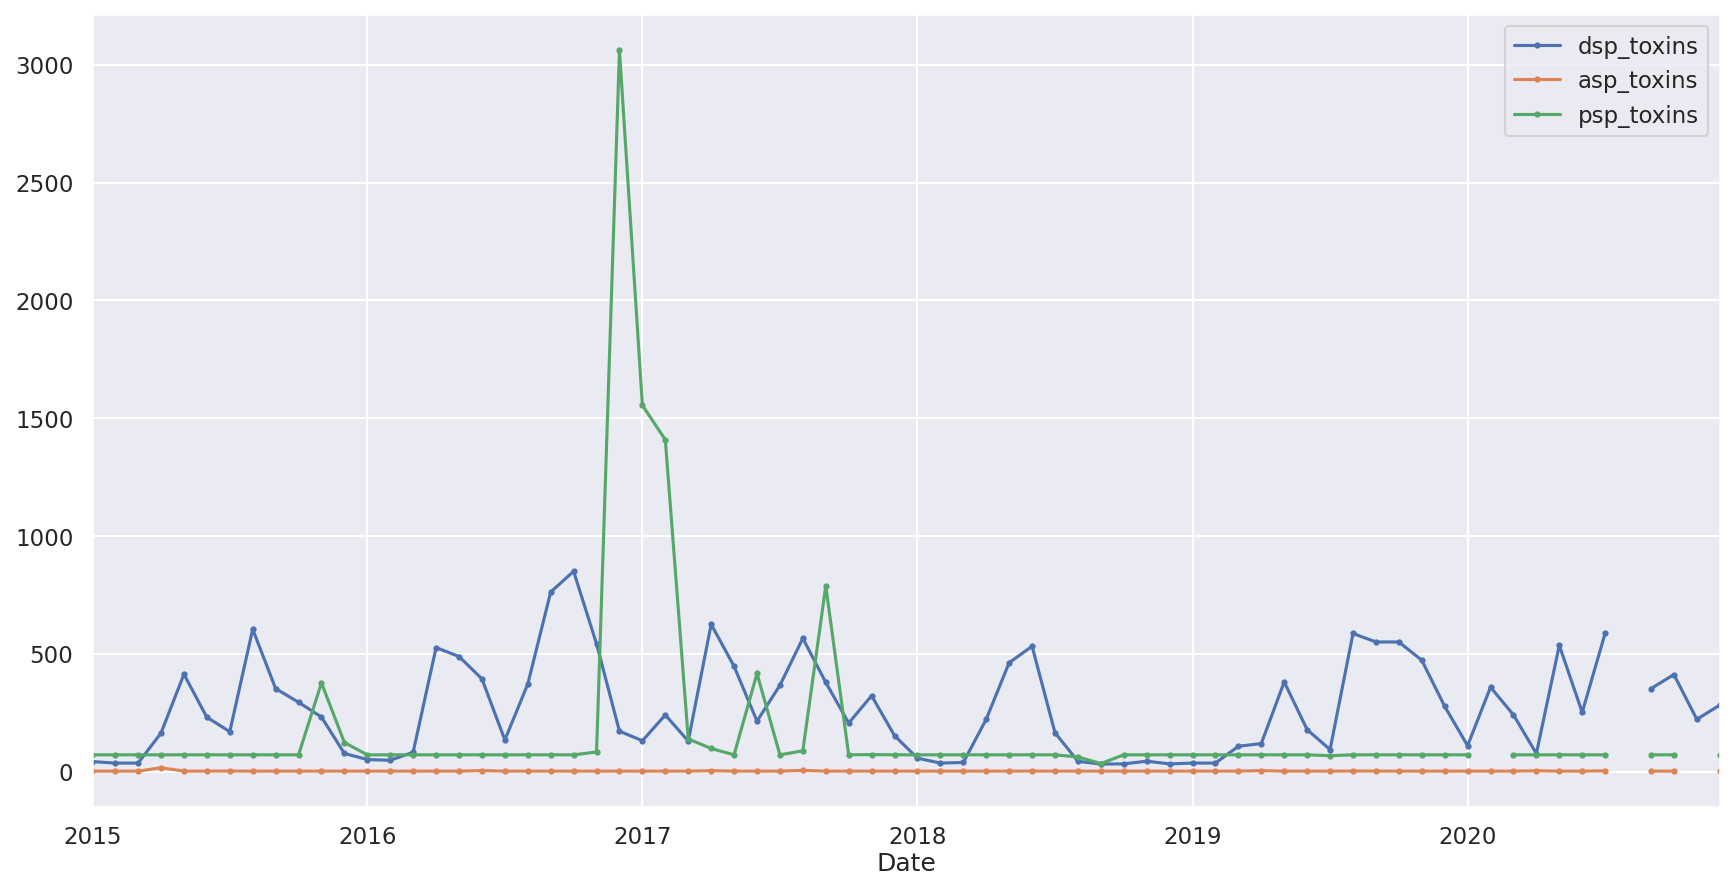

In [16]:
ts_week = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

Quando interpolado usando **week** a data representa o fim da semana

## Imputation

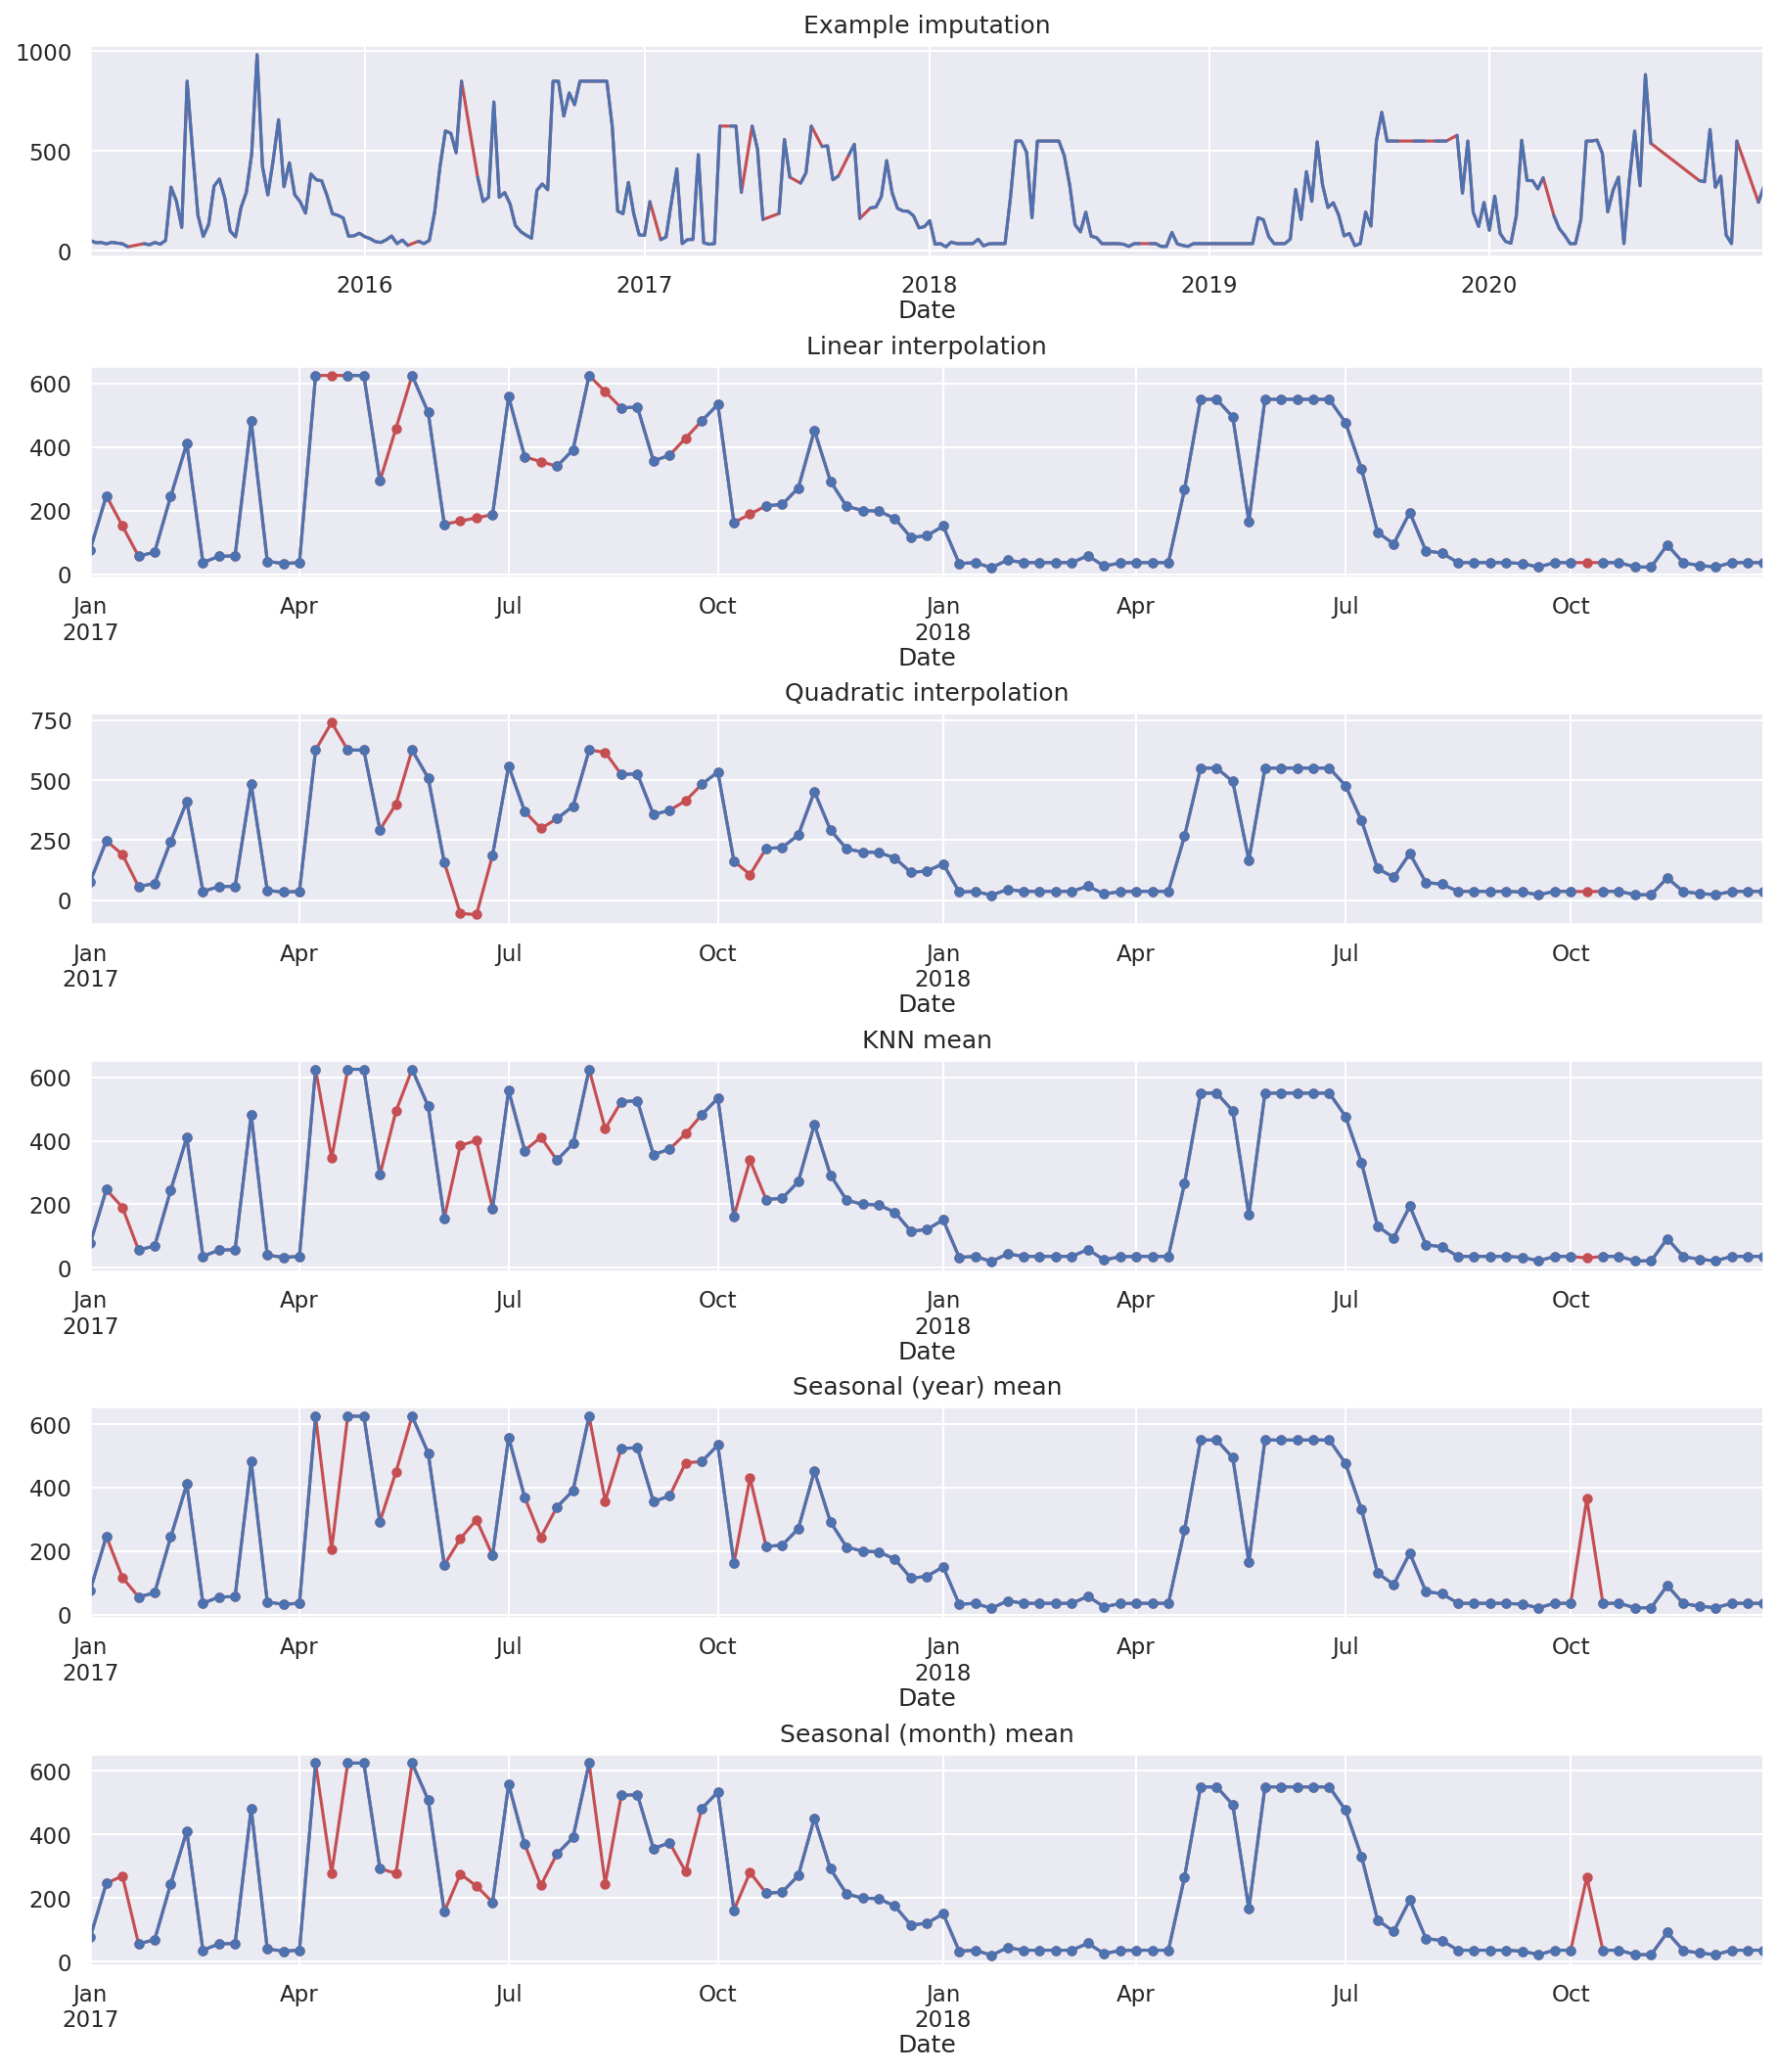

In [17]:
imps = ["linear", "quadratic", "knn", "seasonal_year", "seasonal_month"]
plot_imputations(ts_week, "dsp_toxins", imps, begin="2017", end="2018")

## Seasonality

2020 só NaN em Setembro, 1 valor para Outubro, NaN Novembro e 1 Dezembro

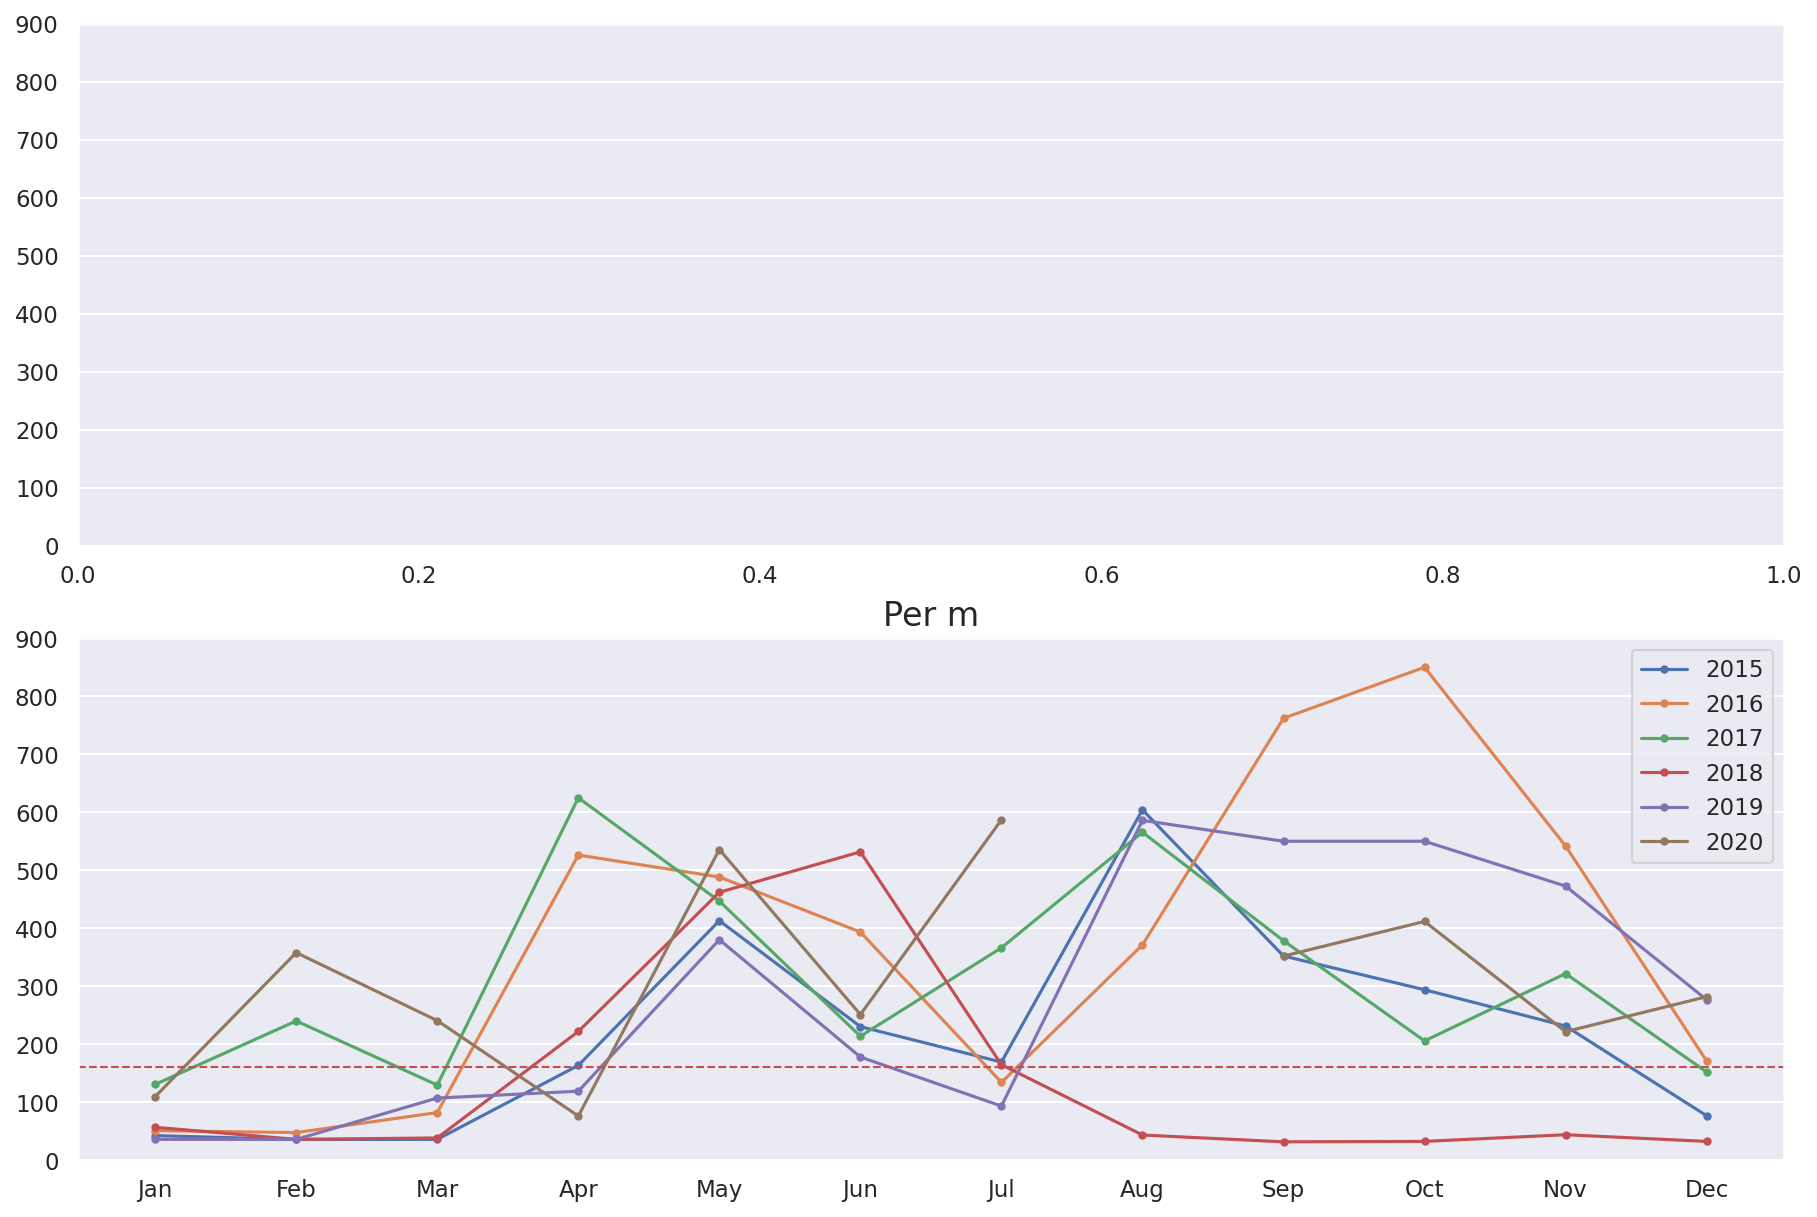

In [18]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

#axes[0] = plot_season_per(ts_week, 'w', axes[0])
axes[1] = plot_season_per(ts_month, 'm', axes[1])

axes[0].set_ylim(0,900)
axes[1].set_ylim(0,900)

plt.show()

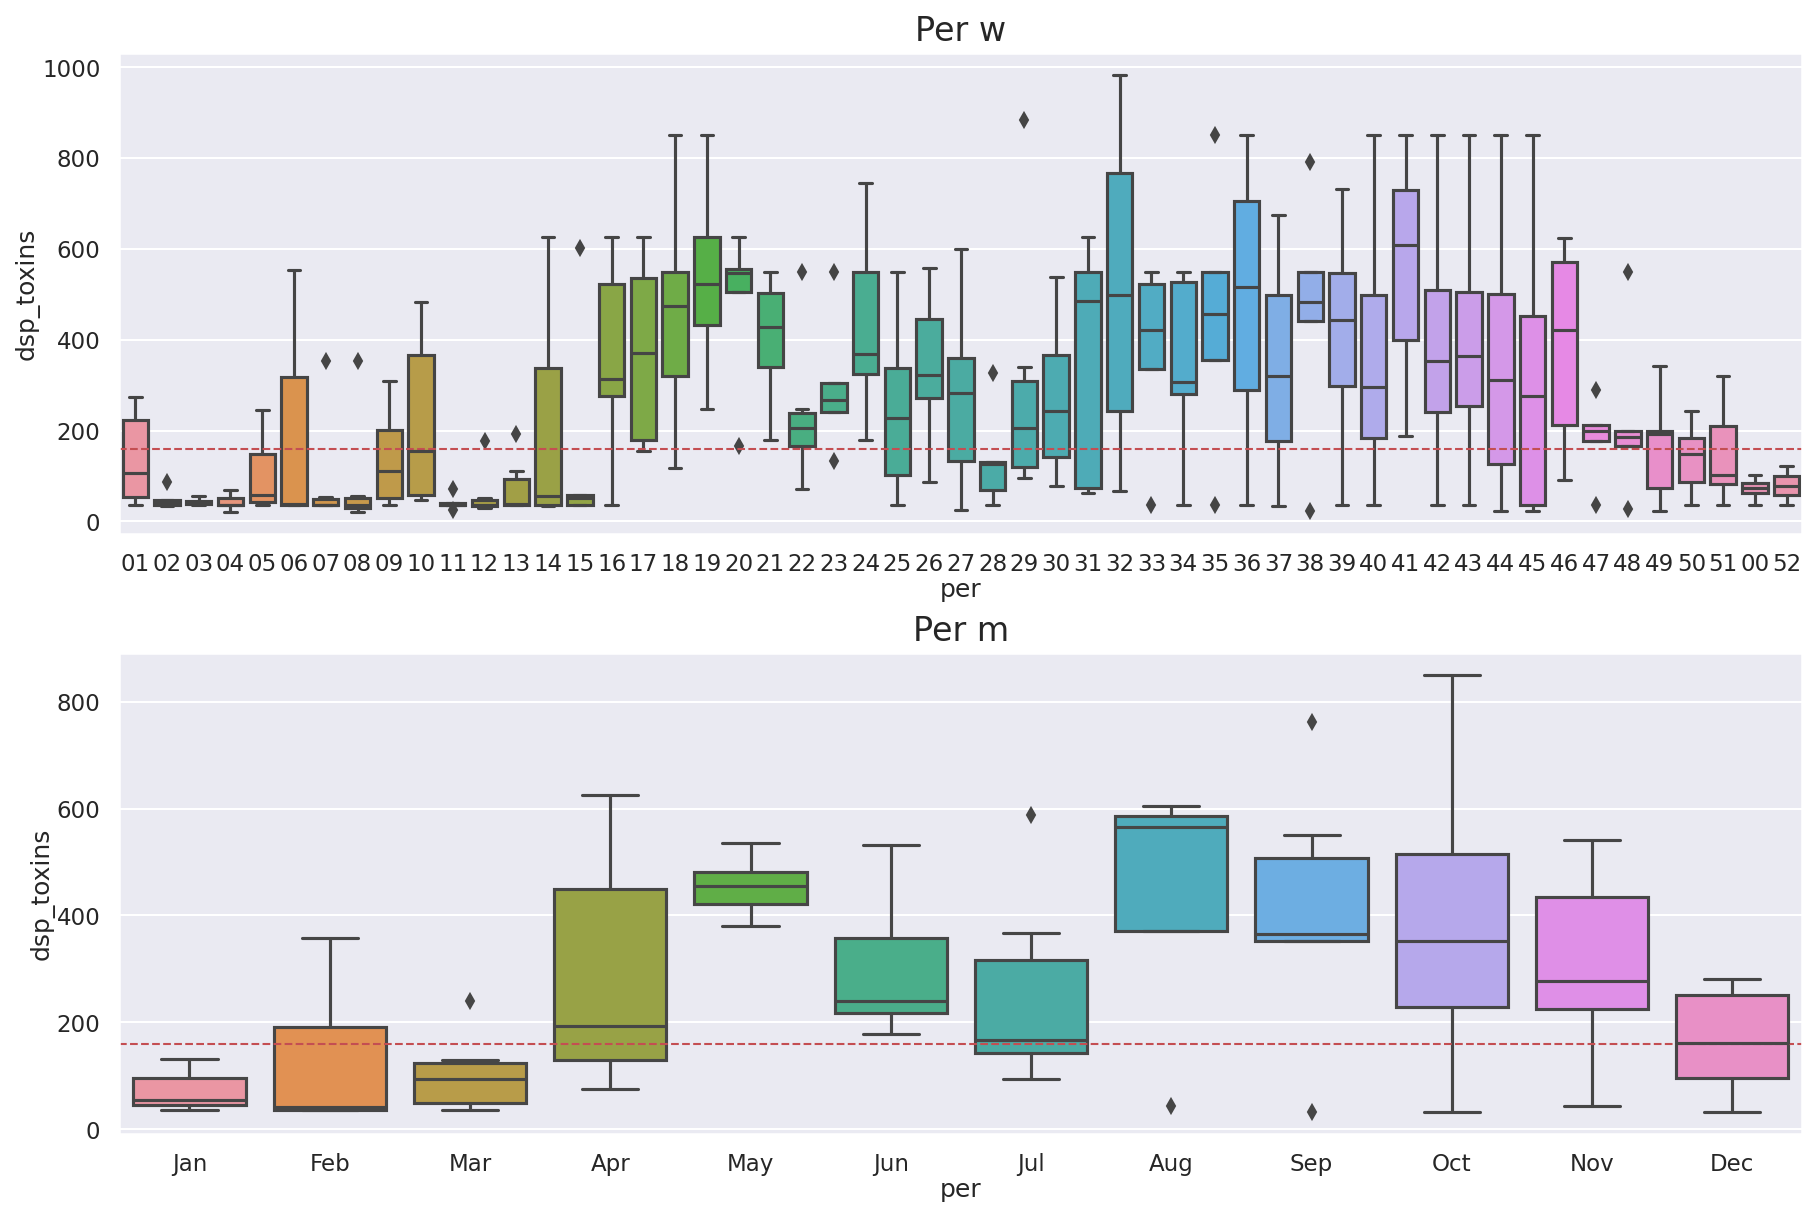

In [19]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

axes[0] = boxplot_season_per(ts_week, 'w', axes[0])
axes[1] = boxplot_season_per(ts_month, 'm', axes[1])
plt.show()

## Trend

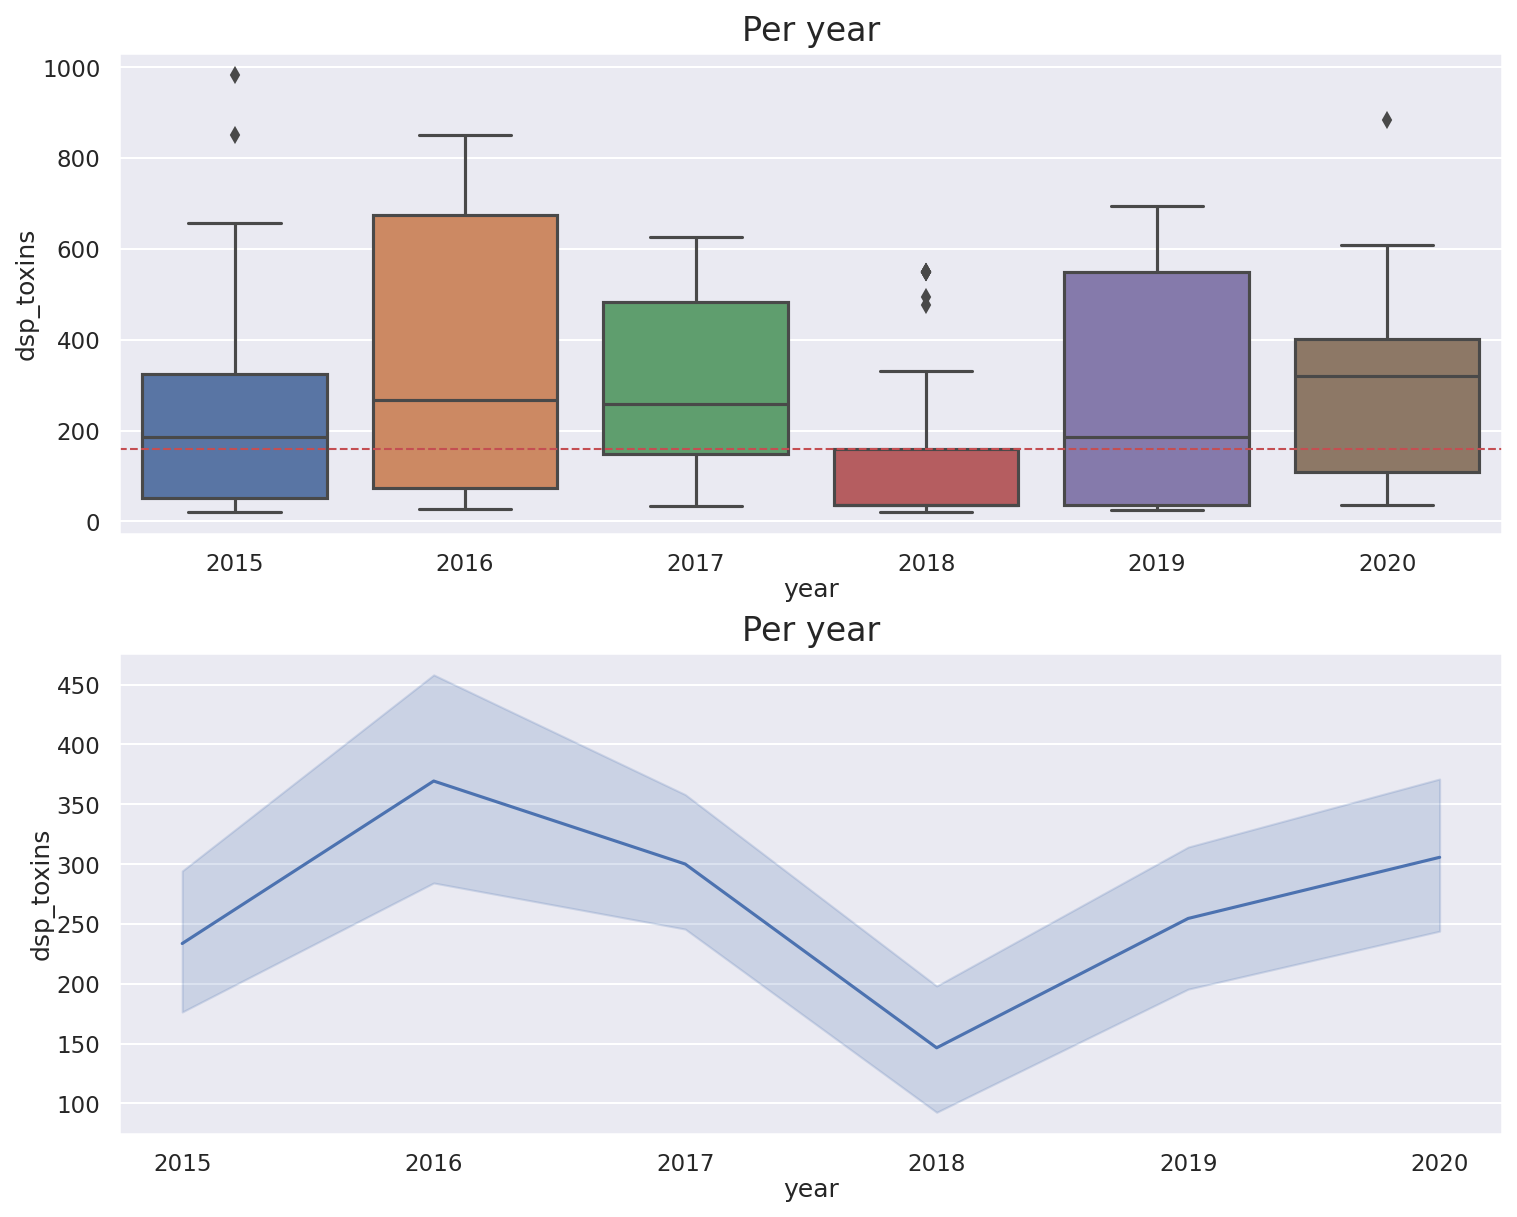

In [24]:
fig, axes = plt.subplots(2,1, figsize=(10,8), constrained_layout=True)

axes[0] = boxplot_trend(ts_week, axes[0])
#axes[0].set_ylim(0,1000)
axes[1] = plot_trend(ts_week, axes[1])


## Decomposition

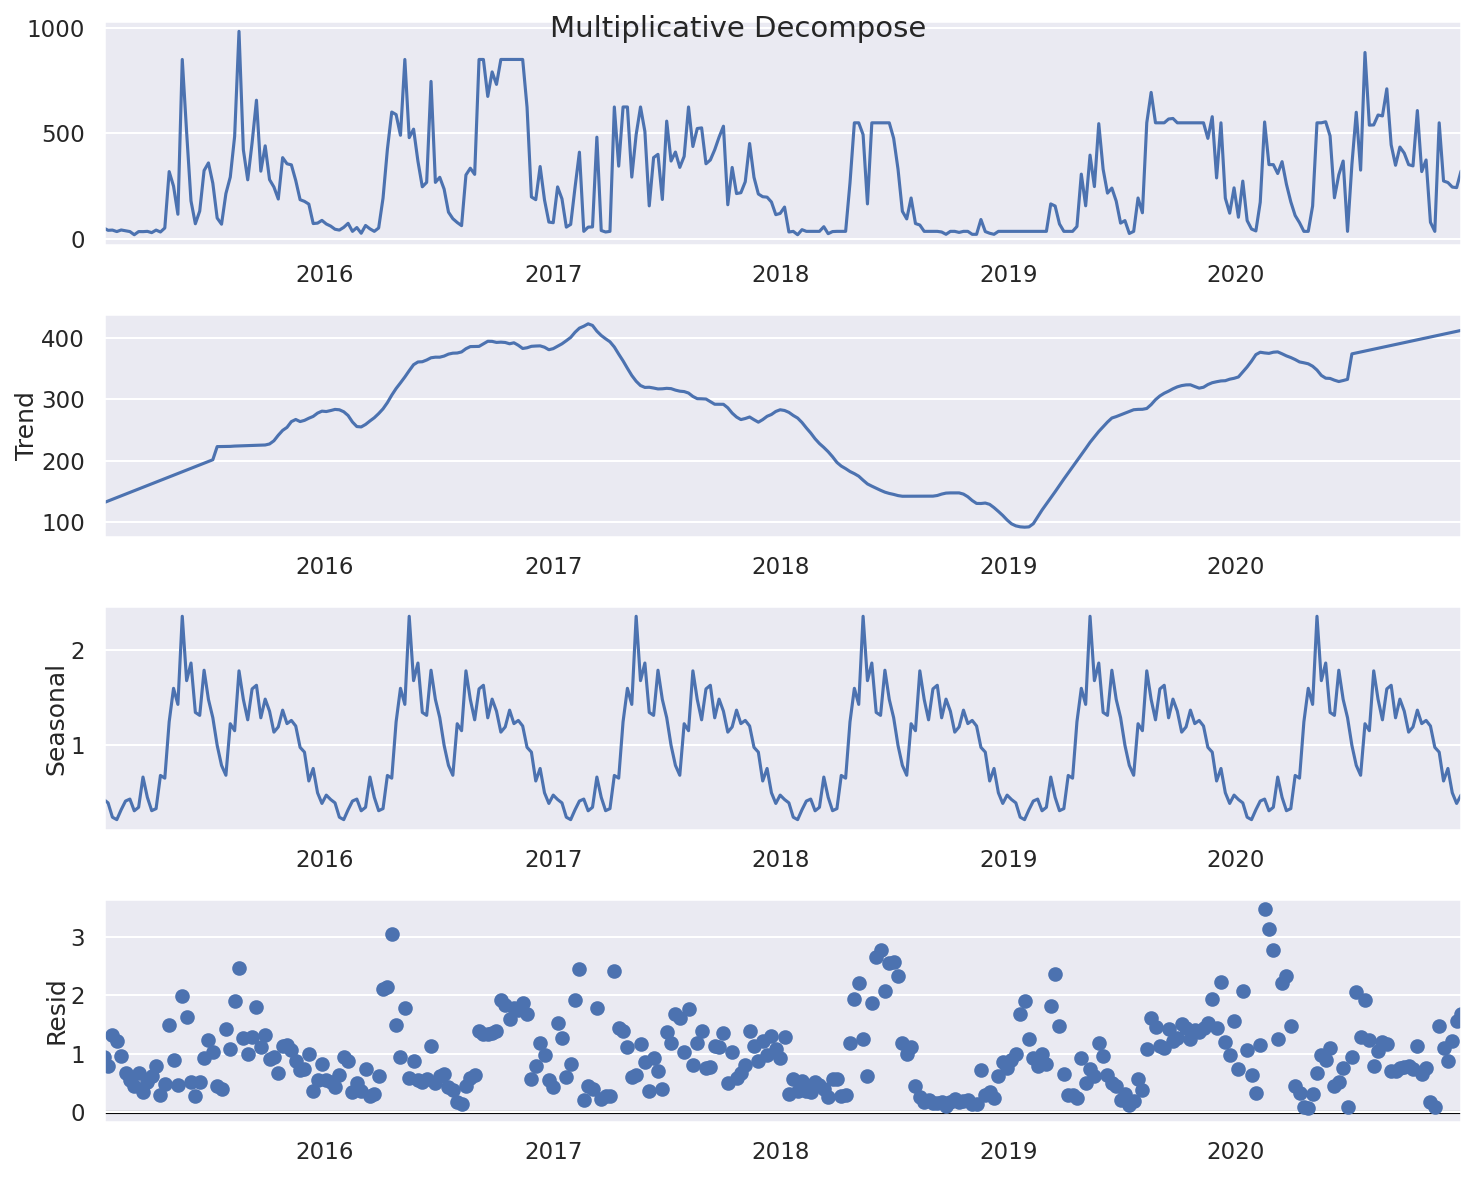

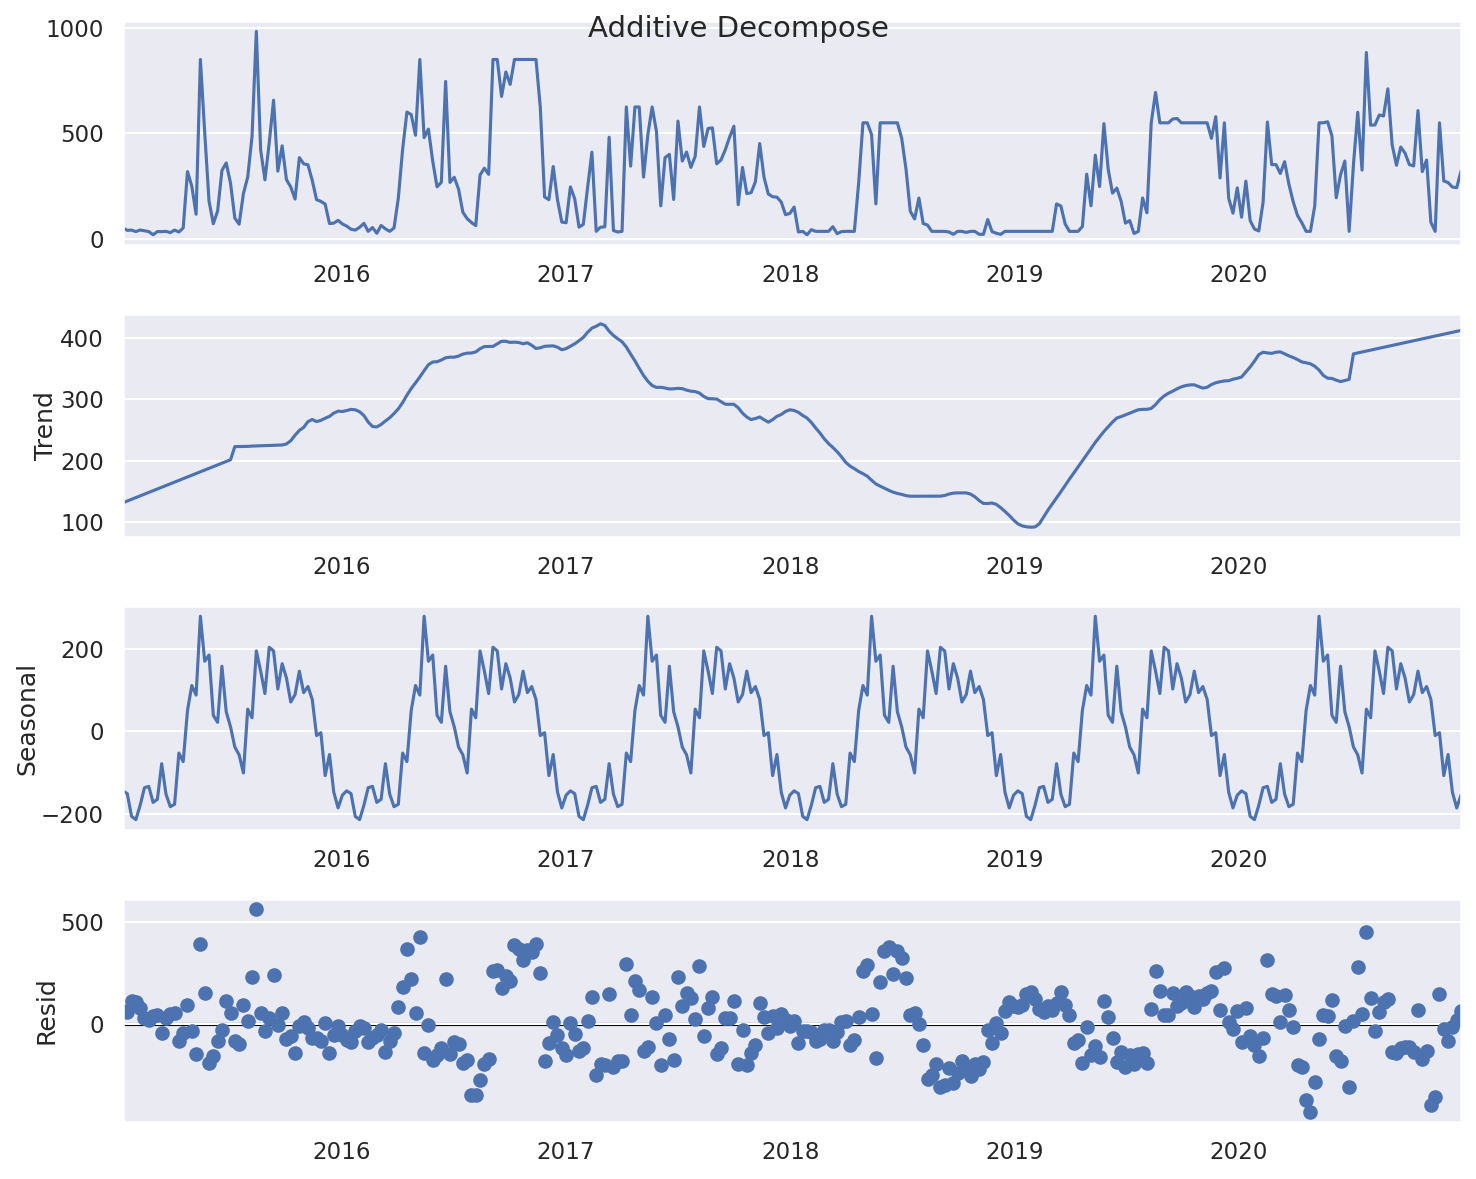

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

ts_week_processed = pd.Series(data=knn_mean(ts_week["dsp_toxins"], 10), index=ts_week["dsp_toxins"].index)

decompose(ts_week_processed)

# L5b (Litoral Cabo Raso/Saída do Tejo)

In [10]:
area = "L5b"
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Mexilhão          282
Conquilha          92
Longueirão         55
Amêijoa-branca      3
Name: Species, dtype: int64

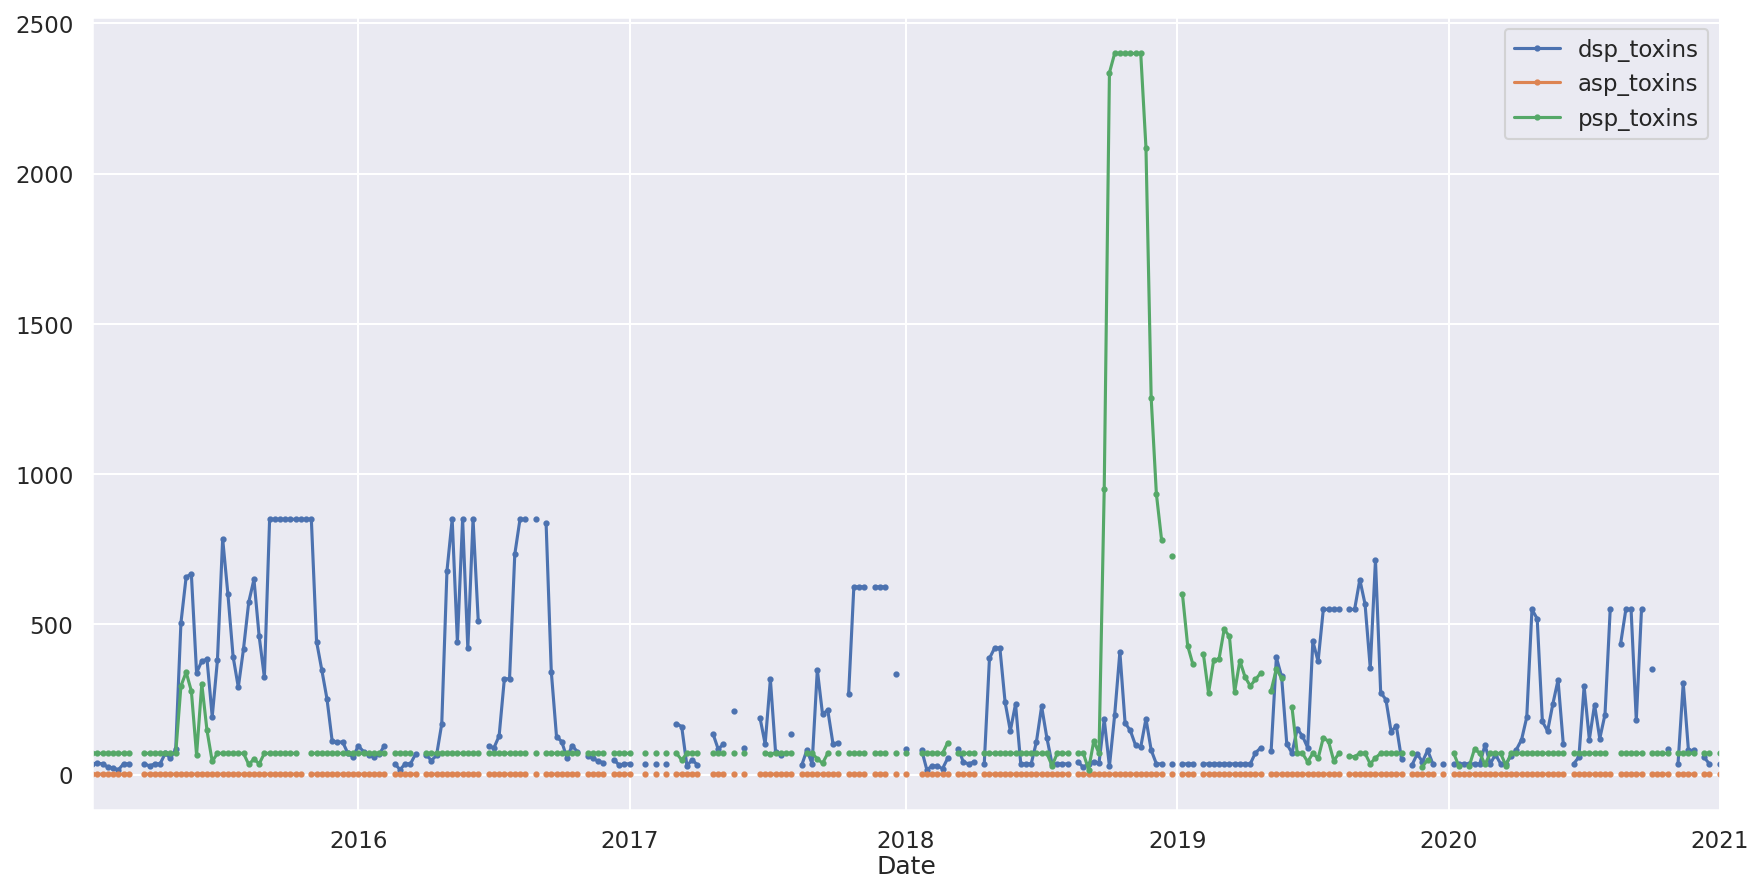

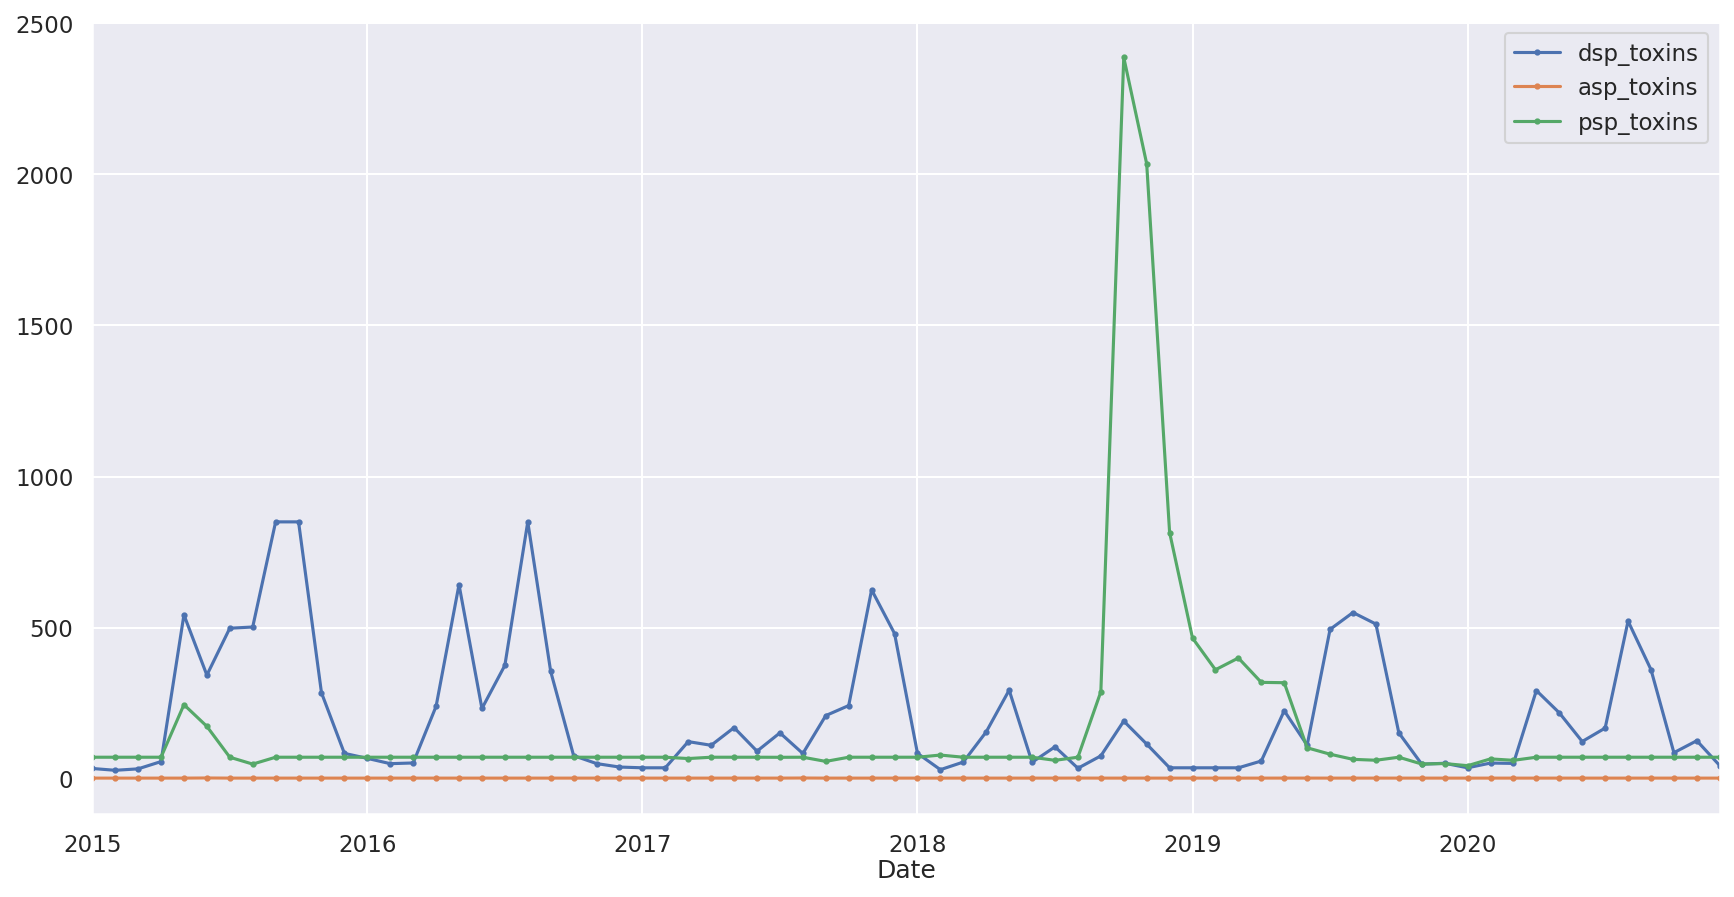

In [11]:
ts_week = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

Quando interpolado usando **week** a data representa o fim da semana

## Imputation

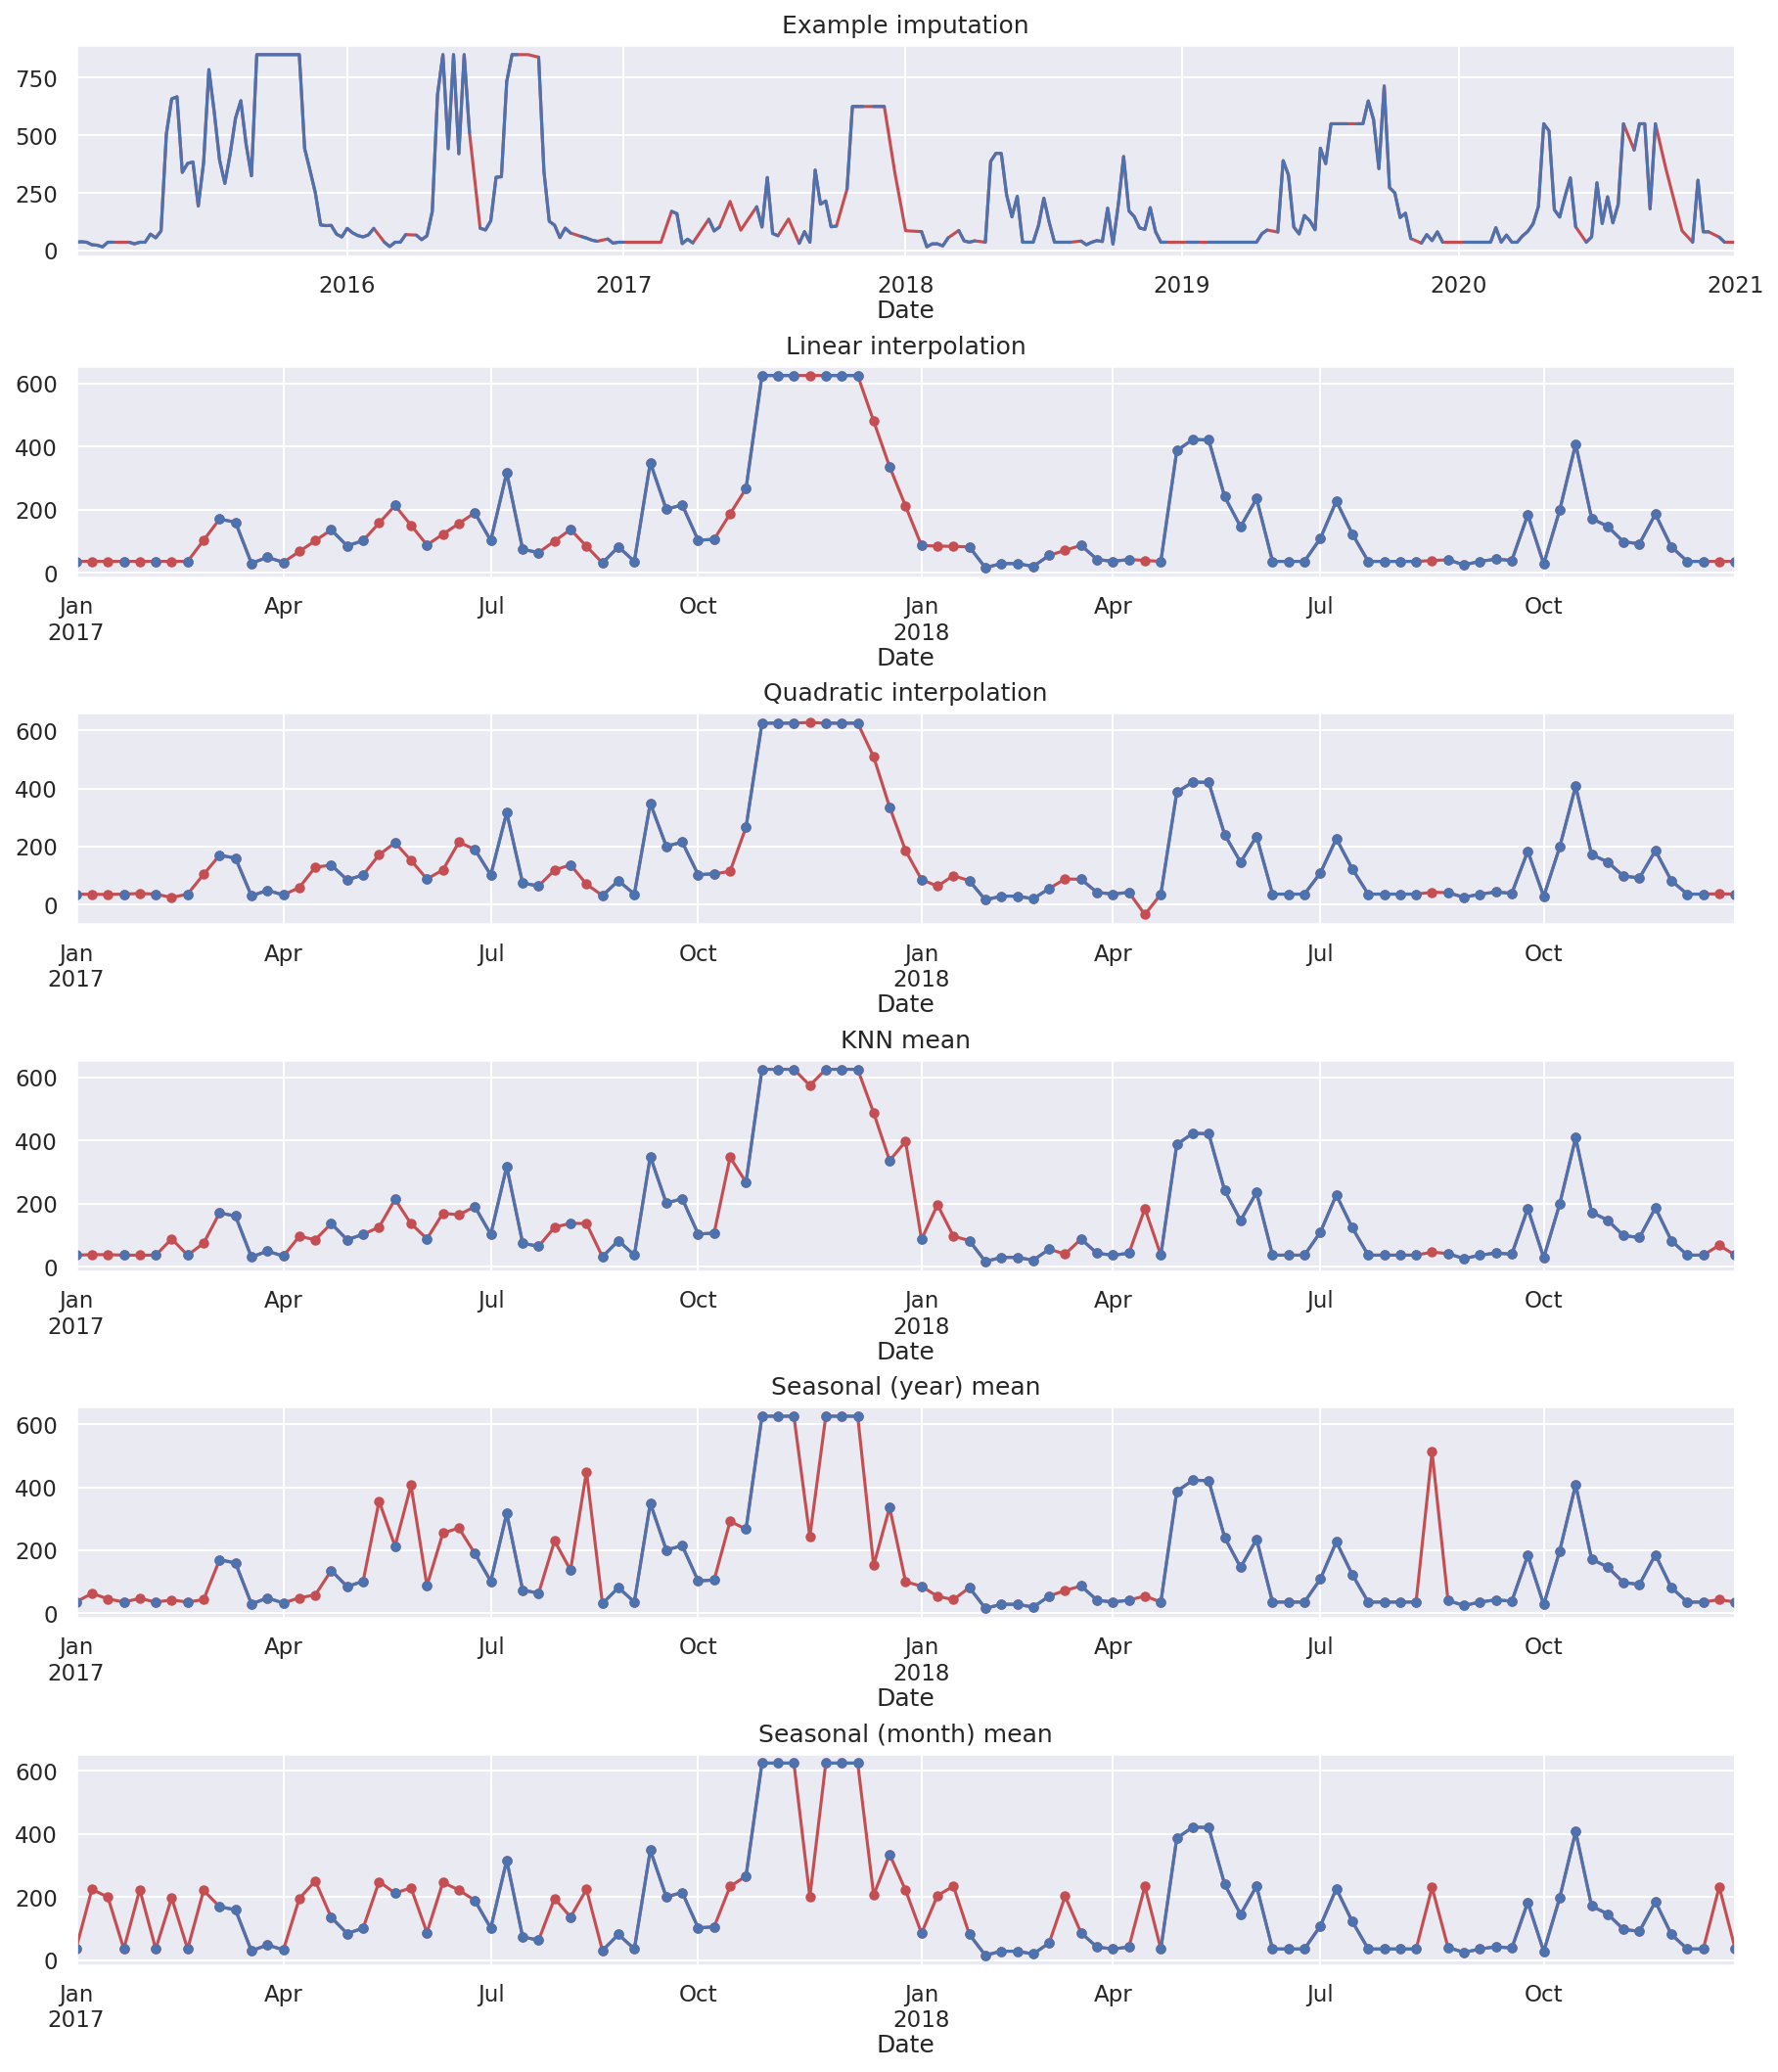

In [12]:
imps = ["linear", "quadratic", "knn", "seasonal_year", "seasonal_month"]
plot_imputations(ts_week, "dsp_toxins", imps, begin="2017", end="2018")

## Seasonality

2020 só NaN em Setembro, 1 valor para Outubro, NaN Novembro e 1 Dezembro

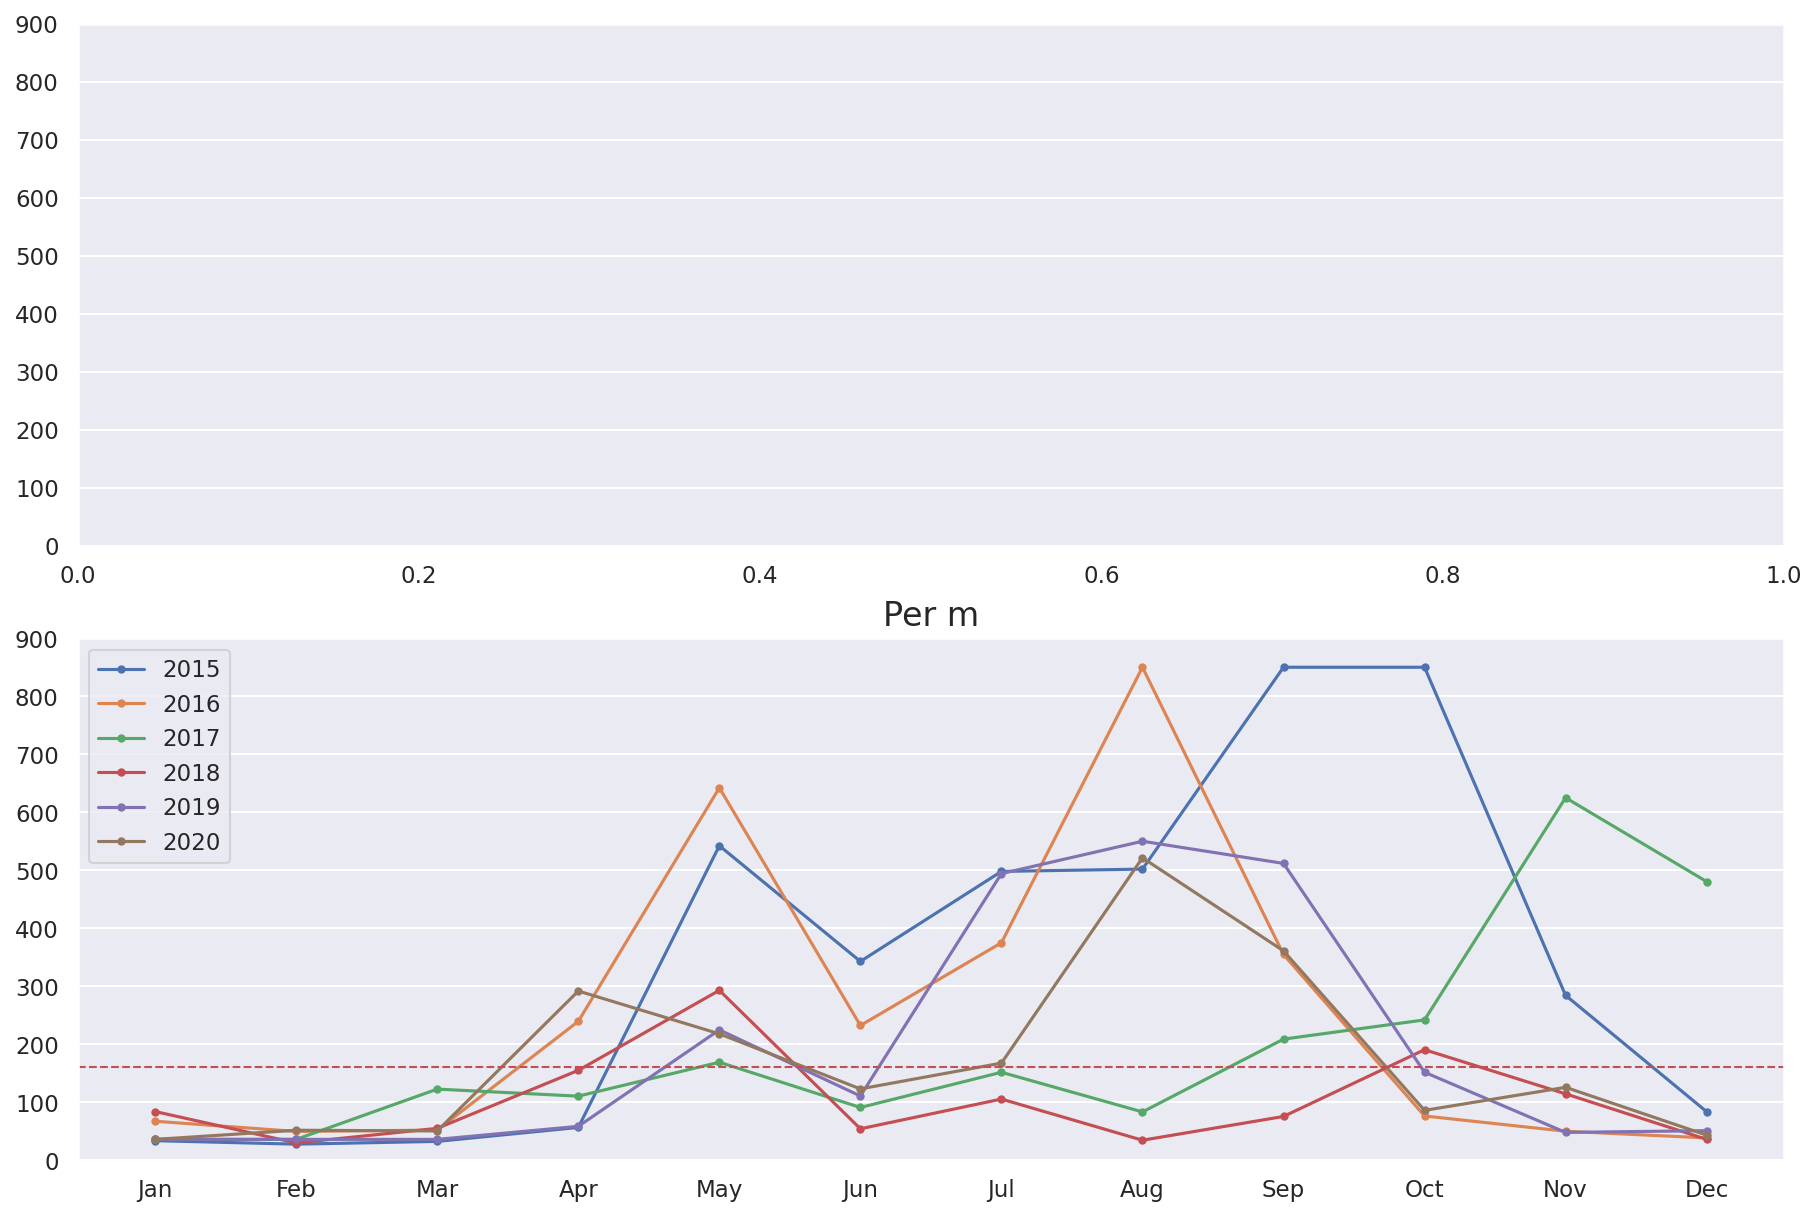

In [13]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

#axes[0] = plot_season_per(ts_week, 'w', axes[0])
axes[1] = plot_season_per(ts_month, 'm', axes[1])

axes[0].set_ylim(0,900)
axes[1].set_ylim(0,900)

plt.show()

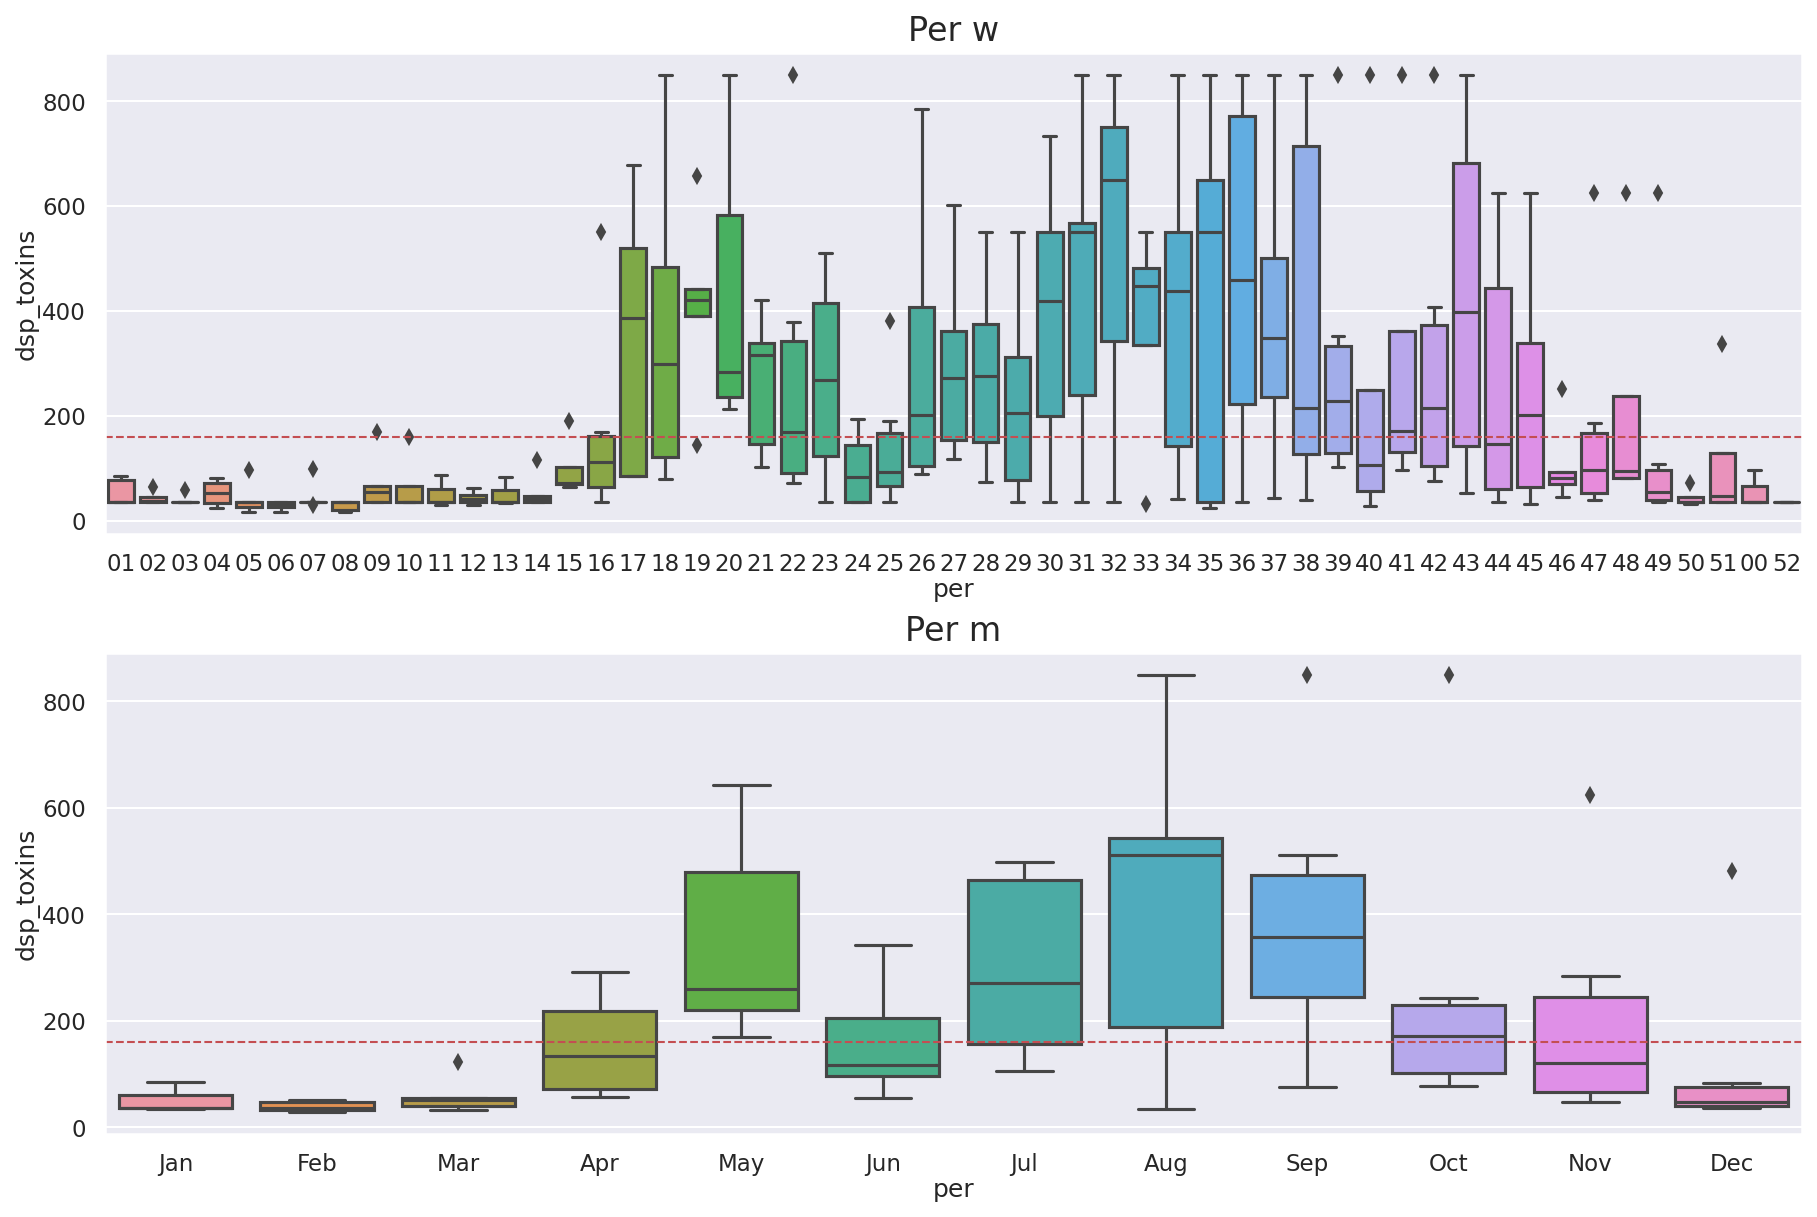

In [14]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

axes[0] = boxplot_season_per(ts_week, 'w', axes[0])
axes[1] = boxplot_season_per(ts_month, 'm', axes[1])
plt.show()

## Trend

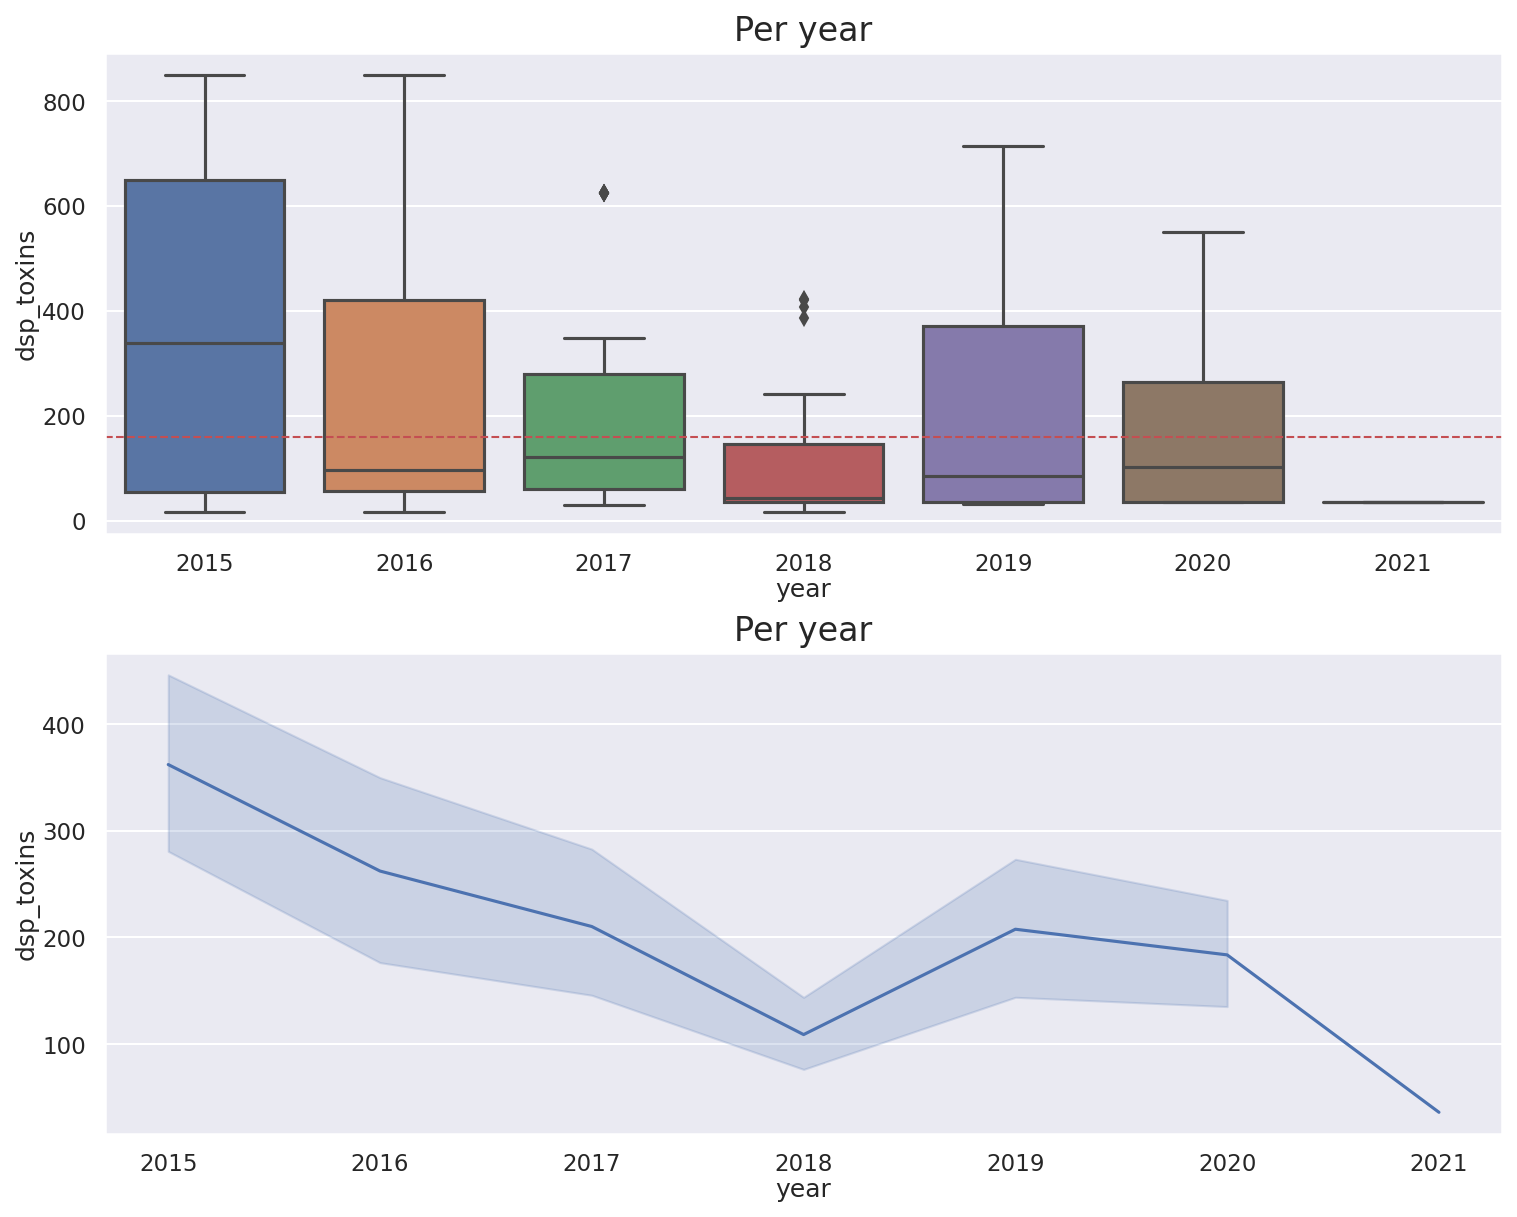

In [15]:
fig, axes = plt.subplots(2,1, figsize=(10,8), constrained_layout=True)

axes[0] = boxplot_trend(ts_week, axes[0])
#axes[0].set_ylim(0,1000)
axes[1] = plot_trend(ts_week, axes[1])


## Decomposition

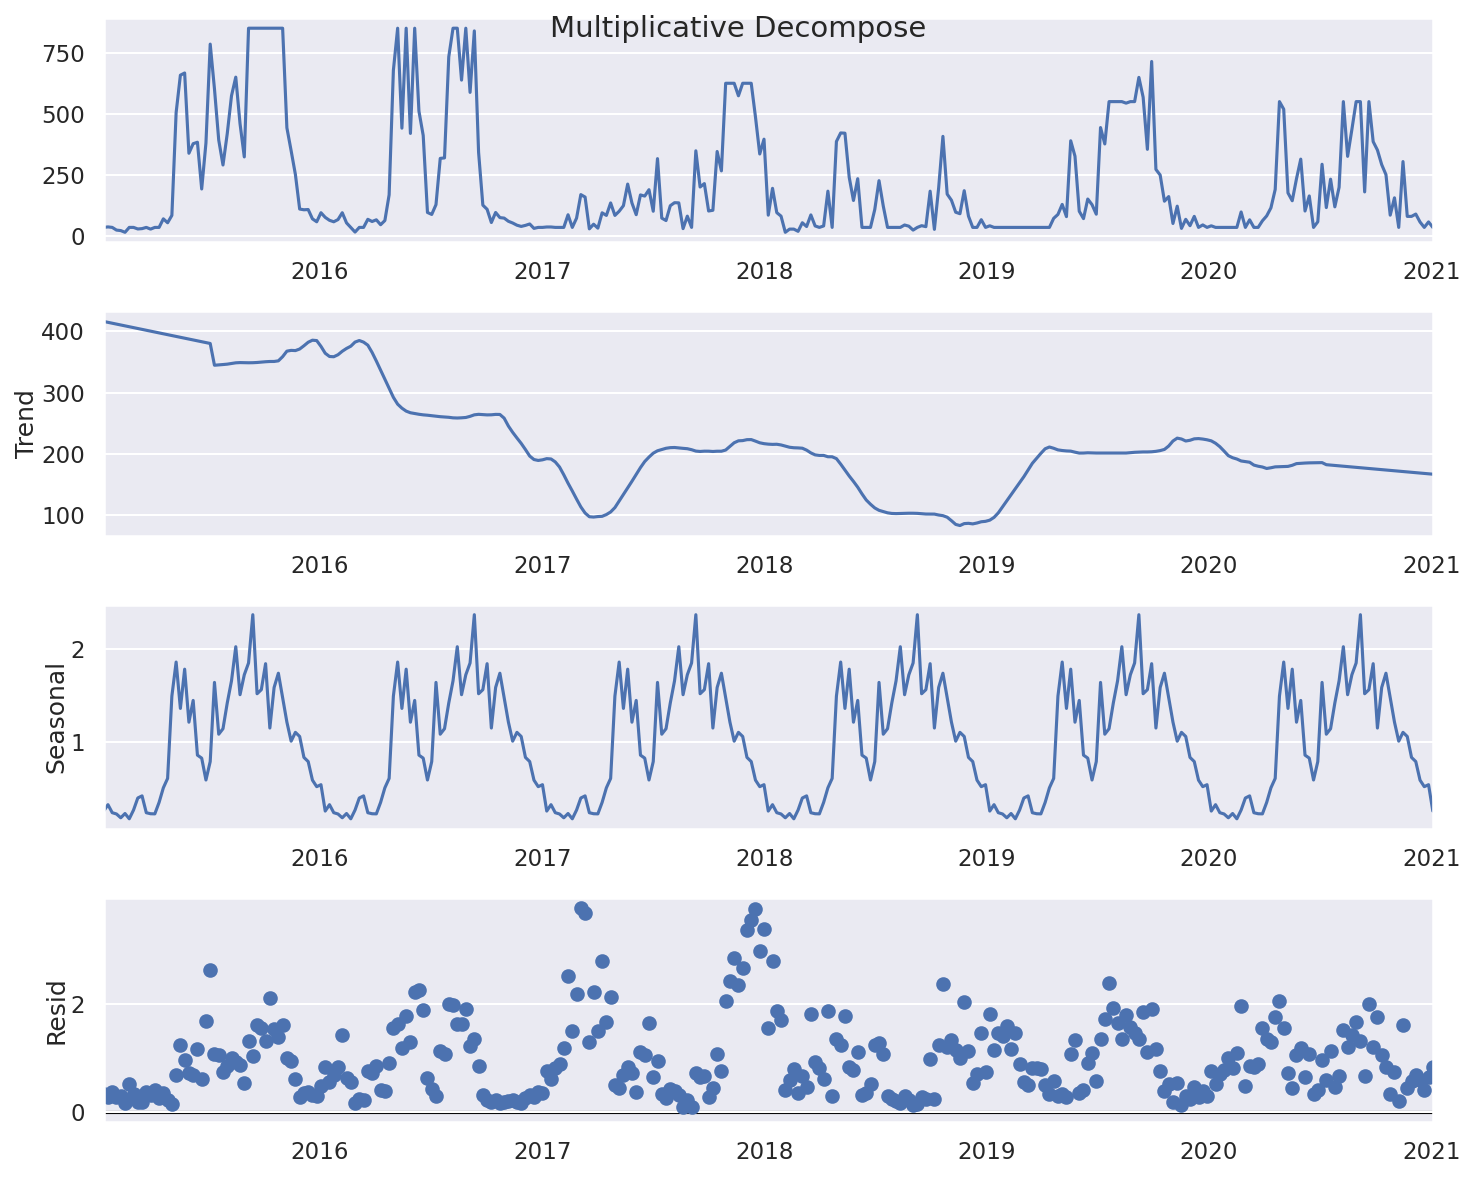

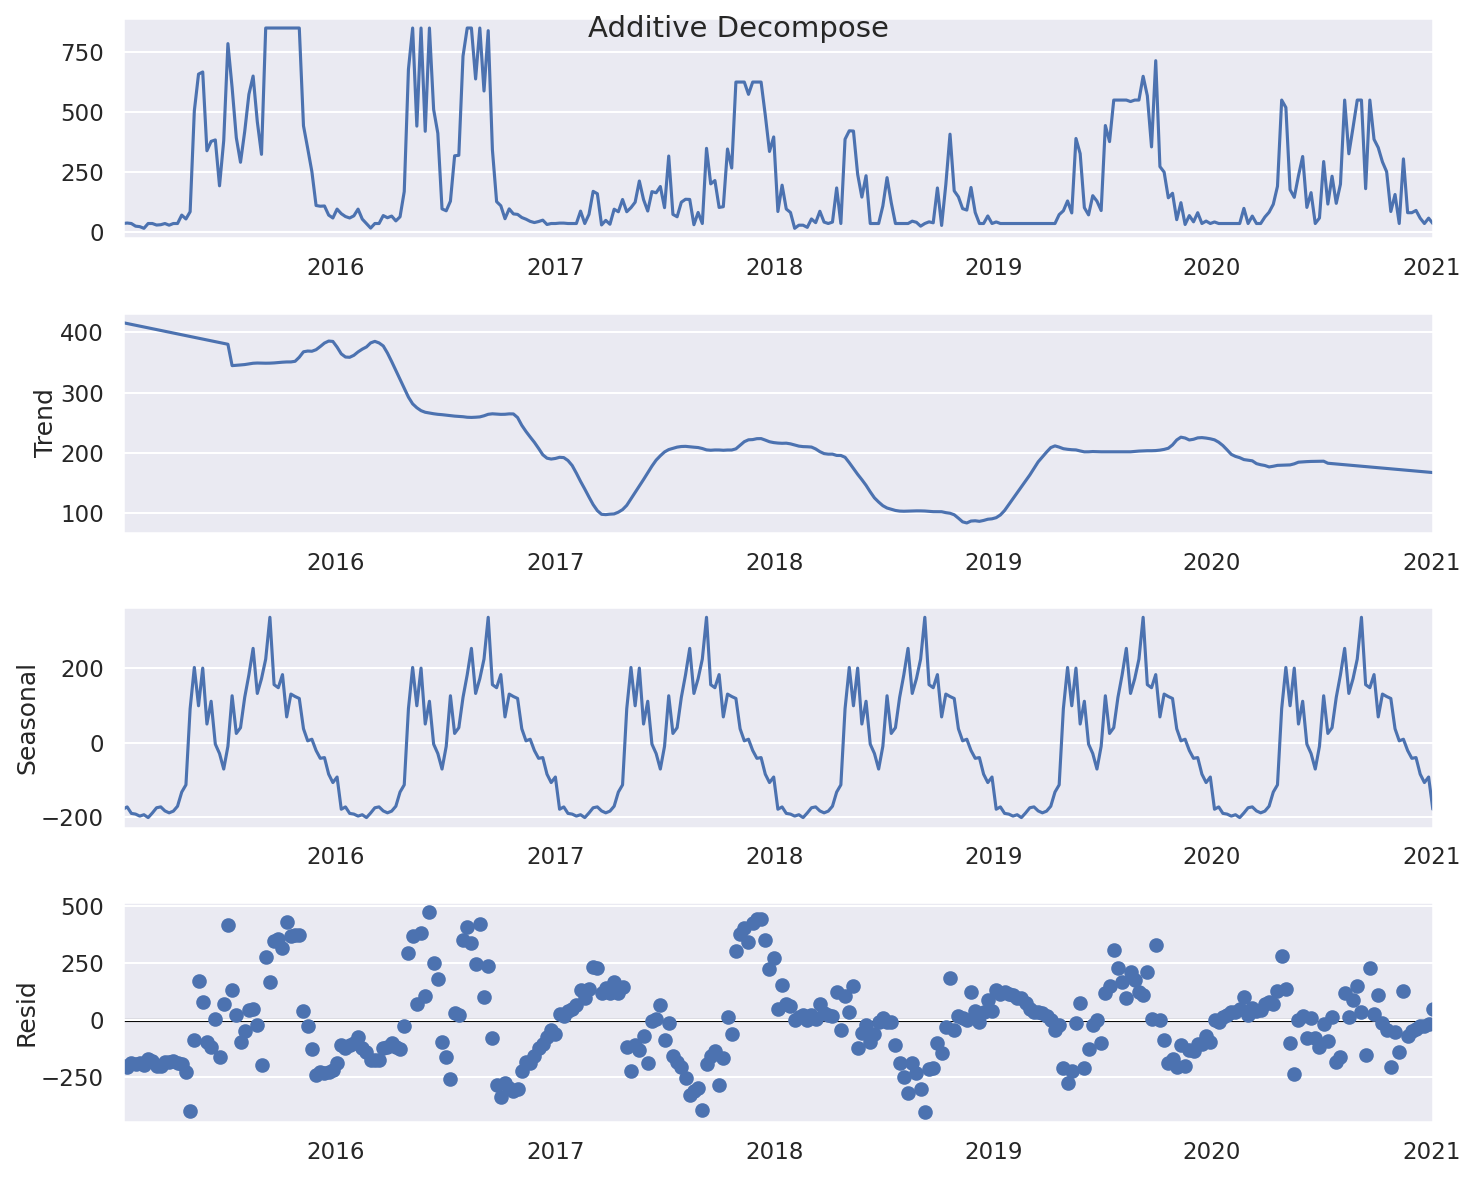

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

ts_week_processed = pd.Series(data=knn_mean(ts_week["dsp_toxins"], 10), index=ts_week["dsp_toxins"].index)

decompose(ts_week_processed)

# ETJ1 (Estuário do Tejo, Jusante da Ponte Vasco da Gama)

In [17]:
area = "ETJ1"
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Mexilhão            288
Amêijoa-japonesa     98
Berbigão              6
Pé-de-burrinho        6
Lambujinha            1
Name: Species, dtype: int64

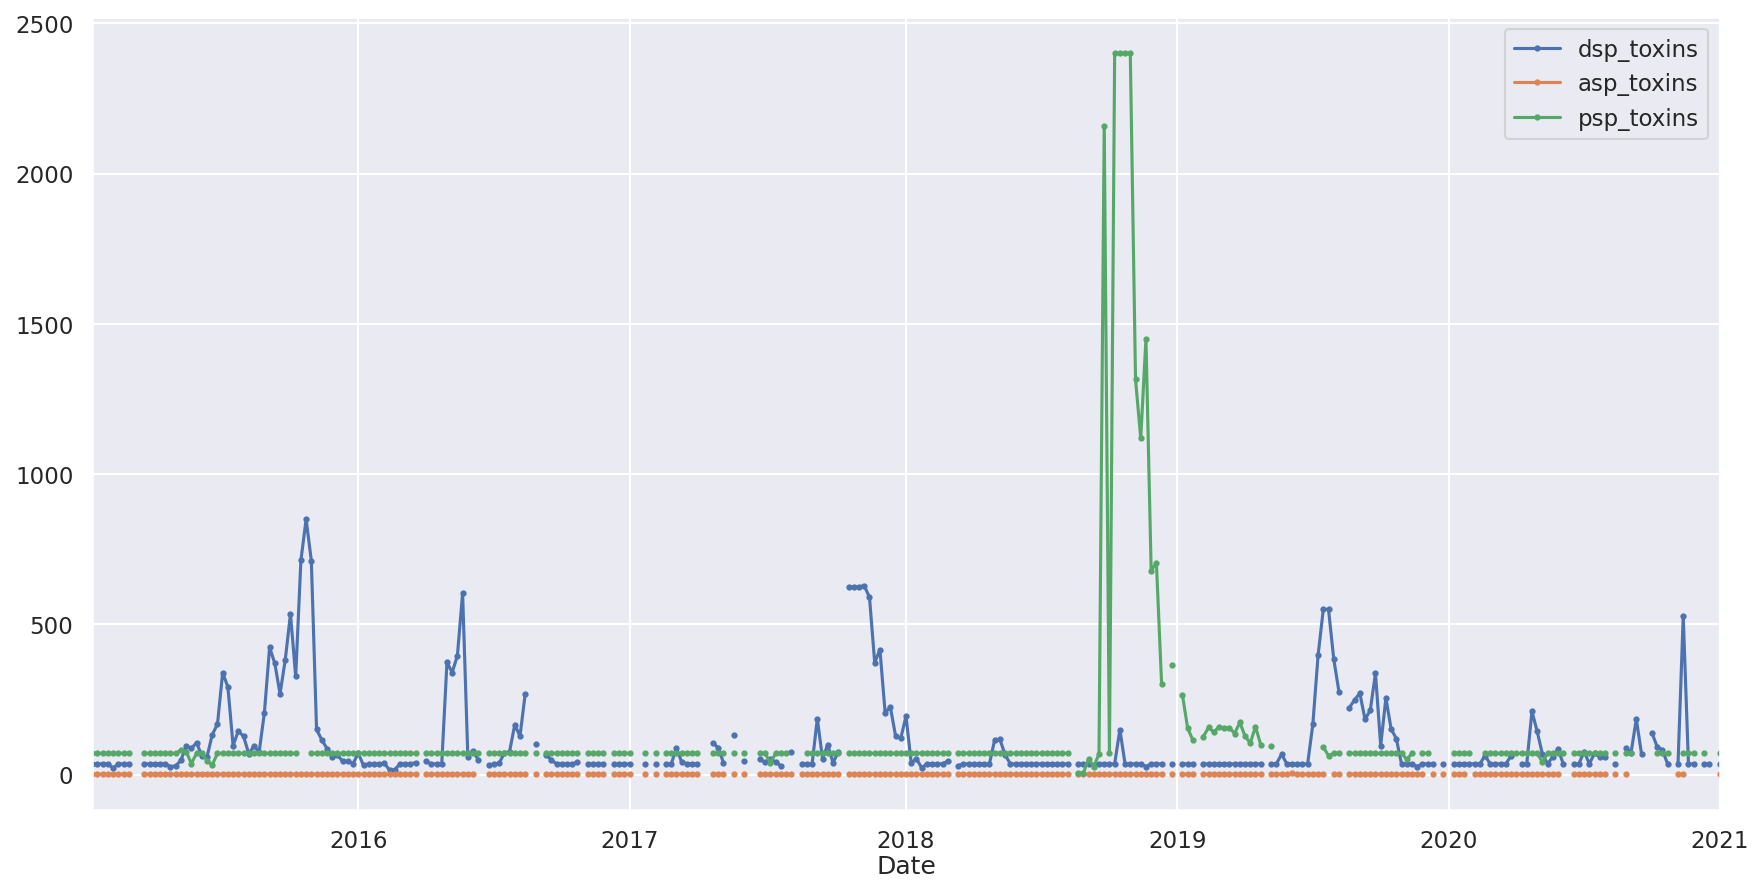

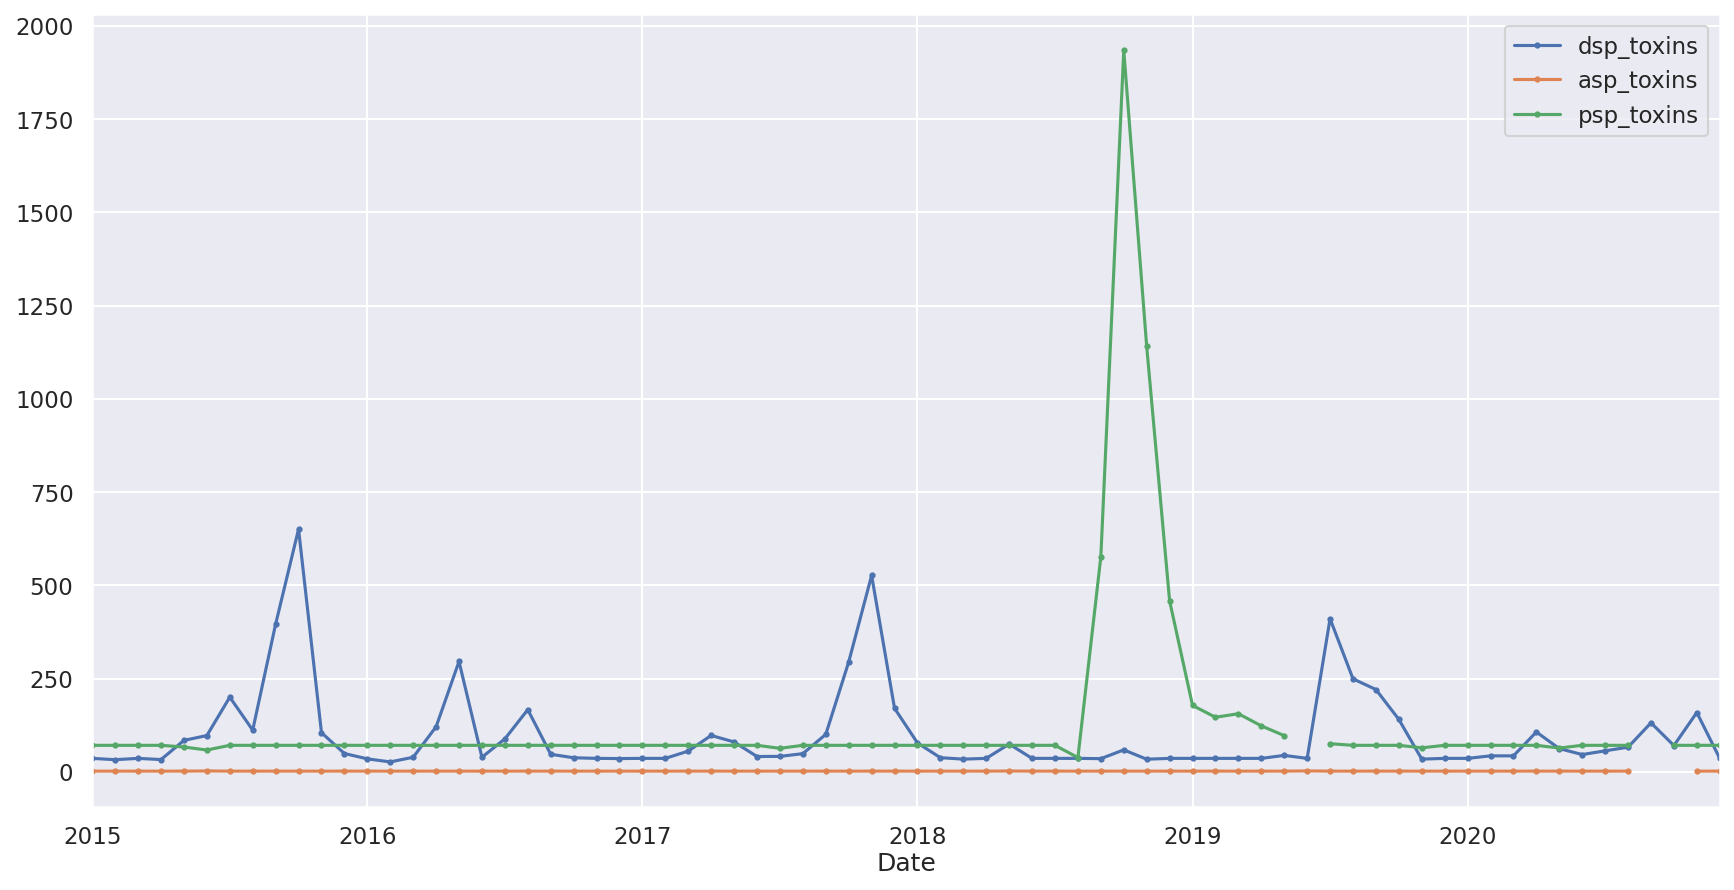

In [18]:
ts_week = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

Quando interpolado usando **week** a data representa o fim da semana

## Imputation

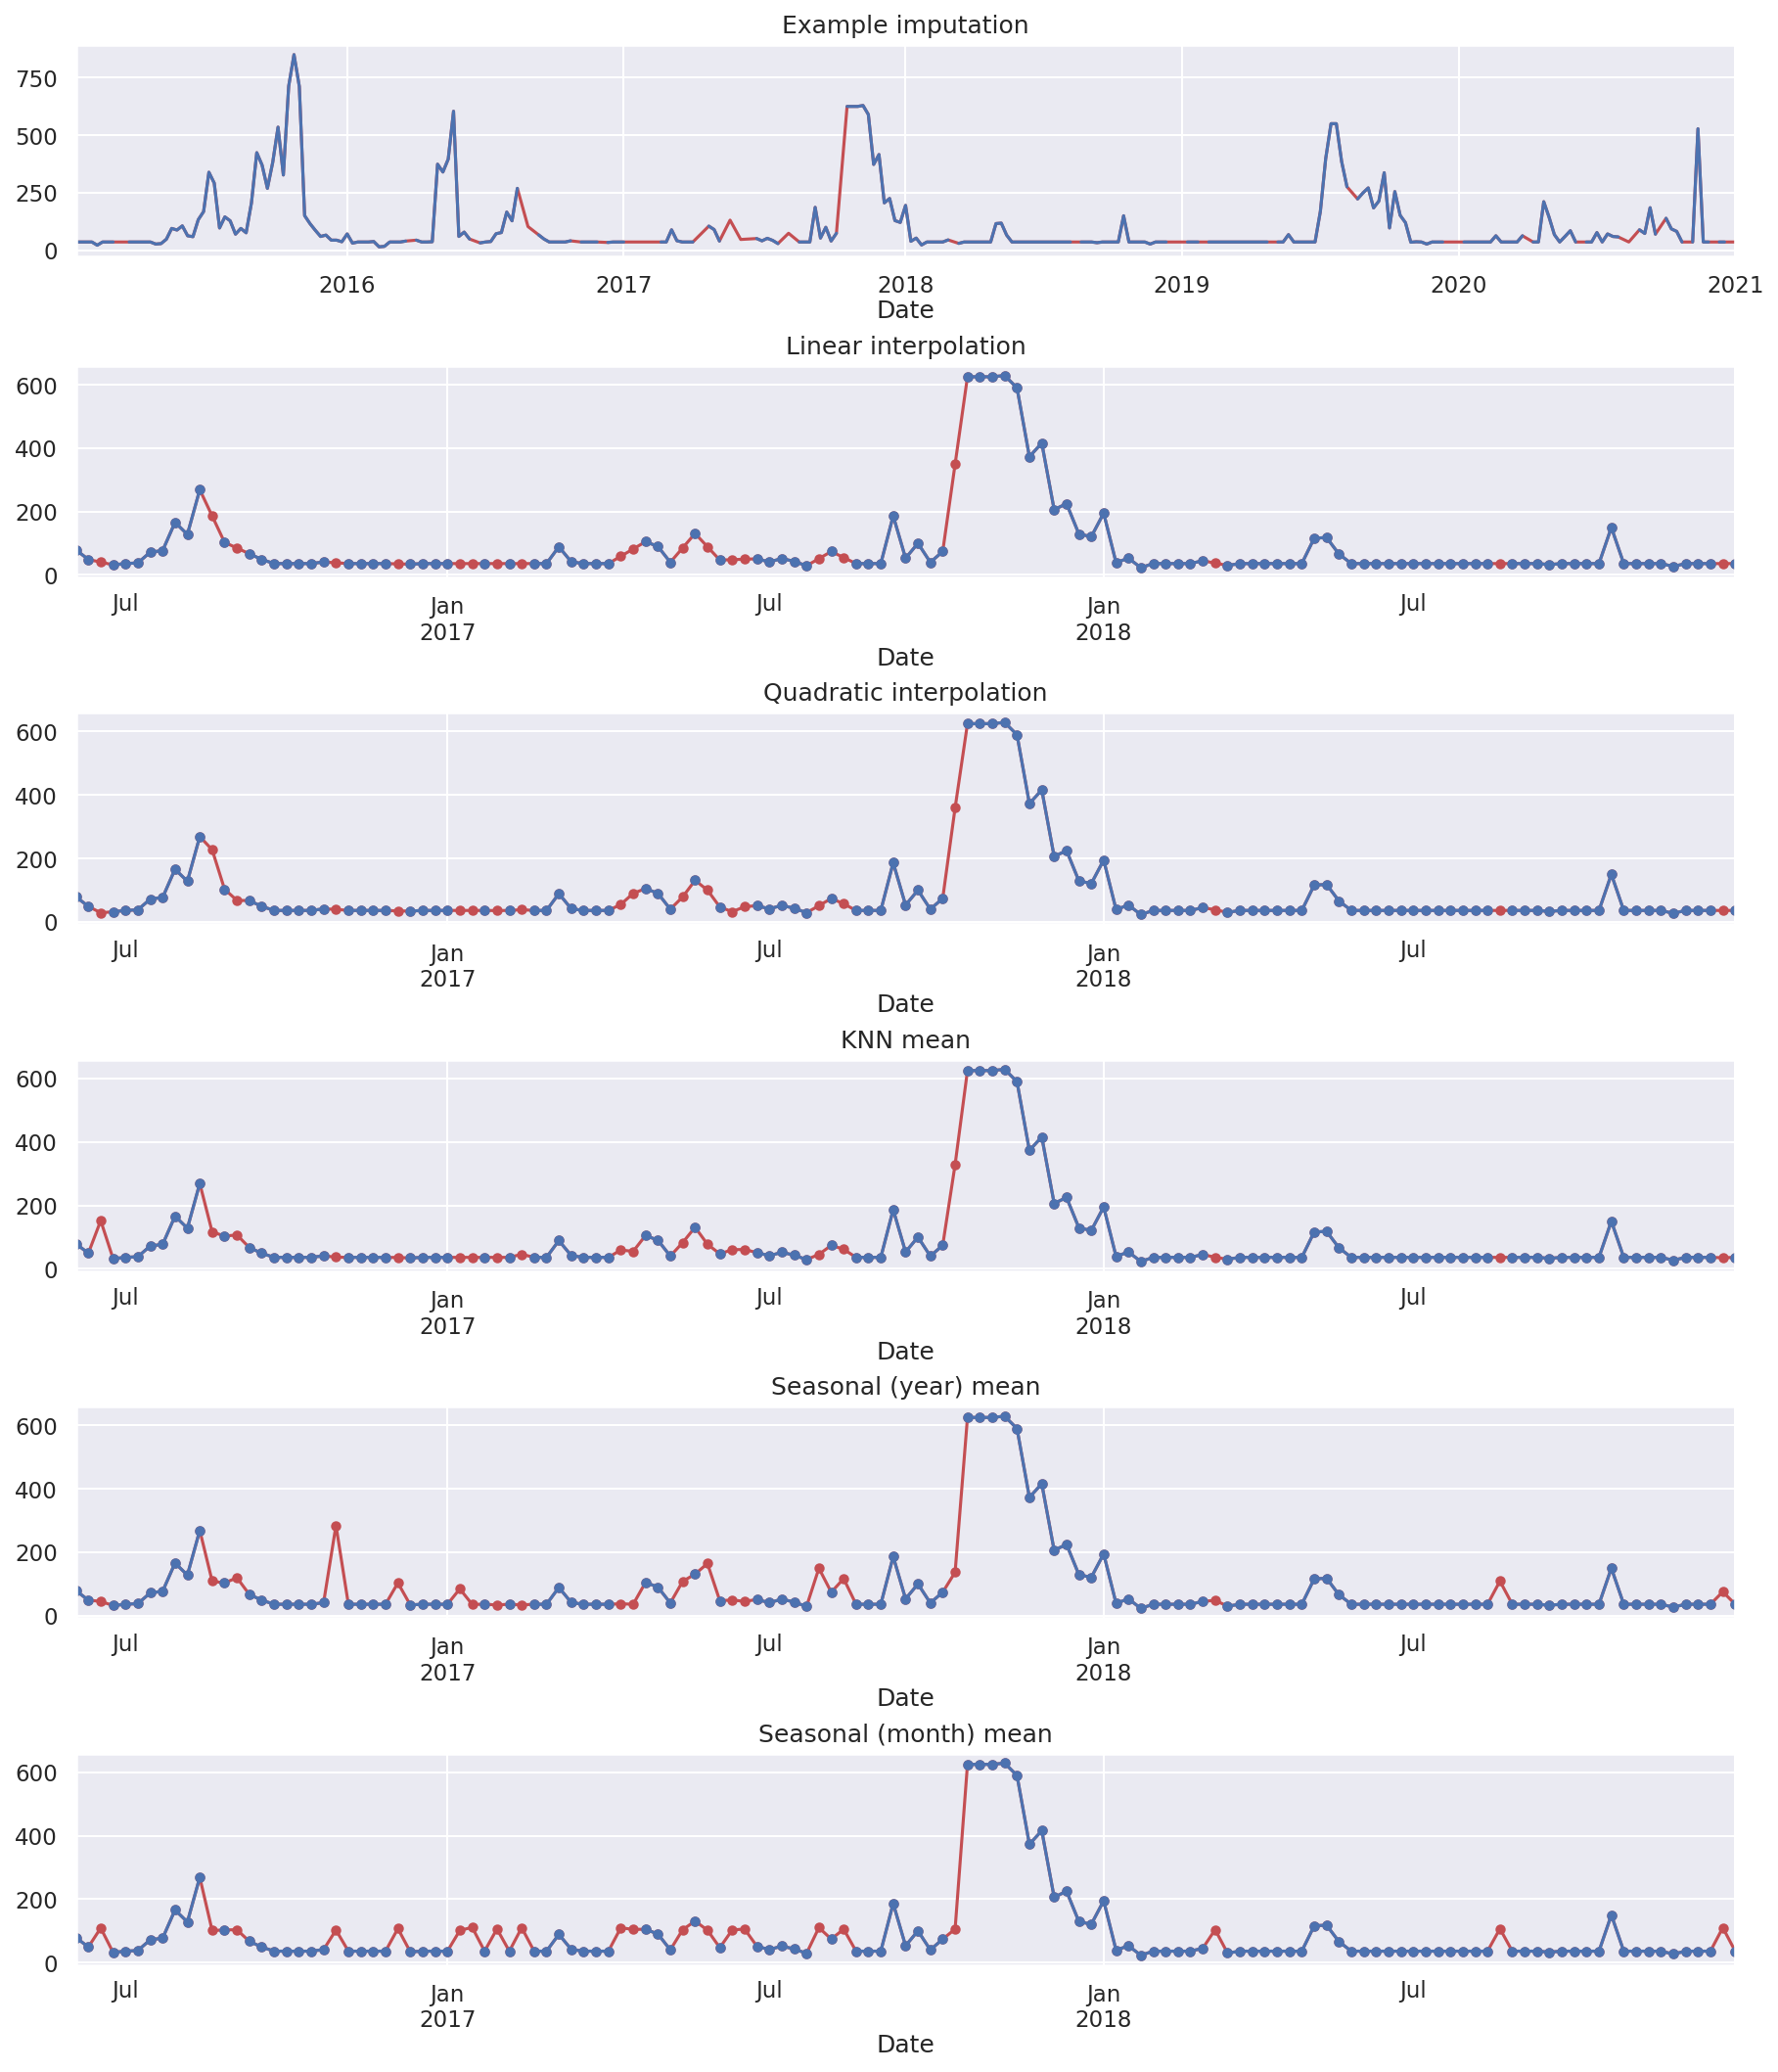

In [24]:
imps = ["linear", "quadratic", "knn", "seasonal_year", "seasonal_month"]
plot_imputations(ts_week, "dsp_toxins", imps, begin="2016-06-01", end="2018")

## Seasonality

2020 só NaN em Setembro, 1 valor para Outubro, NaN Novembro e 1 Dezembro

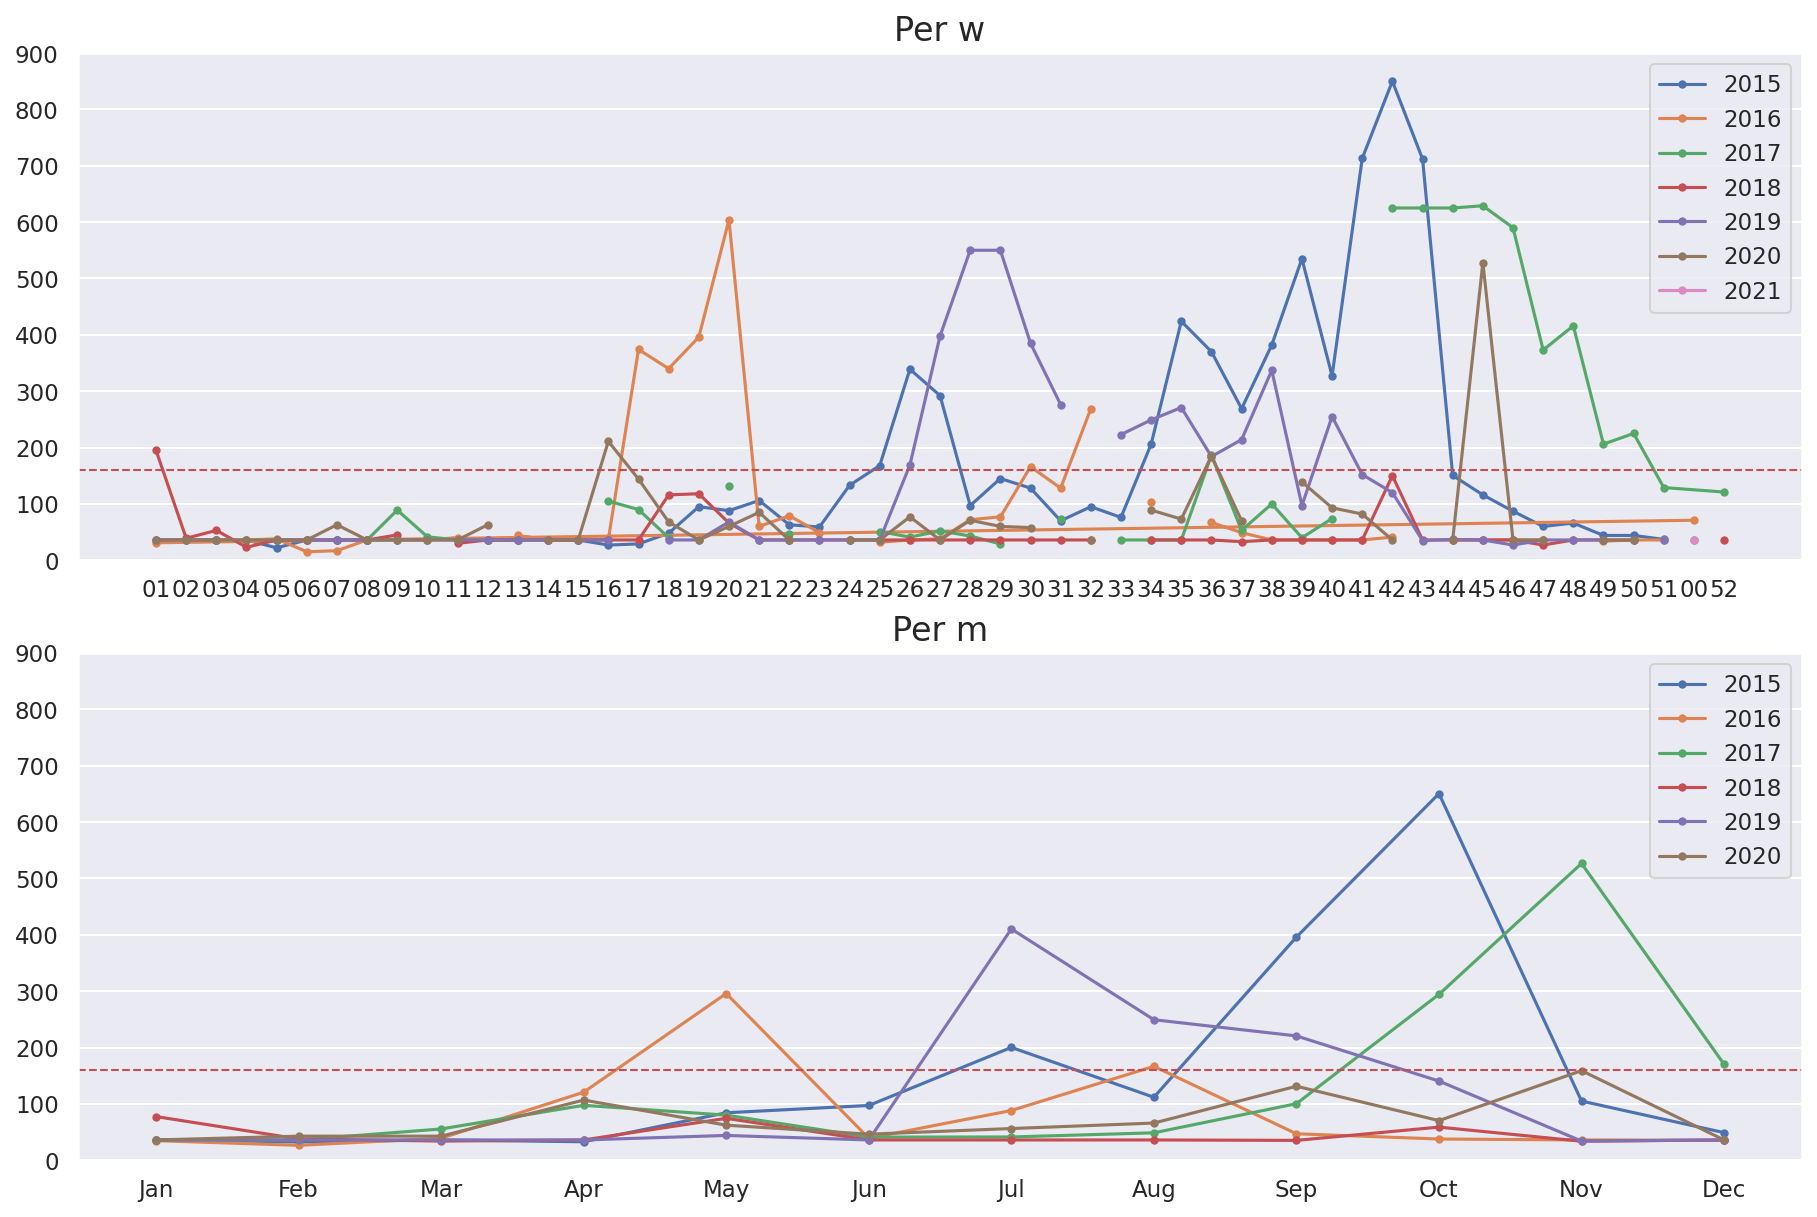

In [25]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

axes[0] = plot_season_per(ts_week, 'w', axes[0])
axes[1] = plot_season_per(ts_month, 'm', axes[1])

axes[0].set_ylim(0,900)
axes[1].set_ylim(0,900)

plt.show()

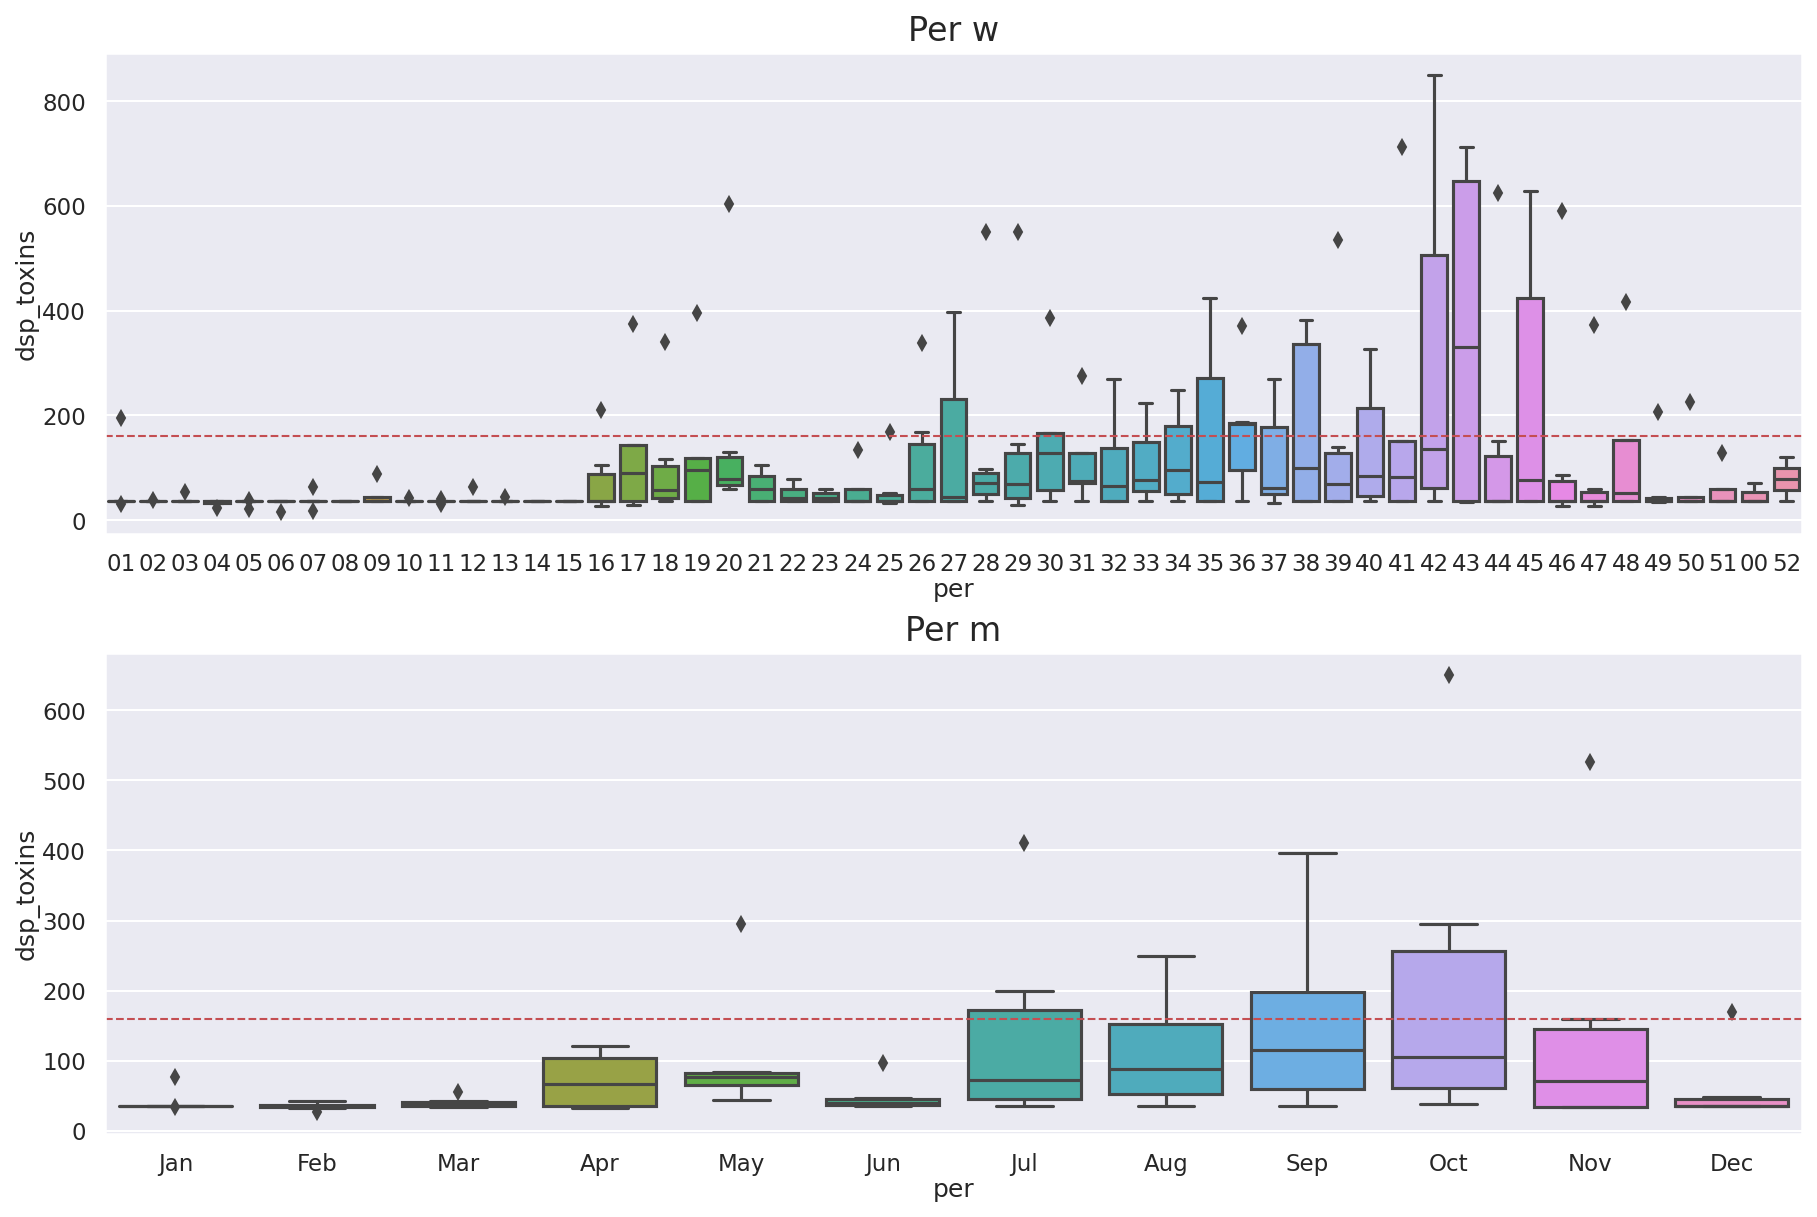

In [21]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

axes[0] = boxplot_season_per(ts_week, 'w', axes[0])
axes[1] = boxplot_season_per(ts_month, 'm', axes[1])
plt.show()

## Trend

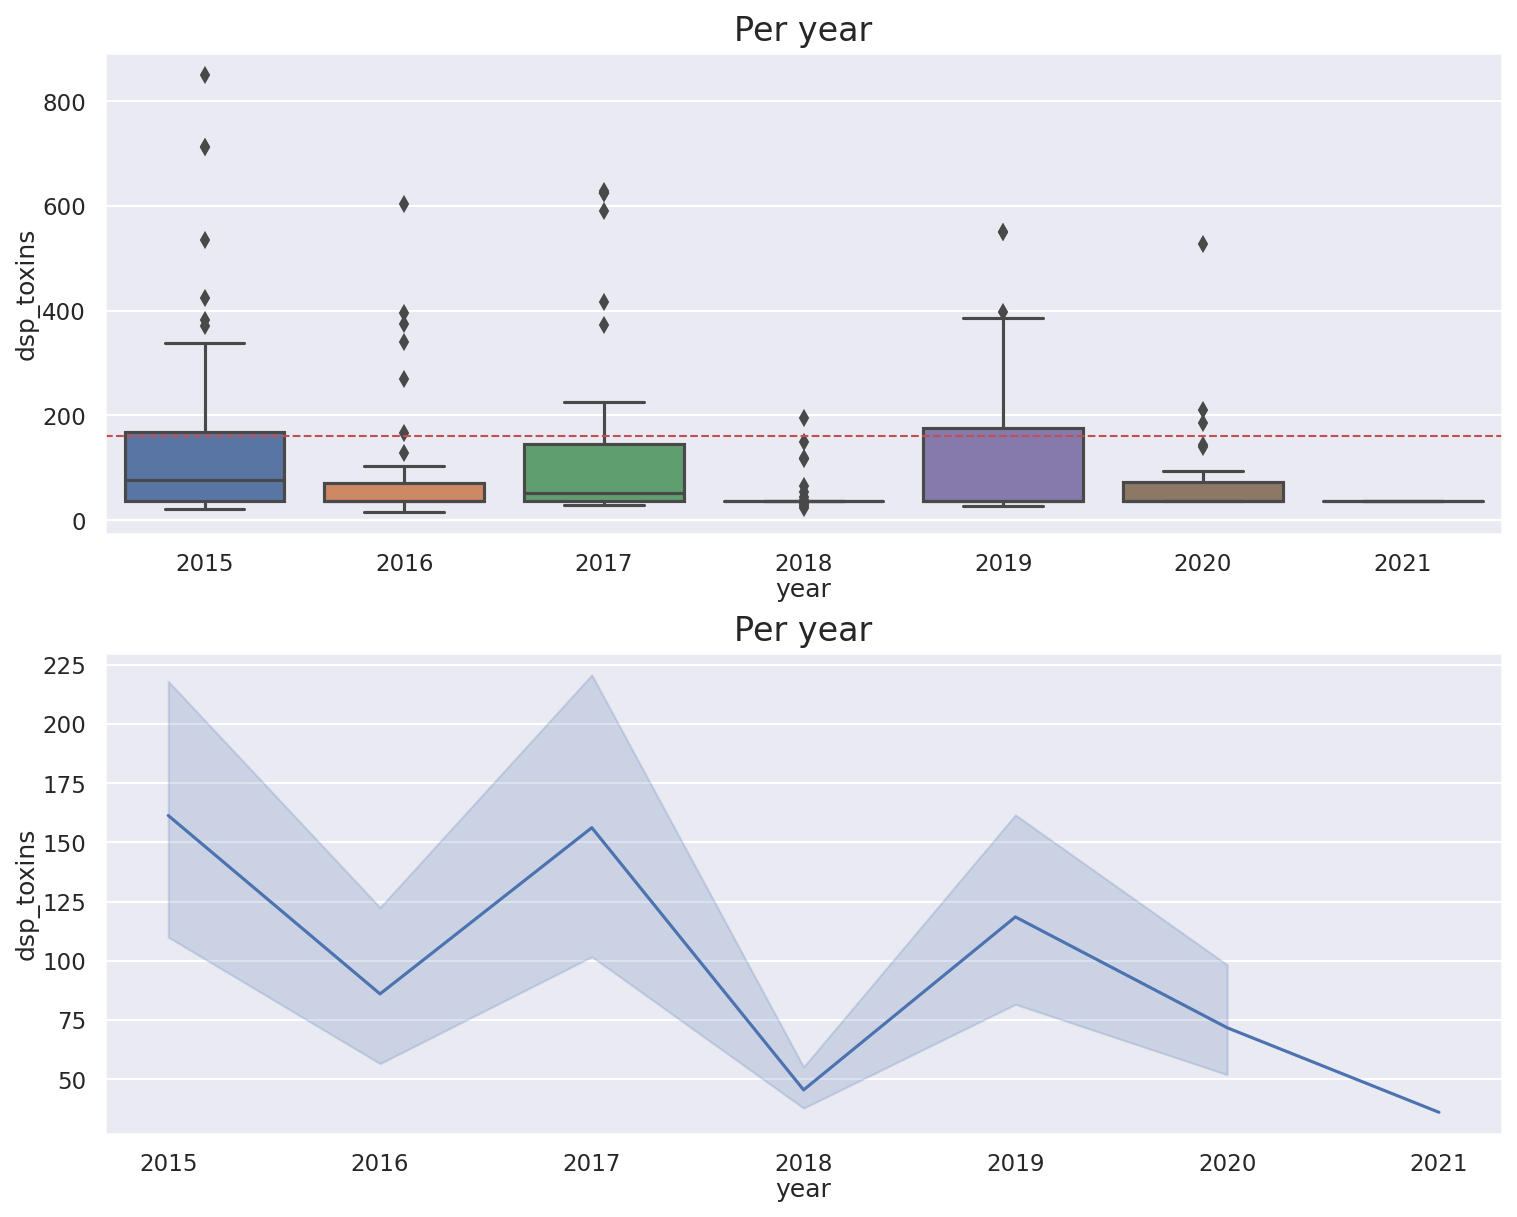

In [22]:
fig, axes = plt.subplots(2,1, figsize=(10,8), constrained_layout=True)

axes[0] = boxplot_trend(ts_week, axes[0])
#axes[0].set_ylim(0,1000)
axes[1] = plot_trend(ts_week, axes[1])


## Decomposition

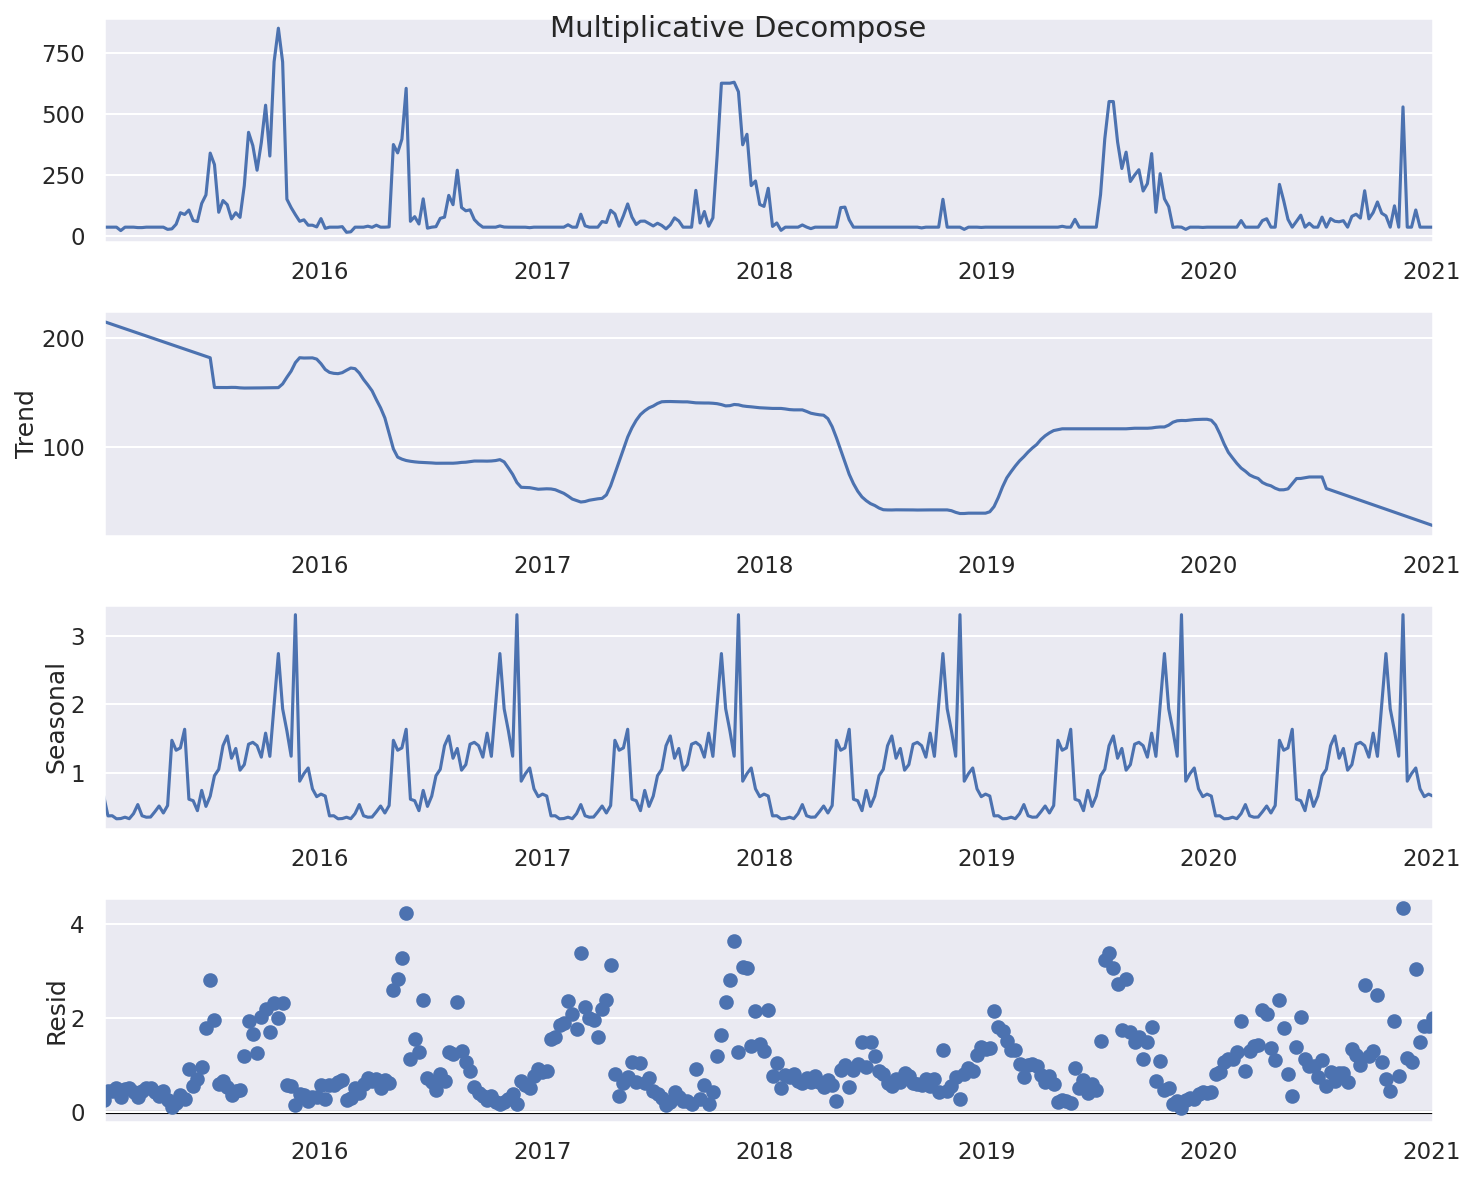

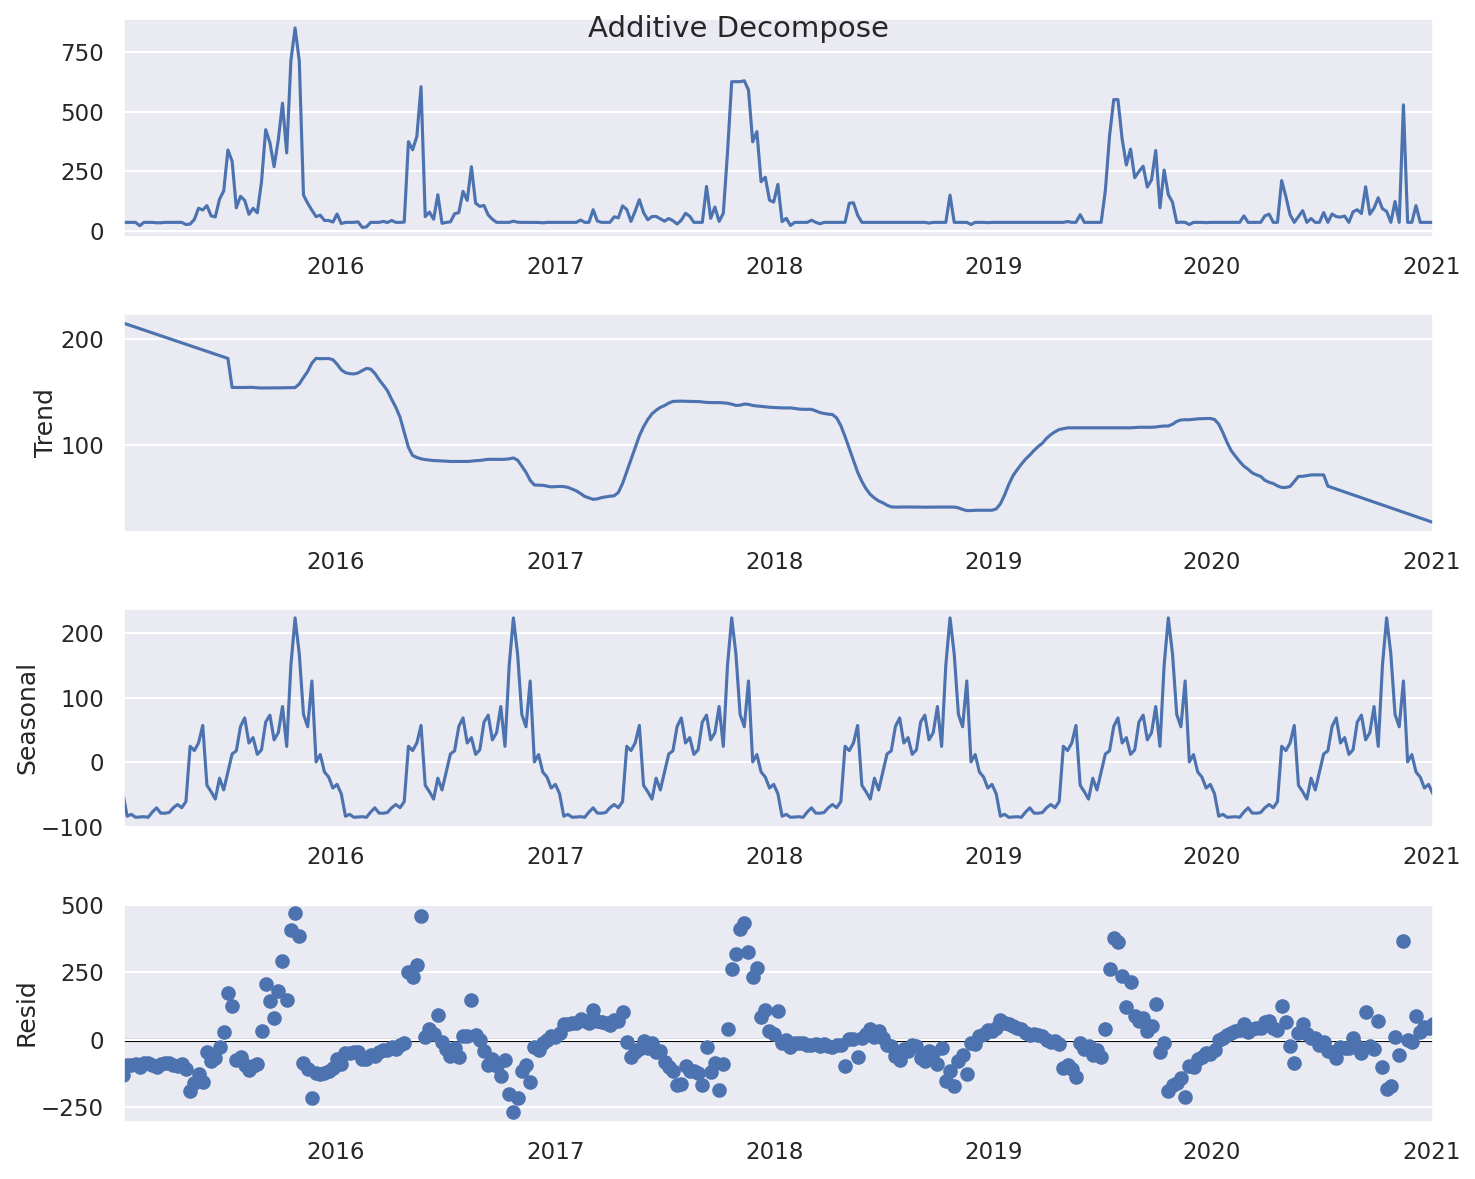

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

ts_week_processed = pd.Series(data=knn_mean(ts_week["dsp_toxins"], 10), index=ts_week["dsp_toxins"].index)

decompose(ts_week_processed)

# OLH2 (Ria Formosa, Olhão)

In [27]:
area = "OLH2"
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Mexilhão                  284
Amêijoa-boa                22
Berbigão                   21
Longueirão                 17
Amêijoa-cão                14
Ostra-japonesa/gigante     11
Ostra                       4
Amêijoa-macha               4
Name: Species, dtype: int64

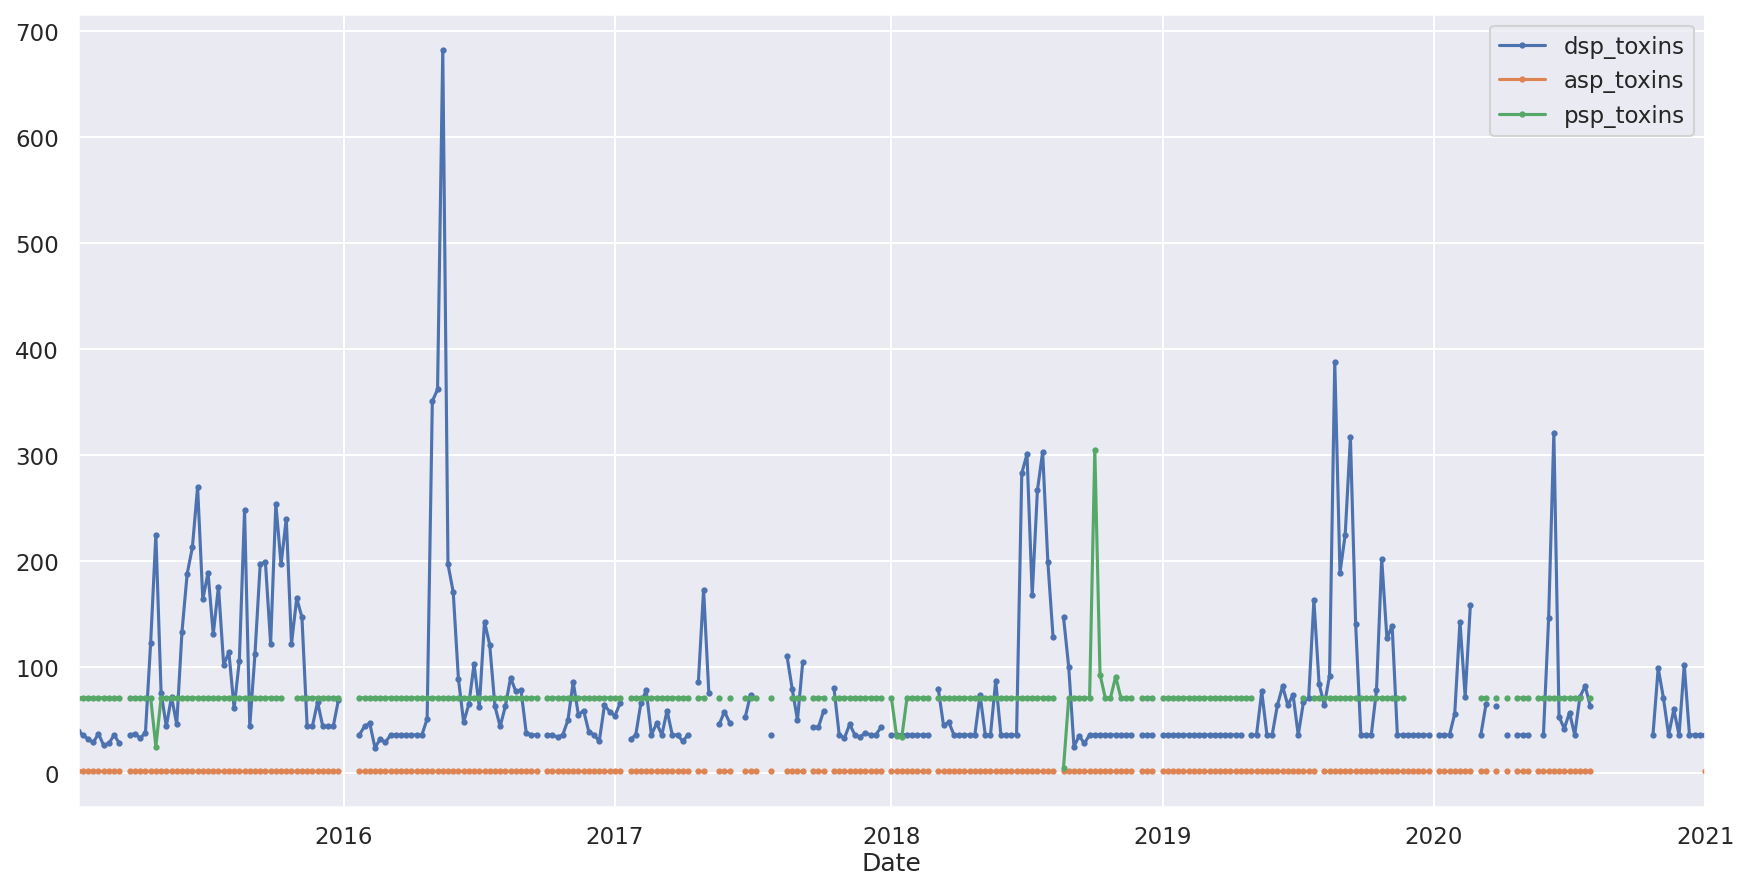

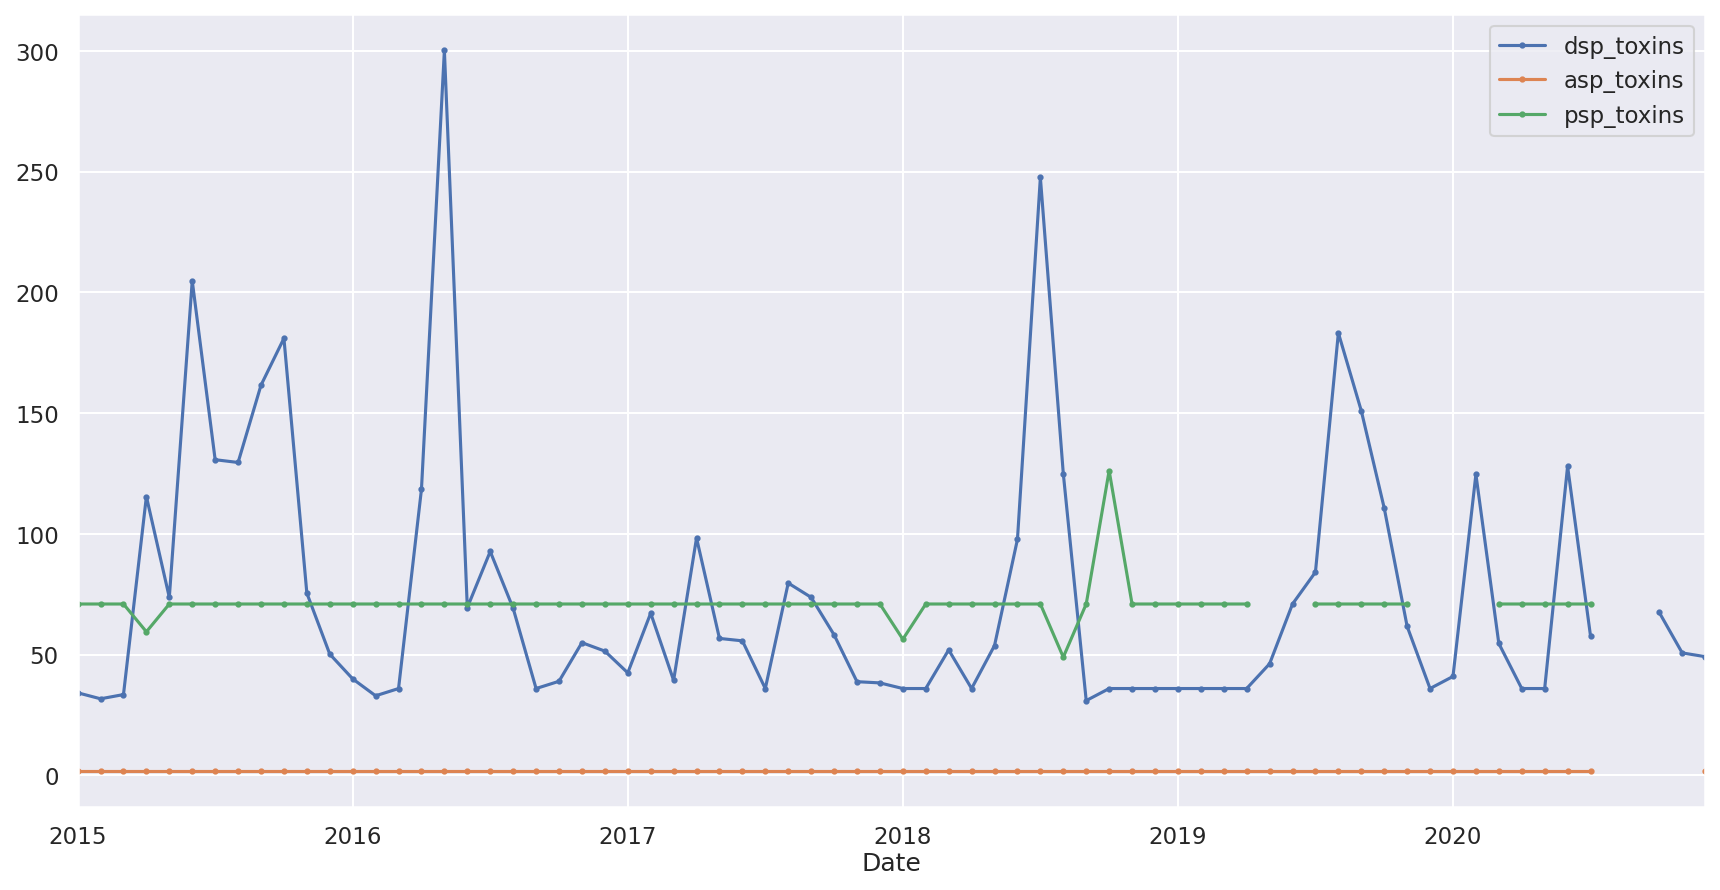

In [28]:
ts_week = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

Quando interpolado usando **week** a data representa o fim da semana

## Imputation

/tmp/ipykernel_73801/1637549505.py:25: RuntimeWarning: Mean of empty slice
  out[i] = np.nanmean(ts_near)


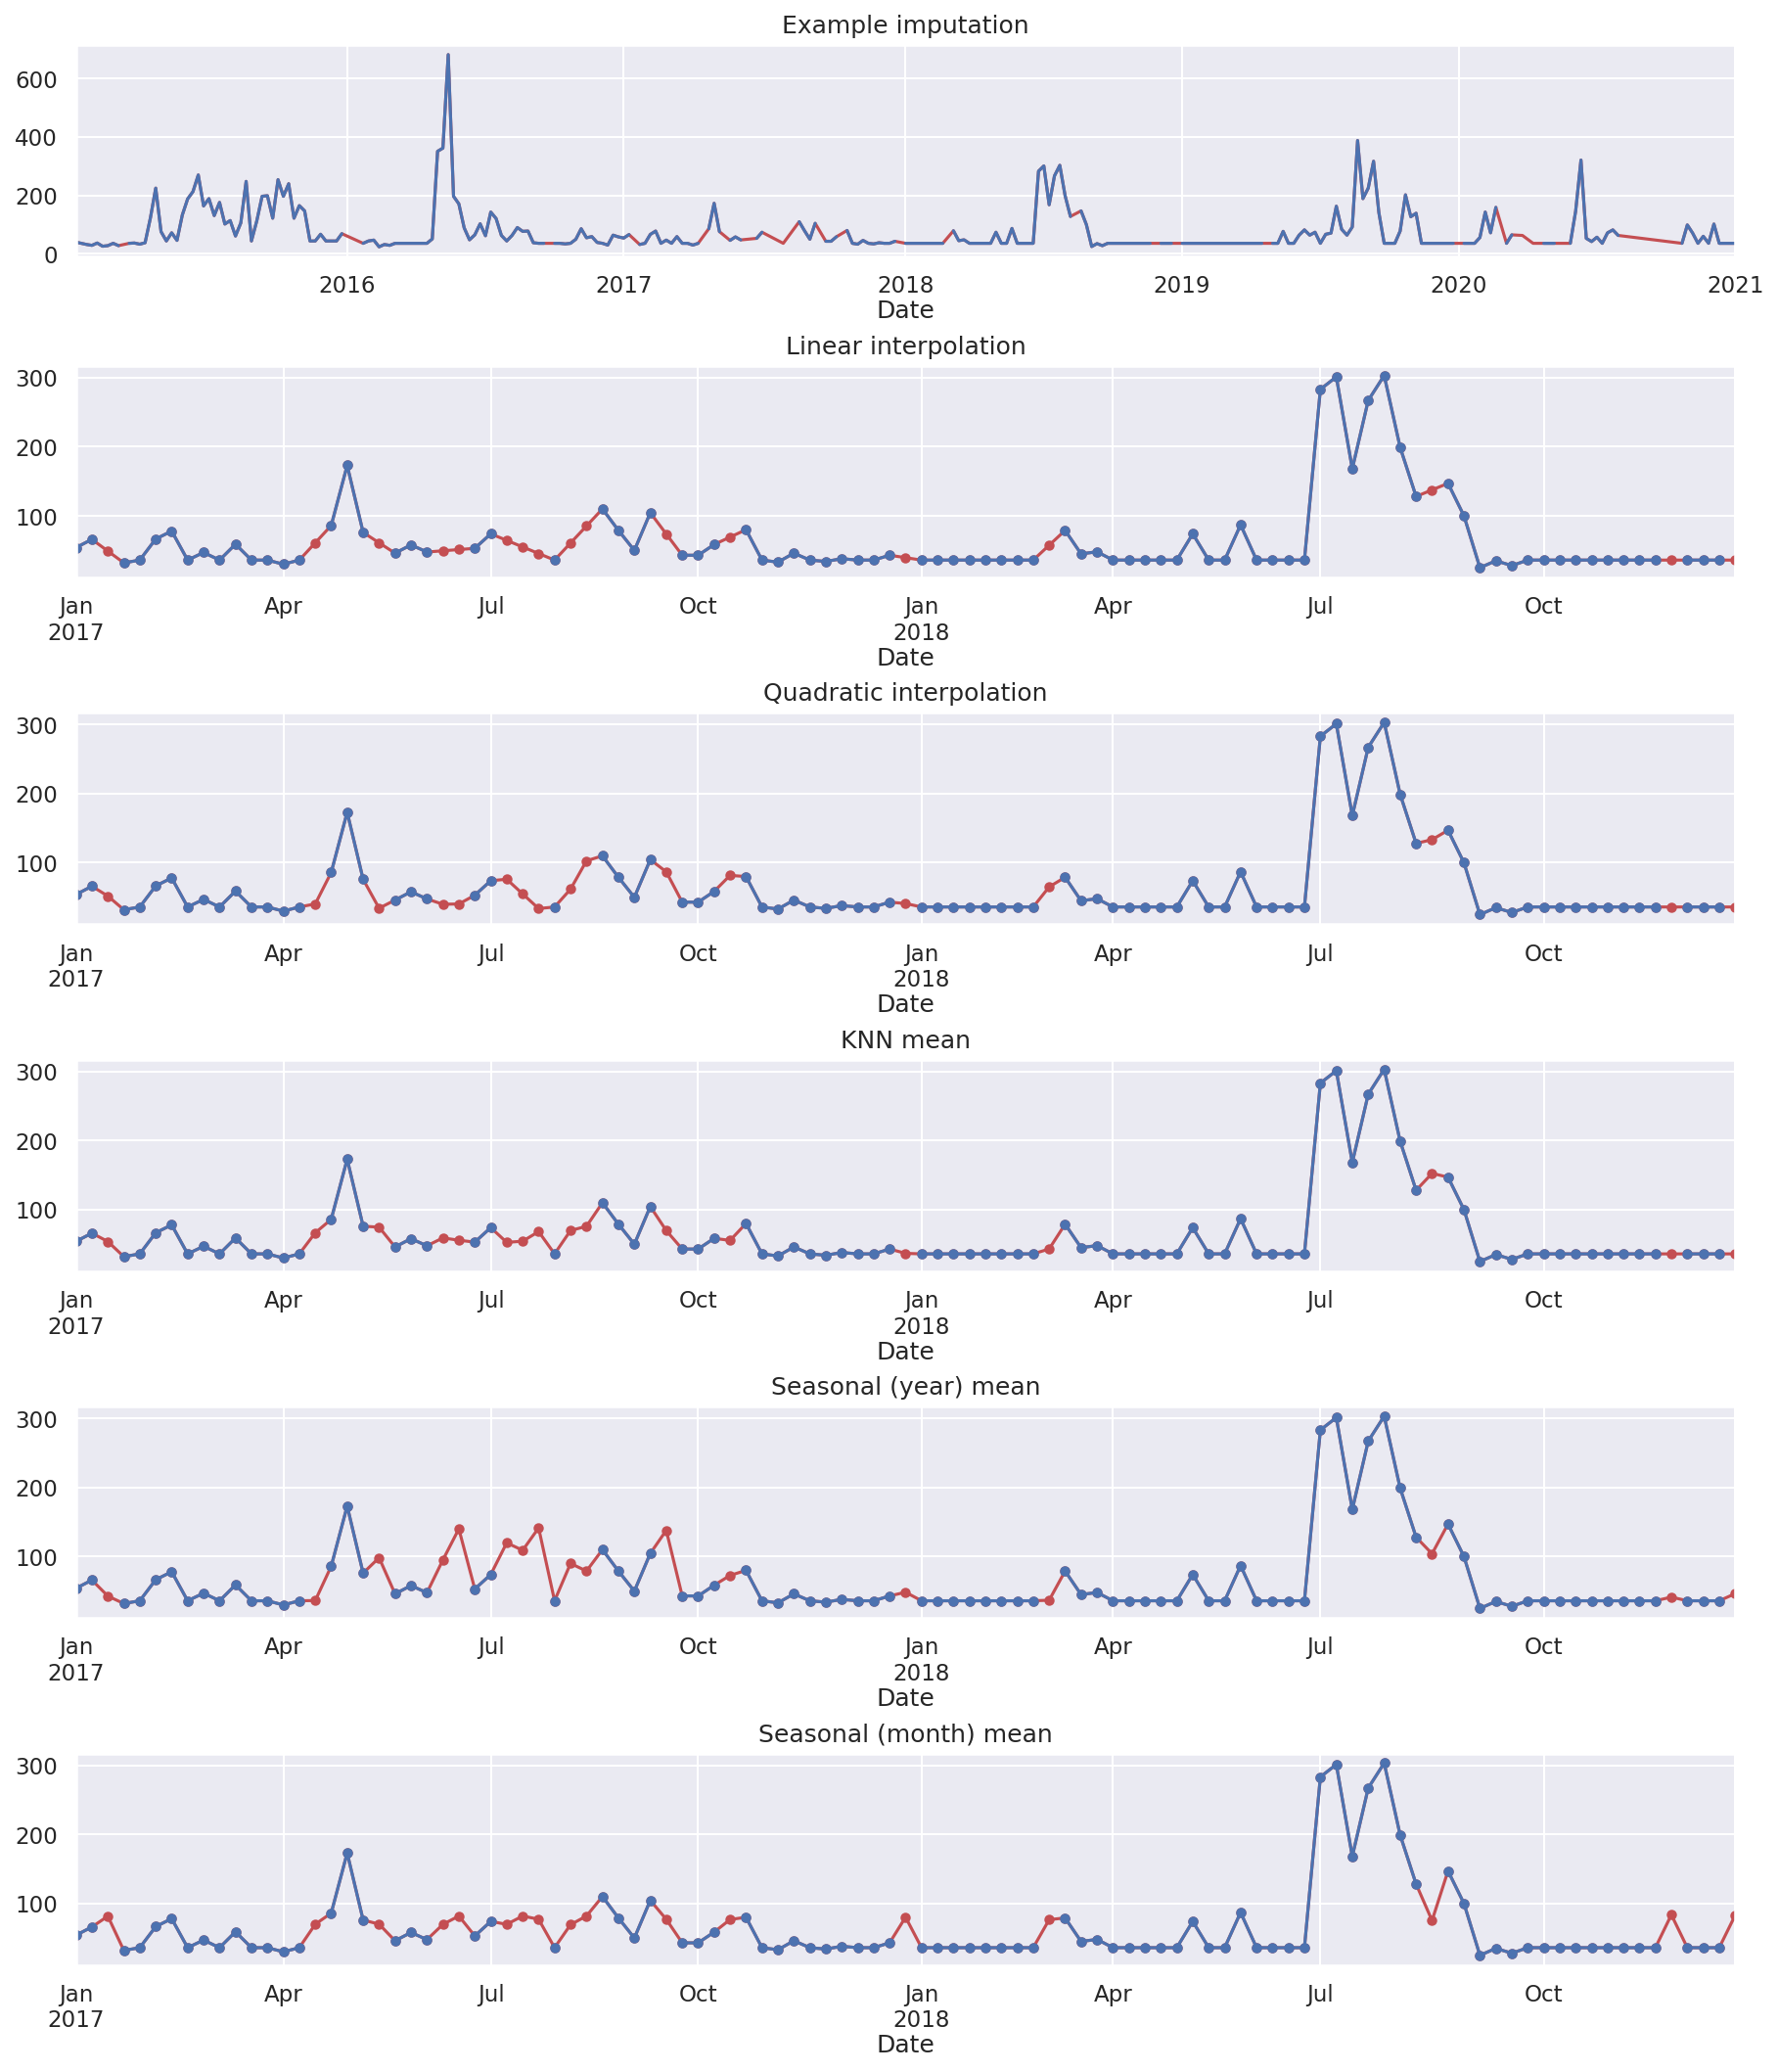

In [34]:
imps = ["linear", "quadratic", "knn", "seasonal_year", "seasonal_month"]
plot_imputations(ts_week, "dsp_toxins", imps, begin="2017", end="2018")

## Seasonality

2020 só NaN em Setembro, 1 valor para Outubro, NaN Novembro e 1 Dezembro

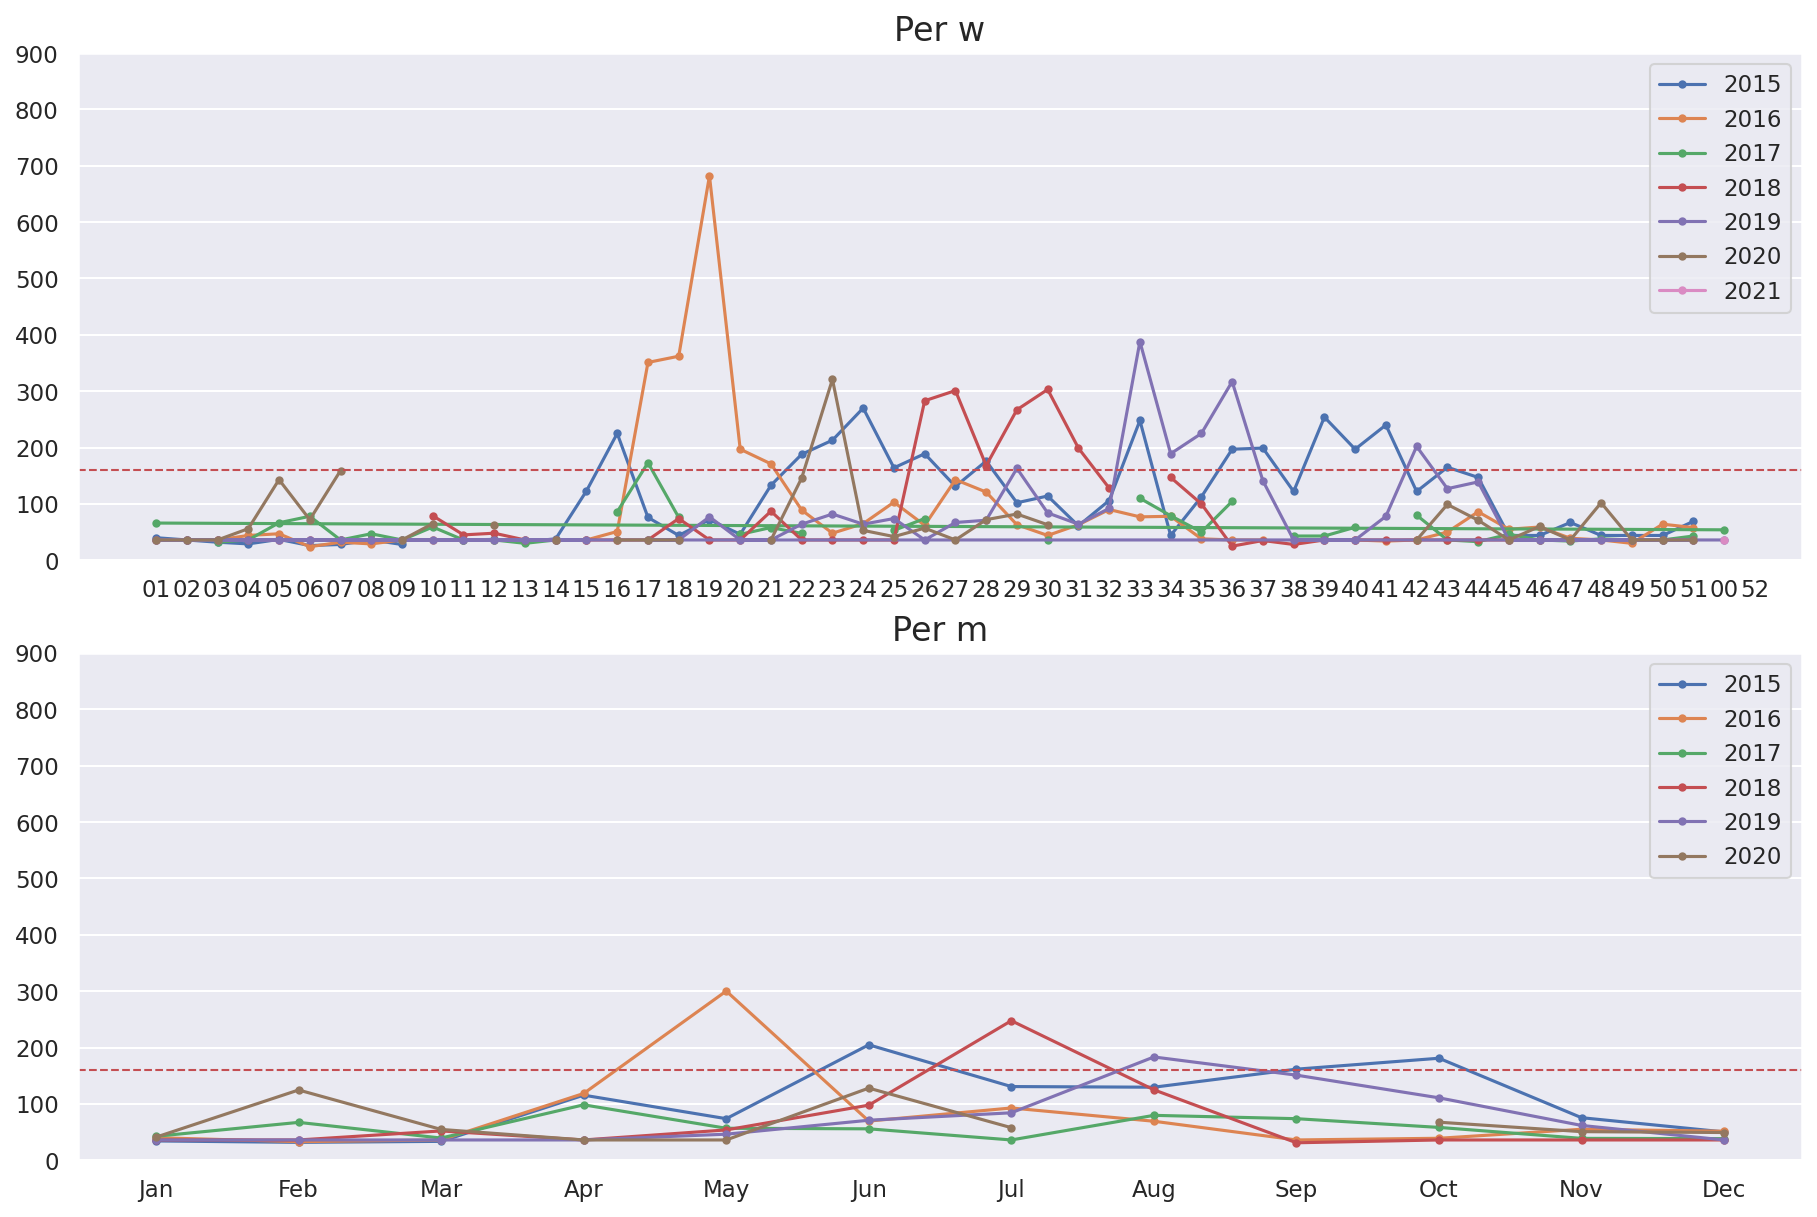

In [30]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

axes[0] = plot_season_per(ts_week, 'w', axes[0])
axes[1] = plot_season_per(ts_month, 'm', axes[1])

axes[0].set_ylim(0,900)
axes[1].set_ylim(0,900)

plt.show()

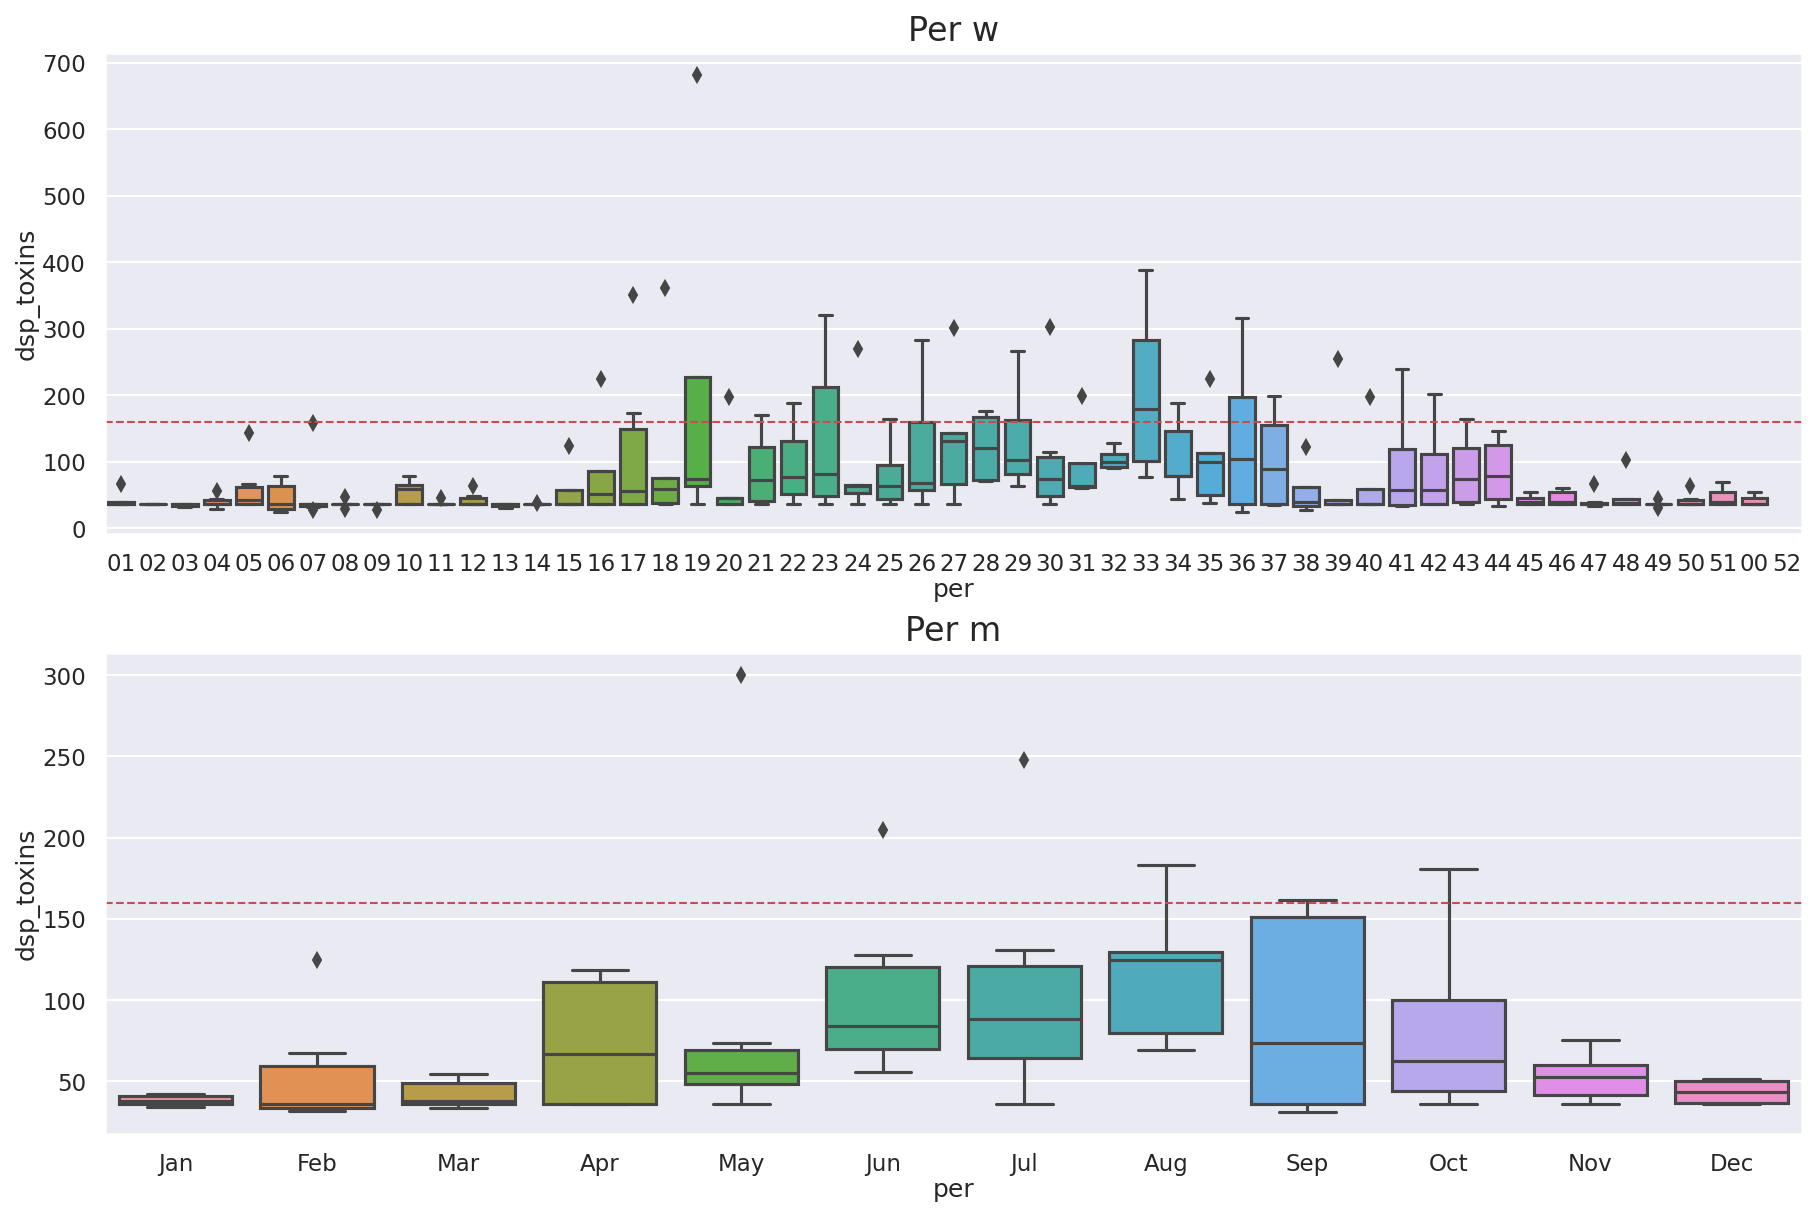

In [31]:
fig, axes = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)

axes[0] = boxplot_season_per(ts_week, 'w', axes[0])
axes[1] = boxplot_season_per(ts_month, 'm', axes[1])
plt.show()

## Trend

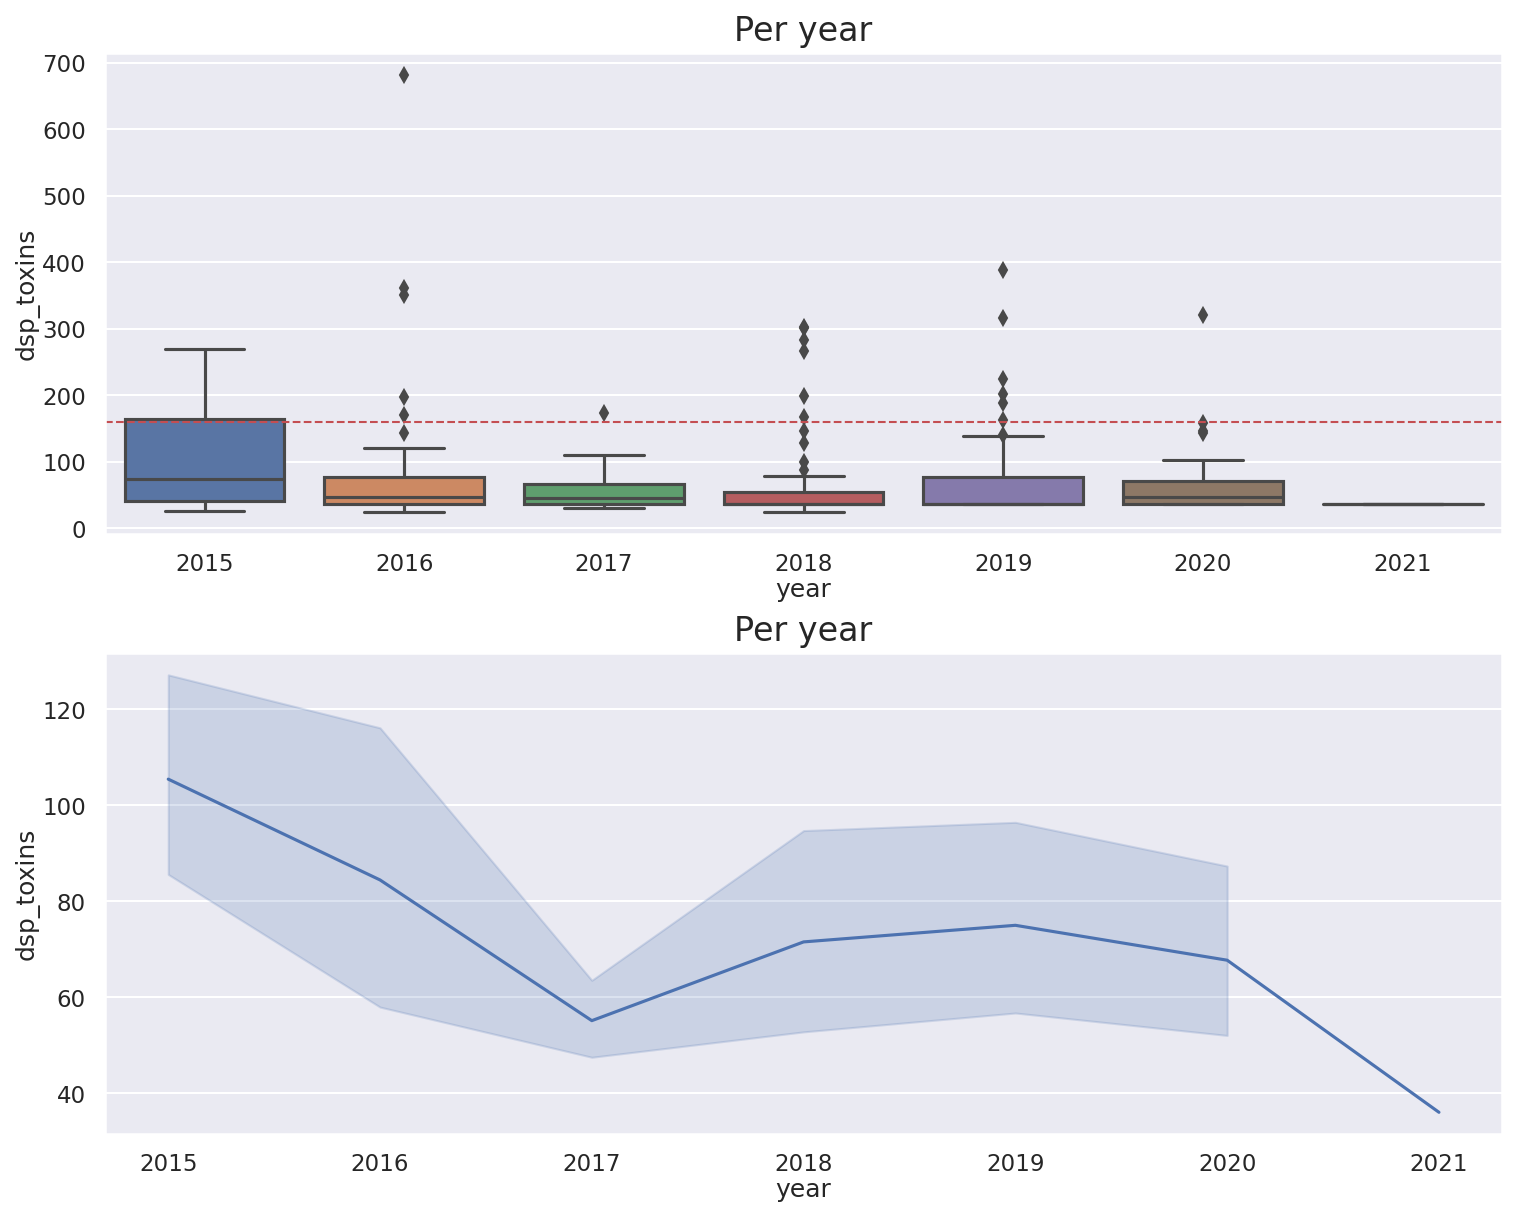

In [32]:
fig, axes = plt.subplots(2,1, figsize=(10,8), constrained_layout=True)

axes[0] = boxplot_trend(ts_week, axes[0])
#axes[0].set_ylim(0,1000)
axes[1] = plot_trend(ts_week, axes[1])


## Decomposition

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

ts_week_processed = pd.Series(data=knn_mean(ts_week["dsp_toxins"], 10), index=ts_week["dsp_toxins"].index)

decompose(ts_week_processed)

/tmp/ipykernel_73801/1637549505.py:25: RuntimeWarning: Mean of empty slice
  out[i] = np.nanmean(ts_near)


ValueError: This function does not handle missing values